In [1]:
import numpy as np
#from dfba import DfbaModel, ExchangeFlux, KineticVariable
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numba import njit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import sys
import os
import openpyxl
import gurobipy

import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

import time
import joblib
import multiprocessing
from scipy.stats import truncnorm
import copy
from pathlib import Path
import subprocess

### script for running glv_dfba inference
from helper_functions import *
import argparse
import re

from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import json
import logging

from Bio import Entrez

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
gurobipy

<module 'gurobipy' from '/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/gurobipy/__init__.py'>

In [4]:
#################################################################################################################################################################
### this is used to surpress all logging from loading in the kbase models with cobra, such that they don't get added to the glv_fba log file and overcrowd it ### 
logging.getLogger("cobra").setLevel(logging.ERROR)
#################################################################################################################################################################

In [5]:
### subject with abundance data
subject_to_plot = 1999#1507#1953#1999
### subject to predict, subject with metabolomics data
subject_to_predict = 2000#1510#1948#2000
### Set test num
test_num = 77
### set time scaler
time_scaler = 24#96#192#24
### Total time steps
total_time_steps = 10
###
notes = 'let us see how flux sampling works... see how implementation of it was'

In [6]:
## ok now need to reconstruct the time series basically 

### need to load in all of the processed_data 
# Make the data and validation Study objects

processed_data = Path('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun')

tsv_files = sorted(processed_data.glob('*.tsv'))
tsv_files = {f.stem : f for f in tsv_files}



In [7]:
counts = pd.read_csv(tsv_files['counts'], delimiter='\t', index_col=0)
metadata = pd.read_csv(tsv_files['metadata'], delimiter='\t', index_col=0)
perturbations = pd.read_csv(tsv_files['perturbations'], delimiter='\t', index_col=0)
qpcr = pd.read_csv(tsv_files['qpcr'], delimiter='\t', index_col=0)
taxonomy = pd.read_csv(tsv_files['taxonomy'], delimiter='\t', index_col=0)

In [8]:
### Load up the initial data for subject 1948 with RC diet 

#init_mets_input_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/sub_' + str(subject_to_predict) + '_init_met.csv'
init_mets_input_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/sub_' + str(subject_to_predict) + '_met_df.tsv'

sub_1948_init_mets = pd.read_csv(init_mets_input_path,sep='\t')
sub_1948_init_mets.head()

metabolite  fluxValue
0  EX_12kltchca(e)      0.263
1       EX_drib(e)      0.285
2     EX_5oxpro(e)      0.305
3      EX_ala_l(e)     11.053
4      EX_all_d(e)      0.069

In [9]:
### Ok need to take the sub_1948_init_mets and prepare for input to static_dfba

sub_1948_init_mets.columns = ['reaction','fluxValue']

## change fluxValue to positive and then only keep reaction and fluxvalue columns 

sub_1948_init_mets = sub_1948_init_mets[['reaction', 'fluxValue']]

sub_1948_init_mets['fluxValue'] =  (np.double(sub_1948_init_mets['fluxValue']))
#sub_1948_init_mets.iloc[0,0] = 'EX_12kltchca(e)'

### Also need to change out EX_ocdca(e) and EX_erythritol(e)

### old 

#sub_1948_init_mets['reaction'].loc['EX_cis_Oleic acid(e)']


sub_1948_init_mets['fluxValue'] = sub_1948_init_mets['fluxValue']
sub_1948_init_mets.head()

reaction  fluxValue
0  EX_12kltchca(e)      0.263
1       EX_drib(e)      0.285
2     EX_5oxpro(e)      0.305
3      EX_ala_l(e)     11.053
4      EX_all_d(e)      0.069

In [10]:
sub_1948_init_mets['fluxValue'].clip(upper=5)

0     0.263
1     0.285
2     0.305
3     5.000
4     0.069
5     5.000
6     0.000
7     0.243
8     0.520
9     0.895
10    0.099
11    3.358
12    0.179
13    5.000
14    0.168
15    0.000
16    0.905
17    0.377
18    0.555
19    5.000
20    5.000
21    0.159
22    0.512
23    0.290
24    0.000
25    0.844
26    2.736
27    5.000
28    5.000
29    0.501
30    0.000
31    0.389
32    0.000
33    0.442
34    1.623
35    1.167
36    3.379
37    0.753
38    0.020
39    1.576
40    0.836
41    0.415
42    5.000
43    1.089
44    0.000
45    0.926
46    5.000
47    0.840
48    5.000
49    0.660
50    0.423
51    5.000
52    0.064
53    1.350
54    1.086
55    0.056
56    5.000
57    0.139
58    1.919
59    1.908
Name: fluxValue, dtype: float64

In [11]:
### Load in diet data that will be applied in intervals 

RC_diet = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/RC_mm_add.csv', header=None)
RC_diet.columns = ['reaction','fluxValue','upper_bound']
RC_diet = RC_diet[['reaction', 'fluxValue']]
RC_diet['fluxValue'] =  -1.0*(np.double(RC_diet['fluxValue']))

## Multiply by 5g over 12 hours
RC_diet['fluxValue'] = ((5/time_scaler)*RC_diet['fluxValue'])
RC_diet.head()

reaction  fluxValue
0  EX_5oxpro(e)   0.027292
1   EX_ala_l(e)   0.174167
2   EX_all_d(e)   0.006042
3  EX_arab_l(e)   0.011458
4   EX_asp_l(e)   0.082917

In [12]:
### Load in metabolomics data 

metabolomics_data = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/complete_mapping_metabolomics.csv', index_col=0)
## fill NAs w/ zero 
metabolomics_data = metabolomics_data.fillna(0)
metabolomics_data.head()

SampleName  12_Ketolithocholic acid   drib  5oxpro  ala__L  all__D  arab__L  \
0     HF1114                    0.135  0.272   0.199   6.991   0.049   12.191   
1     HF1115                    0.263  0.285   0.305  11.053   0.069   15.784   
2     HF1119                    0.212  0.059   0.132   2.192   0.042    0.139   
3     HF1120                    0.528  0.067   0.122   1.459   0.030    0.175   
4     HF1124                    0.147  0.381   0.637  15.682   0.035    9.139   

   asn__L  asp__L  cellb  ...  thr__L  tyr__L  HC02194    pta  val__L    akg  \
0     0.0   0.178  0.000  ...   0.248   0.791    0.000  3.766   0.493  0.043   
1     0.0   0.243  0.520  ...   0.423   6.104    0.064  1.350   1.086  0.056   
2     0.0   0.073  0.409  ...   0.132   0.587    0.037  0.110   0.454  0.000   
3     0.0   0.062  0.000  ...   0.105   0.520    0.307  0.400   0.431  0.023   
4     0.0   0.258  0.000  ...   0.529   0.912    0.013  6.306   0.881  0.471   

   cis_Oleic acid  meso_Erythritol  inost  4hpro_LT  
0           7.512            0.084  2.029     0.581  
1           8.391            0.139  1.919     1.908  
2           8.760            0.038  0.195     0.020  
3          14.081            0.049  0.099     0.027  
4           1.399            0.088  0.637     0.332  

[5 rows x 61 columns]

In [13]:
### load in metabolomics metadata

metabolomics_metadata_raw = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/metabolomics_meta.csv', index_col=0)
# filtered metabolomics metadata for subject 1948 initial sample 
metabolomics_metadata = metabolomics_metadata_raw.copy()
metabolomics_metadata = metabolomics_metadata[(metabolomics_metadata['Mouse'] == float(subject_to_predict)) & (metabolomics_metadata['Rec_day_adj'] == -3)]
metabolomics_metadata.index.tolist()

['HF1115']

In [14]:
### load in sample metadata 

sample_metadata = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/metadata.tsv', sep='\t',index_col=0)
sample_metadata.head()


treat  subject  time
sampleID                       
HF25      RC-ABX     5735   0.0
HF26      RC-ABX     5570   0.0
HF27      RC-ABX     5571   0.0
HF28      RC-ABX     5266   0.0
HF29      RC-ABX     5267   0.0

In [15]:
### load in refseq to agora dataframe


#refseq_to_agora_df = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/refseq_to_agora_df_all_cohorts.tsv', delimiter='\t', index_col=0)
#refseq_to_agora_df.head()

## utilizing updated refseq file

refseq_to_agora_df = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/refseq_to_agora_update_07_07_25.csv', index_col=0)
refseq_to_agora_df.head()



Accession            Genus  \
ASV_string                                                           
14ac4eaad5b4e2ff3c071832e0fd4229  GCF_000771225.1  Bificobacterium   
18673193aa6bf30c6a1e71ac504e04df  GCF_015235105.1   Jeotgalicoccus   
320dfd16200daaf2b0503975d4e68fd5  GCF_000236455.2    Lactobacillus   
36173253c63ad49abc12361a0b3304eb  GCF_900155395.1      Merdibacter   
391821255f31ef94686927f4fba6fbc3  GCF_005304985.1      Duncaniella   

                                       Species Strain  \
ASV_string                                              
14ac4eaad5b4e2ff3c071832e0fd4229  Pseudolongum   none   
18673193aa6bf30c6a1e71ac504e04df   nanhaiensis   none   
320dfd16200daaf2b0503975d4e68fd5       reuteri   none   
36173253c63ad49abc12361a0b3304eb  massiliensis   none   
391821255f31ef94686927f4fba6fbc3        Sp. B8   none   

                                                    Agora_Name  
ASV_string                                                      
14ac4eaad5b4e2ff3c071832e0fd4229  Bifidobacterium_pseudolongum  
18673193aa6bf30c6a1e71ac504e04df    Jeotgalicoccus_nanhaiensis  
320dfd16200daaf2b0503975d4e68fd5         Lactobacillus_reuteri  
36173253c63ad49abc12361a0b3304eb      Merdibacter_massiliensis  
391821255f31ef94686927f4fba6fbc3               Duncaniealla_sp

In [16]:
### since i am going with daily resolution need to load in that data for determining initial abundances and the rates of change 

# nevermind bihourly after i figured out the smoothing
MDSINE_filter_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/filtering_hourly_resolution/Subject_' + str(subject_to_plot) + '/mean_smoothed.tsv'
bi_hourly_resolution_latent_traj = pd.read_csv(MDSINE_filter_path, delimiter='\t', index_col=0)
bi_hourly_resolution_latent_traj

-3.0  -2.9583333333333335  \
14ac4eaad5b4e2ff3c071832e0fd4229  2.533138e+08         2.780380e+08   
18673193aa6bf30c6a1e71ac504e04df  1.095657e+03         9.259829e+02   
320dfd16200daaf2b0503975d4e68fd5  1.490341e+09         1.339589e+09   
36173253c63ad49abc12361a0b3304eb  5.264788e+08         5.686839e+08   
391821255f31ef94686927f4fba6fbc3  7.162489e+07         1.026539e+08   
3936cc515320e9f29d81ffeaa92718e8  8.623799e+06         1.146181e+07   
3e741fc097143bb6782af5233cb7af98  4.009421e+07         6.197872e+07   
4cc9a4b9aaa3ee9a5c14cc27551a6844  5.046081e+02         4.409463e+02   
795b6ba45f502a00b24b212278991c63  1.447762e+09         1.447129e+09   
7ca7ca8214441730c2437d1f53390cdb  1.325859e+10         1.256498e+10   
94e30534f622e456a683abe4e60fc214  6.861464e+08         8.432965e+08   
9cf5cb71450a2aa080ff905f89b0a624  3.510060e+07         4.543400e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9  2.879010e+08         2.991563e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.259763e+09         1.267705e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.308066e+03         1.311561e+03   

                                  -2.916666666666667  -2.8750000000000004  \
14ac4eaad5b4e2ff3c071832e0fd4229        3.016429e+08         3.235821e+08   
18673193aa6bf30c6a1e71ac504e04df        7.868884e+02         6.723548e+02   
320dfd16200daaf2b0503975d4e68fd5        1.202303e+09         1.077644e+09   
36173253c63ad49abc12361a0b3304eb        6.083128e+08         6.445988e+08   
391821255f31ef94686927f4fba6fbc3        1.437429e+08         1.967578e+08   
3936cc515320e9f29d81ffeaa92718e8        1.495897e+07         1.917887e+07   
3e741fc097143bb6782af5233cb7af98        9.340223e+07         1.373002e+08   
4cc9a4b9aaa3ee9a5c14cc27551a6844        3.884674e+02         3.449471e+02   
795b6ba45f502a00b24b212278991c63        1.435607e+09         1.413854e+09   
7ca7ca8214441730c2437d1f53390cdb        1.186548e+10         1.116715e+10   
94e30534f622e456a683abe4e60fc214        1.018945e+09         1.211004e+09   
9cf5cb71450a2aa080ff905f89b0a624        5.779713e+07         7.228742e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9        3.083222e+08         3.152755e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4        1.266500e+09         1.256516e+09   
eba523a4a554db4ad7e9dcff257bf1c8        1.315015e+03         1.318559e+03   

                                  -2.833333333333334  -2.7916666666666674  \
14ac4eaad5b4e2ff3c071832e0fd4229        3.433487e+08         3.604964e+08   
18673193aa6bf30c6a1e71ac504e04df        5.776331e+02         4.989608e+02   
320dfd16200daaf2b0503975d4e68fd5        9.647552e+08         8.627785e+08   
36173253c63ad49abc12361a0b3304eb        6.768572e+08         7.045090e+08   
391821255f31ef94686927f4fba6fbc3        2.634177e+08         3.451089e+08   
3936cc515320e9f29d81ffeaa92718e8        2.416539e+07         2.993572e+07   
3e741fc097143bb6782af5233cb7af98        1.969828e+08         2.759748e+08   
4cc9a4b9aaa3ee9a5c14cc27551a6844        3.086544e+02         2.782332e+02   
795b6ba45f502a00b24b212278991c63        1.382721e+09         1.343213e+09   
7ca7ca8214441730c2437d1f53390cdb        1.047628e+10         9.798349e+09   
94e30534f622e456a683abe4e60fc214        1.416377e+09         1.631033e+09   
9cf5cb71450a2aa080ff905f89b0a624        8.892440e+07         1.076341e+08   
e3147edad1f84fae8bb6fd6f5e7a97b9        3.199481e+08         3.223270e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4        1.238295e+09         1.212520e+09   
eba523a4a554db4ad7e9dcff257bf1c8        1.322323e+03         1.326437e+03   

                                  -2.750000000000001  -2.7083333333333344  \
14ac4eaad5b4e2ff3c071832e0fd4229        3.746571e+08         3.855545e+08   
18673193aa6bf30c6a1e71ac504e04df        4.333447e+02         3.783948e+02   
320dfd16200daaf2b0503975d4e68fd5        7.708699e+08         6.882094e+08   
36173253c63ad49abc12361a0b3304eb        7.270981e+08         7.443029e+08   
391821255f31ef94686927f4fba6fbc3        4.426840e+08  

In [17]:
### Create rate df by hand 
#testing_something = bi_hourly_resolution_latent_traj/1e12
#(bi_hourly_resolution_latent_traj.iloc[:,1]/bi_hourly_resolution_latent_traj.iloc[:,0])-1

In [18]:
#(testing_something.iloc[:,1]/testing_something.iloc[:,0])-1
metabolomics_metadata.index.tolist()[0]

'HF1115'

In [19]:
### Since we are using subject 1953 need to grab the initial metabolite conditions associated with it's cage mate who has had metabolomics done which is subject 1948, so from day -3.0

#sample_metadata = sample_metadata[sample_metadata['subject'] == 1953]
#sample_metadata = sample_metadata[sample_metadata['time'] == -3.0]
#init_metabolite_sample = sample_metadata.index.tolist()

### filter metabolomics data by initial sample

metabolomics_data_initial_sub_1948 = metabolomics_data[metabolomics_data['SampleName'] == metabolomics_metadata.index.tolist()[0]]
#init_metabolite_sample


rc_diet_data = metabolomics_data[metabolomics_data['SampleName'] == 'RC_001']

rc_diet_MS_convert = rc_diet_data.copy()
rc_diet_data


SampleName  12_Ketolithocholic acid  drib  5oxpro  ala__L  all__D  arab__L  \
68     RC_001                      0.0   0.0   0.131   0.836   0.029    0.055   

    asn__L  asp__L  cellb  ...  thr__L  tyr__L  HC02194    pta  val__L  akg  \
68     0.0   0.398    0.0  ...   0.033   0.093      0.0  0.027   0.121  0.0   

    cis_Oleic acid  meso_Erythritol  inost  4hpro_LT  
68           3.842            0.064  0.502     0.004  

[1 rows x 61 columns]

In [20]:
with open('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/raw_data/BiGG_to_MSID.json') as f:
    bigg_to_modelseed = json.load(f)
    print(bigg_to_modelseed)

{'h2o': 'cpd00001', 'oh1': 'cpd00001', 'atp': 'cpd00002', 'nad': 'cpd00003', 'nadh': 'cpd00004', 'nadph': 'cpd00005', 'nadp': 'cpd00006', 'o2': 'cpd00007', 'adp': 'cpd00008', 'pi': 'cpd00009', 'coa': 'cpd00010', 'co2': 'cpd00011', 'ppi': 'cpd00012', 'nh3': 'cpd00013', 'nh4': 'cpd00013', 'udp': 'cpd00014', 'fad': 'cpd00015', 'pydx5p': 'cpd00016', 'amet': 'cpd00017', 'amp': 'cpd00018', 'ahcys': 'cpd00019', 'pyr': 'cpd00020', 'accoa': 'cpd00022', 'glu__L': 'cpd00023', 'akg': 'cpd00024', 'h2o2': 'cpd00025', 'udpg': 'cpd00026', 'glc__D': 'cpd00027', 'pheme': 'cpd00028', 'ac': 'cpd00029', 'mn2': 'cpd00030', 'gdp': 'cpd00031', 'oaa': 'cpd00032', 'gly': 'cpd00033', 'zn2': 'cpd00034', 'ala__L': 'cpd00035', 'succ': 'cpd00036', 'uacgam': 'cpd00037', 'gtp': 'cpd00038', 'lys__L': 'cpd00039', 'glx': 'cpd00040', 'asp__L': 'cpd00041', 'gthrd': 'cpd00042', 'udpgal': 'cpd00043', 'paps': 'cpd00044', 'pap': 'cpd00045', 'cmp': 'cpd00046', 'for': 'cpd00047', 'so4': 'cpd00048', 'fmn': 'cpd00050', 'arg__L': '

In [21]:
cmpd_names = []
for i in rc_diet_data.columns.tolist()[1:]:
    cmpd_names.append(bigg_to_modelseed[i])



In [22]:
rc_diet_MS_convert = rc_diet_MS_convert.drop(columns=['SampleName'])
rc_diet_MS_convert.columns = cmpd_names
rc_diet_MS_convert = rc_diet_MS_convert.T
rc_diet_MS_convert

68
cpd35610   0.000
cpd01242   0.000
cpd01293   0.131
cpd00035   0.836
cpd01055   0.029
cpd00224   0.055
cpd00132   0.000
cpd00041   0.398
cpd00158   0.000
cpd00526   0.000
cpd00137   1.046
cpd00084   1.989
cpd01107   0.046
cpd02733   0.028
cpd01741   0.038
cpd01171   0.000
cpd00082   2.506
cpd00751   0.000
cpd00106   0.072
cpd00108   0.048
cpd00027   0.612
cpd00023   0.017
cpd00033   0.072
cpd01113   0.059
cpd00119   0.000
cpd00359   0.000
cpd00322   0.387
cpd00107   0.644
cpd01122   5.732
cpd02475   0.000
cpd00039   0.000
cpd00130   0.382
cpd03198   0.021
cpd00060   4.781
cpd03847   0.696
cpd00122   0.000
cpd00218   0.172
cpd03846   0.130
cpd00064   0.000
cpd00214   0.599
cpd00066   0.115
cpd07053   0.064
cpd00129   2.307
cpd00020   0.032
cpd00382   1.192
cpd00396   0.027
cpd00105   0.000
cpd00550   0.211
cpd00036   0.056
cpd00076  32.513
cpd00161   0.033
cpd00069   0.093
cpd04945   0.000
cpd00597   0.027
cpd00156   0.121
cpd00024   0.000
cpd00536   3.842
cpd00392   0.064
cpd00121   0.502
cpd00851   0.004

In [23]:
rc_diet_MS_convert['maxflux'] = 100
rc_diet_MS_convert = rc_diet_MS_convert.reset_index()
rc_diet_MS_convert.columns =['compounds','maxflux','minflux']
rc_diet_MS_convert['minflux'] = rc_diet_MS_convert['minflux']*-1.0
#rc_diet_MS_convert['minflux'] = -25
rc_diet_MS_convert

compounds  maxflux  minflux
0   cpd35610    0.000   -100.0
1   cpd01242    0.000   -100.0
2   cpd01293    0.131   -100.0
3   cpd00035    0.836   -100.0
4   cpd01055    0.029   -100.0
5   cpd00224    0.055   -100.0
6   cpd00132    0.000   -100.0
7   cpd00041    0.398   -100.0
8   cpd00158    0.000   -100.0
9   cpd00526    0.000   -100.0
10  cpd00137    1.046   -100.0
11  cpd00084    1.989   -100.0
12  cpd01107    0.046   -100.0
13  cpd02733    0.028   -100.0
14  cpd01741    0.038   -100.0
15  cpd01171    0.000   -100.0
16  cpd00082    2.506   -100.0
17  cpd00751    0.000   -100.0
18  cpd00106    0.072   -100.0
19  cpd00108    0.048   -100.0
20  cpd00027    0.612   -100.0
21  cpd00023    0.017   -100.0
22  cpd00033    0.072   -100.0
23  cpd01113    0.059   -100.0
24  cpd00119    0.000   -100.0
25  cpd00359    0.000   -100.0
26  cpd00322    0.387   -100.0
27  cpd00107    0.644   -100.0
28  cpd01122    5.732   -100.0
29  cpd02475    0.000   -100.0
30  cpd00039    0.000   -100.0
31  cpd00130    0.382   -100.0
32  cpd03198    0.021   -100.0
33  cpd00060    4.781   -100.0
34  cpd03847    0.696   -100.0
35  cpd00122    0.000   -100.0
36  cpd00218    0.172   -100.0
37  cpd03846    0.130   -100.0
38  cpd00064    0.000   -100.0
39  cpd00214    0.599   -100.0
40  cpd00066    0.115   -100.0
41  cpd07053    0.064   -100.0
42  cpd00129    2.307   -100.0
43  cpd00020    0.032   -100.0
44  cpd00382    1.192   -100.0
45  cpd00396    0.027   -100.0
46  cpd00105    0.000   -100.0
47  cpd00550    0.211   -100.0
48  cpd00036    0.056   -100.0
49  cpd00076   32.513   -100.0
50  cpd00161    0.033   -100.0
51  cpd00069    0.093   -100.0
52  cpd04945    0.000   -100.0
53  cpd00597    0.027   -100.0
54  cpd00156    0.121   -100.0
55  cpd00024    0.000   -100.0
56  cpd00536    3.842   -100.0
57  cpd00392    0.064   -100.0
58  cpd00121    0.502   -100.0
59  cpd00851    0.004   -100.0

In [24]:
rc_diet_MS_convert = rc_diet_MS_convert[rc_diet_MS_convert['maxflux'] != 0.0]

In [25]:
len(rc_diet_MS_convert)

44

In [26]:
metabolomics_data_initial_sub_1948

SampleName  12_Ketolithocholic acid   drib  5oxpro  ala__L  all__D  arab__L  \
1     HF1115                    0.263  0.285   0.305  11.053   0.069   15.784   

   asn__L  asp__L  cellb  ...  thr__L  tyr__L  HC02194   pta  val__L    akg  \
1     0.0   0.243   0.52  ...   0.423   6.104    0.064  1.35   1.086  0.056   

   cis_Oleic acid  meso_Erythritol  inost  4hpro_LT  
1           8.391            0.139  1.919     1.908  

[1 rows x 61 columns]

In [27]:
### save rc_diet for gapfilling in modelseed/kbase

#rc_diet_MS_convert.to_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/RC_diet_MS_gapfill_minimal.tsv', sep ='\t', index =False)

In [28]:
'''
#def bigg_to_agora_exchange_ids(bigg_ids):
    """
    Convert a list of BiGG metabolite IDs to AGORA-style COBRApy exchange IDs.

    Parameters:
    - bigg_ids: list of BiGG metabolite IDs (e.g. ['glc__D', 'asp__L'])

    Returns:
    - List of exchange IDs in the format 'EX_<id>(e)' with underscores normalized
    """
#    return [f'EX_{met.replace("__", "_")}(e)' for met in bigg_ids]
'''

'\n#def bigg_to_agora_exchange_ids(bigg_ids):\n    """\n    Convert a list of BiGG metabolite IDs to AGORA-style COBRApy exchange IDs.\n\n    Parameters:\n    - bigg_ids: list of BiGG metabolite IDs (e.g. [\'glc__D\', \'asp__L\'])\n\n    Returns:\n    - List of exchange IDs in the format \'EX_<id>(e)\' with underscores normalized\n    """\n#    return [f\'EX_{met.replace("__", "_")}(e)\' for met in bigg_ids]\n'

In [29]:
def bigg_to_agora_exchange_ids(bigg_ids):
    """
    Convert a list of BiGG metabolite IDs to AGORA-style COBRApy exchange IDs.

    Handles known mismatches between BiGG names and AGORA metabolite IDs.

    Parameters:
    - bigg_ids: list of BiGG metabolite names (e.g. ['glc__D', '12_Ketolithocholic acid'])

    Returns:
    - List of AGORA-style exchange reaction IDs: ['EX_glc_D(e)', 'EX_12kltchca(e)', ...]
    """

    # Dictionary of known non-standard mappings (keys normalized)
    special_cases = {
        '12_ketolithocholic_acid': '12kltchca',
        'cis_oleic_acid': 'ocdca',
        'meso_erythritol': 'erythritol',
        'hc02191': 'hc02191',         # keep as-is but handle case
        'c10164': 'c10164',           # same
        'lnlacp': 'lnlcacp',          # typo fix? depends on your model
        '4hpro_lt': '4hprolt',
    }

    exchange_ids = []
    for met in bigg_ids:
        # Normalize: replace '__' with '_', convert to lowercase, and replace spaces
        norm_met = met.replace('__', '_').replace(' ', '_').lower()

        # Use special mapping if present
        agora_id = special_cases.get(norm_met, norm_met)

        exchange_ids.append(f'EX_{agora_id}(e)')

    return exchange_ids



In [30]:
agora_ex_ids_list = bigg_to_agora_exchange_ids(rc_diet_data.set_index('SampleName').columns.tolist())


In [31]:
agora_ex_ids_list

['EX_12kltchca(e)',
 'EX_drib(e)',
 'EX_5oxpro(e)',
 'EX_ala_l(e)',
 'EX_all_d(e)',
 'EX_arab_l(e)',
 'EX_asn_l(e)',
 'EX_asp_l(e)',
 'EX_cellb(e)',
 'EX_cholate(e)',
 'EX_cit(e)',
 'EX_cys_l(e)',
 'EX_dca(e)',
 'EX_dchac(e)',
 'EX_ddca(e)',
 'EX_galt(e)',
 'EX_fru(e)',
 'EX_fuc_l(e)',
 'EX_fum(e)',
 'EX_gal(e)',
 'EX_glc_d(e)',
 'EX_glu_l(e)',
 'EX_gly(e)',
 'EX_hxa(e)',
 'EX_his_l(e)',
 'EX_indole(e)',
 'EX_ile_l(e)',
 'EX_leu_l(e)',
 'EX_lnlcacp(e)',
 'EX_hc02191(e)',
 'EX_lys_l(e)',
 'EX_mal_l(e)',
 'EX_melib(e)',
 'EX_met_l(e)',
 'EX_ttdca(e)',
 'EX_acgam(e)',
 'EX_nac(e)',
 'EX_octa(e)',
 'EX_orn_l(e)',
 'EX_hdca(e)',
 'EX_phe_l(e)',
 'EX_c10164(e)',
 'EX_pro_l(e)',
 'EX_pyr(e)',
 'EX_raffin(e)',
 'EX_rmn(e)',
 'EX_rib_d(e)',
 'EX_ser_d(e)',
 'EX_succ(e)',
 'EX_sucr(e)',
 'EX_thr_l(e)',
 'EX_tyr_l(e)',
 'EX_hc02194(e)',
 'EX_pta(e)',
 'EX_val_l(e)',
 'EX_akg(e)',
 'EX_ocdca(e)',
 'EX_erythritol(e)',
 'EX_inost(e)',
 'EX_4hprolt(e)']

In [32]:
### Making dict of initial conditions for 1948 and RC dietary conditions too 

sub_1948_met_dict = dict(zip(agora_ex_ids_list, metabolomics_data_initial_sub_1948.set_index('SampleName').iloc[0,:].tolist()))
RC_diet_met_dict = dict(zip(agora_ex_ids_list, rc_diet_data.set_index('SampleName').iloc[0,:].tolist()))


In [33]:
### Convert these dicts to dfs for saving and using for analysis in matrix 

RC_diet_met_df = pd.DataFrame.from_dict(RC_diet_met_dict, orient='index').reset_index()
RC_diet_met_df.columns = ['metabolite', 'fluxValue']

sub_1948_met_df = pd.DataFrame.from_dict(sub_1948_met_dict, orient='index').reset_index()
sub_1948_met_df.columns = ['metabolite', 'fluxValue']

### Save dataframes 

#RC_diet_met_df.to_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/RC_diet_met.tsv', sep ='\t', index =False)
#sub_1948_met_df.to_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/sub_2000_met_df.tsv', sep ='\t', index =False)

In [34]:
#num_hours = 2*(len(daily_resolution_latent_traj.columns)-1)
#print(num_hours)


In [35]:
#test = []

for i in range(0, len(bi_hourly_resolution_latent_traj.columns)-1):

  if i == 0:
    base_array = np.linspace(bi_hourly_resolution_latent_traj.iloc[:,i], bi_hourly_resolution_latent_traj.iloc[:,i+1], 2)
  else:
    temp_array = np.linspace(bi_hourly_resolution_latent_traj.iloc[:,i], bi_hourly_resolution_latent_traj.iloc[:,i+1], 2)[1:,:]
    base_array = np.concatenate((base_array, temp_array))
  

  #first_point = bi_hourly_resolution_latent_traj.iloc[:,i].tolist()
  #test.append(first_point)
  #temp = list((bi_hourly_resolution_latent_traj.iloc[:,i] + bi_hourly_resolution_latent_traj.iloc[:,i+1])/2)
  #test.append(temp)
  #last_point = bi_hourly_resolution_latent_traj.iloc[:,i+1].tolist()
  #test.append(last_point)
      #if i == 0:
      #  test.append(np.linspace(bi_hourly_resolution_latent_traj.iloc[j,i],bi_hourly_resolution_latent_traj.iloc[0,i+1],3).tolist()) 
      #else:  
      #  test.append(np.linspace(bi_hourly_resolution_latent_traj.iloc[j,i+1],bi_hourly_resolution_latent_traj.iloc[0,i+1],3).tolist()[1:])

# for 3320 time steps replace the 2 with 9

  #test_array[j,:] = np.concatenate(test)

#print(len(np.concatenate(test)))

In [36]:
#test_array = np.array(test)


In [37]:
abun_df = pd.DataFrame(base_array.T, index=bi_hourly_resolution_latent_traj.index)
abun_df

0             1             2    \
14ac4eaad5b4e2ff3c071832e0fd4229  2.533138e+08  2.780380e+08  3.016429e+08   
18673193aa6bf30c6a1e71ac504e04df  1.095657e+03  9.259829e+02  7.868884e+02   
320dfd16200daaf2b0503975d4e68fd5  1.490341e+09  1.339589e+09  1.202303e+09   
36173253c63ad49abc12361a0b3304eb  5.264788e+08  5.686839e+08  6.083128e+08   
391821255f31ef94686927f4fba6fbc3  7.162489e+07  1.026539e+08  1.437429e+08   
3936cc515320e9f29d81ffeaa92718e8  8.623799e+06  1.146181e+07  1.495897e+07   
3e741fc097143bb6782af5233cb7af98  4.009421e+07  6.197872e+07  9.340223e+07   
4cc9a4b9aaa3ee9a5c14cc27551a6844  5.046081e+02  4.409463e+02  3.884674e+02   
795b6ba45f502a00b24b212278991c63  1.447762e+09  1.447129e+09  1.435607e+09   
7ca7ca8214441730c2437d1f53390cdb  1.325859e+10  1.256498e+10  1.186548e+10   
94e30534f622e456a683abe4e60fc214  6.861464e+08  8.432965e+08  1.018945e+09   
9cf5cb71450a2aa080ff905f89b0a624  3.510060e+07  4.543400e+07  5.779713e+07   
e3147edad1f84fae8bb6fd6f5e7a97b9  2.879010e+08  2.991563e+08  3.083222e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.259763e+09  1.267705e+09  1.266500e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.308066e+03  1.311561e+03  1.315015e+03   

                                           3             4             5    \
14ac4eaad5b4e2ff3c071832e0fd4229  3.235821e+08  3.433487e+08  3.604964e+08   
18673193aa6bf30c6a1e71ac504e04df  6.723548e+02  5.776331e+02  4.989608e+02   
320dfd16200daaf2b0503975d4e68fd5  1.077644e+09  9.647552e+08  8.627785e+08   
36173253c63ad49abc12361a0b3304eb  6.445988e+08  6.768572e+08  7.045090e+08   
391821255f31ef94686927f4fba6fbc3  1.967578e+08  2.634177e+08  3.451089e+08   
3936cc515320e9f29d81ffeaa92718e8  1.917887e+07  2.416539e+07  2.993572e+07   
3e741fc097143bb6782af5233cb7af98  1.373002e+08  1.969828e+08  2.759748e+08   
4cc9a4b9aaa3ee9a5c14cc27551a6844  3.449471e+02  3.086544e+02  2.782332e+02   
795b6ba45f502a00b24b212278991c63  1.413854e+09  1.382721e+09  1.343213e+09   
7ca7ca8214441730c2437d1f53390cdb  1.116715e+10  1.047628e+10  9.798349e+09   
94e30534f622e456a683abe4e60fc214  1.211004e+09  1.416377e+09  1.631033e+09   
9cf5cb71450a2aa080ff905f89b0a624  7.228742e+07  8.892440e+07  1.076341e+08   
e3147edad1f84fae8bb6fd6f5e7a97b9  3.152755e+08  3.199481e+08  3.223270e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.256516e+09  1.238295e+09  1.212520e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.318559e+03  1.322323e+03  1.326437e+03   

                                           6             7             8    \
14ac4eaad5b4e2ff3c071832e0fd4229  3.746571e+08  3.855545e+08  3.930119e+08   
18673193aa6bf30c6a1e71ac504e04df  4.333447e+02  3.783948e+02  3.321947e+02   
320dfd16200daaf2b0503975d4e68fd5  7.708699e+08  6.882094e+08  6.140091e+08   
36173253c63ad49abc12361a0b3304eb  7.270981e+08  7.443029e+08  7.559412e+08   
391821255f31ef94686927f4fba6fbc3  4.426840e+08  5.562681e+08  6.850954e+08   
3936cc515320e9f29d81ffeaa92718e8  3.647407e+07  4.372700e+07  5.160080e+07   
3e741fc097143bb6782af5233cb7af98  3.777754e+08  5.055425e+08  6.617227e+08   
4cc9a4b9aaa3ee9a5c14cc27551a6844  2.526141e+02  2.309490e+02  2.125607e+02   
795b6ba45f502a00b24b212278991c63  1.296442e+09  1.243582e+09  1.185833e+09   
7ca7ca8214441730c2437d1f53390cdb  9.138001e+09  8.499096e+09  7.884734e+09   
94e30534f622e456a683abe4e60fc214  1.850152e+09  2.068330e+09  2.279844e+09   
9cf5cb71450a2aa080ff905f89b0a624  1.282381e+08  1.504487e+08  1.738713e+08   
e3147edad1f84fae8bb6fd6f5e7a97b9  3.224510e+08  3.204061e+08  3.163200e+08   
e8aae590cf49eb3c80ad7e08f2d3c3c4  1.179985e+09  1.141561e+09  1.098166e+09   
eba523a4a554db4ad7e9dcff257bf1c8  1.331027e+03  1.336222e+03  1.342147e+03   

                                           9    ...           406  \
14ac4eaad5b4e2ff3c071832e0fd4229  3.969548e+08  ...  1.070847e+09   
18673193aa6bf30c6a1e71ac504e04df  2.932019e+02  ...  2.747688e+02   
320dfd16200daaf2b0503975d4e68fd5  5.475196e+08  ...  3.107831e+09   
36173253c63ad49abc12

In [38]:
rate_array = np.zeros((15,abun_df.shape[1]-1))

In [39]:
#test_df = pd.DataFrame(test_array)
#test_df = test_df/1e12

for i in range(0,(len(abun_df.columns)-1)):

    rate_array[:,i] = (abun_df.iloc[:,i+1]/abun_df.iloc[:,i])-1


#rate_df = test_df.diff(axis=1)/1e12
#rate_df = rate_df.iloc[:,1:]

In [40]:
rate_df = pd.DataFrame(rate_array)

In [41]:
rate_df.index = bi_hourly_resolution_latent_traj.index
#test_df.index = bi_hourly_resolution_latent_traj.index

rate_df

0         1         2         3    \
14ac4eaad5b4e2ff3c071832e0fd4229  0.097603  0.084898  0.072732  0.061087   
18673193aa6bf30c6a1e71ac504e04df -0.154861 -0.150213 -0.145553 -0.140880   
320dfd16200daaf2b0503975d4e68fd5 -0.101153 -0.102483 -0.103683 -0.104755   
36173253c63ad49abc12361a0b3304eb  0.080165  0.069685  0.059650  0.050044   
391821255f31ef94686927f4fba6fbc3  0.433216  0.400267  0.368817  0.338792   
3936cc515320e9f29d81ffeaa92718e8  0.329091  0.305114  0.282098  0.260001   
3e741fc097143bb6782af5233cb7af98  0.545827  0.507005  0.469989  0.434686   
4cc9a4b9aaa3ee9a5c14cc27551a6844 -0.126161 -0.119014 -0.112031 -0.105212   
795b6ba45f502a00b24b212278991c63 -0.000437 -0.007962 -0.015153 -0.022020   
7ca7ca8214441730c2437d1f53390cdb -0.052314 -0.055671 -0.058854 -0.061866   
94e30534f622e456a683abe4e60fc214  0.229033  0.208288  0.188488  0.169589   
9cf5cb71450a2aa080ff905f89b0a624  0.294394  0.272112  0.250709  0.230150   
e3147edad1f84fae8bb6fd6f5e7a97b9  0.039094  0.030639  0.022552  0.014821   
e8aae590cf49eb3c80ad7e08f2d3c3c4  0.006305 -0.000951 -0.007883 -0.014501   
eba523a4a554db4ad7e9dcff257bf1c8  0.002672  0.002633  0.002695  0.002855   

                                       4         5         6         7    \
14ac4eaad5b4e2ff3c071832e0fd4229  0.049942  0.039281  0.029086  0.019342   
18673193aa6bf30c6a1e71ac504e04df -0.136198 -0.131505 -0.126804 -0.122095   
320dfd16200daaf2b0503975d4e68fd5 -0.105702 -0.106526 -0.107230 -0.107816   
36173253c63ad49abc12361a0b3304eb  0.040853  0.032064  0.023662  0.015637   
391821255f31ef94686927f4fba6fbc3  0.310120  0.282737  0.256581  0.231592   
3936cc515320e9f29d81ffeaa92718e8  0.238785  0.218413  0.198852  0.180067   
3e741fc097143bb6782af5233cb7af98  0.401010  0.368876  0.338209  0.308936   
4cc9a4b9aaa3ee9a5c14cc27551a6844 -0.098561 -0.092078 -0.085764 -0.079621   
795b6ba45f502a00b24b212278991c63 -0.028573 -0.034821 -0.040773 -0.046438   
7ca7ca8214441730c2437d1f53390cdb -0.064711 -0.067394 -0.069917 -0.072286   
94e30534f622e456a683abe4e60fc214  0.151553  0.134344  0.117925  0.102263   
9cf5cb71450a2aa080ff905f89b0a624  0.210400  0.191426  0.173198  0.155685   
e3147edad1f84fae8bb6fd6f5e7a97b9  0.007435  0.000384 -0.006342 -0.012753   
e8aae590cf49eb3c80ad7e08f2d3c3c4 -0.020815 -0.026832 -0.032563 -0.038014   
eba523a4a554db4ad7e9dcff257bf1c8  0.003111  0.003461  0.003903  0.004434   

                                       8         9    ...       405       406  \
14ac4eaad5b4e2ff3c071832e0fd4229  0.010032  0.001143  ...  0.022864  0.023395   
18673193aa6bf30c6a1e71ac504e04df -0.117379 -0.112658  ... -0.017618 -0.019053   
320dfd16200daaf2b0503975d4e68fd5 -0.108287 -0.108646  ...  0.040483  0.040676   
36173253c63ad49abc12361a0b3304eb  0.007975  0.000665  ...  0.151658  0.159936   
391821255f31ef94686927f4fba6fbc3  0.207717  0.184903  ...  0.037123  0.037912   
3936cc515320e9f29d81ffeaa92718e8  0.162028  0.144706  ... -0.015417 -0.016456   
3e741fc097143bb6782af5233cb7af98  0.280987  0.254299  ...  0.041627  0.040907   
4cc9a4b9aaa3ee9a5c14cc27551a6844 -0.073649 -0.067850  ...  0.230131  0.254293   
795b6ba45f502a00b24b212278991c63 -0.051823 -0.056938  ... -0.128487 -0.133561   
7ca7ca8214441730c2437d1f53390cdb -0.074502 -0.076570  ... -0.058982 -0.062799   
94e30534f622e456a683abe4e60fc214  0.087328  0.073090  ...  0.089748  0.095121   
9cf5cb71450a2aa080ff905f89b0a624  0.138860  0.122696  ...  0.024702  0.026959   
e3147edad1f84fae8bb6fd6f5e7a97b9 -0.018859 -0.024668  ...  0.043155  0.046093   
e8aae590cf49eb3c80ad7e08f2d3c3c4 -0.043194 -0.048110  ...  0.058605  0.058476   
eba523a4a554db4ad7e9dcff257bf1c8  0.005054  0.005759  ... -0.057247 -0.059531   

                                       407       408       409       410  \
14ac4eaad5b4e2ff3c071832e0fd4229  0.023910  0.024408  0.024887  0.025347   
18673193aa6bf30c6a1e71ac504e04df -0.020529 -0.022047 -0.023607 -0.025209   
320dfd16200daaf2b0503975d4e68fd5  0.040823  0.040922  0.040972  0.040973   
3617

In [42]:
#abun_hr_df = test_df
#abun_hr_df

In [43]:
### load in the taxonomy data that shows which asv is which species

data_dir = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun'


taxonomy_path = data_dir + '/taxonomy.tsv'
RC_taxonomy = pd.read_csv(taxonomy_path, delimiter='\t', index_col=0)
RC_taxonomy



sequence   kingdom          phylum  \
name                                                                   
14ac4eaad5b4e2ff3c071832e0fd4229       NaN  Bacteria  Actinobacteria   
18673193aa6bf30c6a1e71ac504e04df       NaN  Bacteria      Firmicutes   
320dfd16200daaf2b0503975d4e68fd5       NaN  Bacteria      Firmicutes   
36173253c63ad49abc12361a0b3304eb       NaN  Bacteria      Firmicutes   
391821255f31ef94686927f4fba6fbc3       NaN  Bacteria   Bacteroidetes   
3936cc515320e9f29d81ffeaa92718e8       NaN  Bacteria      Firmicutes   
3e741fc097143bb6782af5233cb7af98       NaN  Bacteria   Bacteroidetes   
4cc9a4b9aaa3ee9a5c14cc27551a6844       NaN  Bacteria      Firmicutes   
795b6ba45f502a00b24b212278991c63       NaN  Bacteria      Firmicutes   
7ca7ca8214441730c2437d1f53390cdb       NaN  Bacteria      Firmicutes   
94e30534f622e456a683abe4e60fc214       NaN  Bacteria      Firmicutes   
9cf5cb71450a2aa080ff905f89b0a624       NaN  Bacteria   Bacteroidetes   
e3147edad1f84fae8bb6fd6f5e7a97b9       NaN  Bacteria      Firmicutes   
e8aae590cf49eb3c80ad7e08f2d3c3c4       NaN  Bacteria      Firmicutes   
eba523a4a554db4ad7e9dcff257bf1c8       NaN  Bacteria      Firmicutes   

                                             class               order  \
name                                                                     
14ac4eaad5b4e2ff3c071832e0fd4229    Actinobacteria   Bifidobacteriales   
18673193aa6bf30c6a1e71ac504e04df           Bacilli          Bacillales   
320dfd16200daaf2b0503975d4e68fd5           Bacilli     Lactobacillales   
36173253c63ad49abc12361a0b3304eb  Erysipelotrichia  Erysipelotrichales   
391821255f31ef94686927f4fba6fbc3       Bacteroidia       Bacteroidales   
3936cc515320e9f29d81ffeaa92718e8        Clostridia       Clostridiales   
3e741fc097143bb6782af5233cb7af98       Bacteroidia       Bacteroidales   
4cc9a4b9aaa3ee9a5c14cc27551a6844           Bacilli     Lactobacillales   
795b6ba45f502a00b24b212278991c63  Erysipelotrichia  Erysipelotrichales   
7ca7ca8214441730c2437d1f53390cdb  Erysipelotrichia  Erysipelotrichales   
94e30534f622e456a683abe4e60fc214           Bacilli     Lactobacillales   
9cf5cb71450a2aa080ff905f89b0a624       Bacteroidia       Bacteroidales   
e3147edad1f84fae8bb6fd6f5e7a97b9           Bacilli     Lactobacillales   
e8aae590cf49eb3c80ad7e08f2d3c3c4           Bacilli     Lactobacillales   
eba523a4a554db4ad7e9dcff257bf1c8           Bacilli          Bacillales   

                                                     family  \
name                                                          
14ac4eaad5b4e2ff3c071832e0fd4229         Bifidobacteriaceae   
18673193aa6bf30c6a1e71ac504e04df          Staphylococcaceae   
320dfd16200daaf2b0503975d4e68fd5           Lactobacillaceae   
36173253c63ad49abc12361a0b3304eb        Erysipelotrichaceae   
391821255f31ef94686927f4fba6fbc3  Bacteroidales S24-7 group   
3936cc515320e9f29d81ffeaa92718e8            Ruminococcaceae   
3e741fc097143bb6782af5233cb7af98  Bacteroidales S24-7 group   
4cc9a4b9aaa3ee9a5c14cc27551a6844            Enterococcaceae   
795b6ba45f502a00b24b212278991c63        Erysipelotrichaceae   
7ca7ca8214441730c2437d1f53390cdb        Erysipelotrichaceae   
94e30534f622e456a683abe4e60fc214                 uncultured   
9cf5cb71450a2aa080ff905f89b0a624  Bacteroidales S24-7 group   
e3147edad1f84fae8bb6fd6f5e7a97b9           Lactobacillaceae   
e8aae590cf49eb3c80ad7e08f2d3c3c4           Lactobacillaceae   
eba523a4a554db4ad7e9dcff257bf1c8          Staphylococcaceae   

                                                                  genus  \
name                                                                      
14ac4eaad5b4e2ff3c071832e0fd4229                        Bifidobacterium   
18673193aa6bf30c6a1e71ac504e04df                         Jeotgalicoccus   
320dfd16200daaf2b0503975d4e68fd5                          Lactobacillus   
36173253c63ad49abc12361a0b3304eb                             uncultured   
391821255f31ef94686927f4fba6

In [44]:
### load the cobra models into memory i guess

cobra_models_dir = Path('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/test_draft_reconstructions_07_08_25')

# Make the data and validation Study objects
cobra_models = sorted(cobra_models_dir.glob('*.sbml'))
cobra_models = {f.stem : f for f in cobra_models}


In [45]:
### Just loading the models needed in 

loaded_models = {}

#count = 0

for key in cobra_models:
    #if count == 1:
    #    break
    #print(key.split('_'))
    model_name = key.split('_')[0] + '_' + key.split('_')[1]
    print(model_name)
    model = cobra.io.read_sbml_model(cobra_models[key])
    loaded_models[model_name] = model
    #loaded_models[model_name] = cobra_models[key]
    #count+=1

# load reuteri and e. faecalis by hand
    
#loaded_models['Lactobacillus_reuteri'] = cobra.io.load_matlab_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/test_draft_reconstructions/Lactobacillus_reuteri_ATCC_53608.mat')
#loaded_models['Enterococcus_faecalis'] = cobra.io.load_matlab_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/test_draft_reconstructions/Enterococcus_faecalis_D173.mat')

Bacteroides_caecimuris
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-30
Bifidobacterium_pseudolongum


Duncaniealla_sp
Enterococcus_faecalis
Erysipelotrichaceae_sp
Jeotgalicoccus_nanhaiensis
Lactobacillus_gasseri
Lactobacillus_intestinalis
Lactobacillus_murinus
Lactobacillus_reuteri
Merdibacter_massiliensis
Muribaculum_intestinale
Ruminococcus_bicirculans
Staphylococcus_LKG31
Turicibacter_sp


In [46]:
loaded_models

{'Bacteroides_caecimuris': <Model Bacteroides_caecimuris_GCF_001688725_2_fna_assembly_RAST_mdl at 0x30e85d010>,
 'Bifidobacterium_pseudolongum': <Model Bifidobacterium_pseudolongumGCF_000771225_1_DSM_20099_genomic_fna_assembly_RAST_mdl at 0x30e85e8a0>,
 'Duncaniealla_sp': <Model Duncaniealla_sp_GCF_005304985_1_fna_assembly_RAST_mdl at 0x311179be0>,
 'Enterococcus_faecalis': <Model Enterococcus_faecalisGCF_000393355_1_fna_assembly_RAST_mdl at 0x30df5f770>,
 'Erysipelotrichaceae_sp': <Model Erysipelotrichaceae_sp_GCA_030582615_1_fna_assembly_RAST_mdl at 0x312f01f70>,
 'Jeotgalicoccus_nanhaiensis': <Model Jeotgalicoccus_nanhaiensis_GCF_015235105_1_fna_assembly_RAST_mdl at 0x3128f2780>,
 'Lactobacillus_gasseri': <Model Lactobacillus_gasseri_GCF_000177415_1_ASM17741v1_genomic_fna_assembly_RAST_mdl at 0x314716cf0>,
 'Lactobacillus_intestinalis': <Model Lactobacillus_intestinalis_GCF_001435325_1_fna_assembly_RAST_mdl at 0x314602720>,
 'Lactobacillus_murinus': <Model Lactobacillus_murinus_GCF_

In [47]:
# Adding correct names to refseq_to_agora_df

temp_name_list = []


for i in range(0, len(refseq_to_agora_df)):
    #print(refseq_to_agora_df['Agora_Name'].iloc[i].split('_'))
    temp_name = refseq_to_agora_df['Agora_Name'].iloc[i].replace('.',"_")
    print(temp_name)
    temp_name_list.append(temp_name.split('_')[0] + '_' + temp_name.split('_')[1])

refseq_to_agora_df['Model_Names'] = temp_name_list


### Manual renaming of two lactobacilllus species ###
#refseq_to_agora_df.loc['320dfd16200daaf2b0503975d4e68fd5','Model_Names'] = 'Lactobacillus_reuteri'
#refseq_to_agora_df.loc['94e30534f622e456a683abe4e60fc214','Model_Names'] = 'Lactobacillus_animalis'
#refseq_to_agora_df.loc['18673193aa6bf30c6a1e71ac504e04df','Model_Names'] = 'Staphylococcus_equorum'
#refseq_to_agora_df.loc['18673193aa6bf30c6a1e71ac504e04df','Agora_Name'] = 'Staphylococcus_equorum_subsp_equorum_Mu2'

refseq_to_agora_df

Bifidobacterium_pseudolongum
Jeotgalicoccus_nanhaiensis
Lactobacillus_reuteri
Merdibacter_massiliensis
Duncaniealla_sp
Ruminococcus_bicirculans
Muribaculum_intestinale
Enterococcus_faecalis
Turicibacter_sp
Erysipelotrichaceae_sp
Lactobacillus_murinus
Bacteroides_caecimuris
Lactobacillus_intestinalis
Lactobacillus_gasseri
Staphylococcus_LKG31


Accession                Genus  \
ASV_string                                                               
14ac4eaad5b4e2ff3c071832e0fd4229  GCF_000771225.1      Bificobacterium   
18673193aa6bf30c6a1e71ac504e04df  GCF_015235105.1       Jeotgalicoccus   
320dfd16200daaf2b0503975d4e68fd5  GCF_000236455.2        Lactobacillus   
36173253c63ad49abc12361a0b3304eb  GCF_900155395.1          Merdibacter   
391821255f31ef94686927f4fba6fbc3  GCF_005304985.1          Duncaniella   
3936cc515320e9f29d81ffeaa92718e8  GCF_000723465.1         Ruminococcus   
3e741fc097143bb6782af5233cb7af98  GCF_001688845.2          Muribaculum   
4cc9a4b9aaa3ee9a5c14cc27551a6844  GCF_000393355.1         Enterococcus   
795b6ba45f502a00b24b212278991c63  GCF_037014675.1         Turicibacter   
7ca7ca8214441730c2437d1f53390cdb  GCA_030582615.1  Erysipelotrichaceae   
94e30534f622e456a683abe4e60fc214  GCF_003288115.1   Ligilactobacilllus   
9cf5cb71450a2aa080ff905f89b0a624  GCF_001688725.2          Bacteroides   
e3147edad1f84fae8bb6fd6f5e7a97b9  GCF_001435325.1        Lactobacillus   
e8aae590cf49eb3c80ad7e08f2d3c3c4  GCF_000177415.1        Lactobacillus   
eba523a4a554db4ad7e9dcff257bf1c8  GCF_048568385.1      Staphylococcous   

                                       Species Strain  \
ASV_string                                              
14ac4eaad5b4e2ff3c071832e0fd4229  Pseudolongum   none   
18673193aa6bf30c6a1e71ac504e04df   nanhaiensis   none   
320dfd16200daaf2b0503975d4e68fd5       reuteri   none   
36173253c63ad49abc12361a0b3304eb  massiliensis   none   
391821255f31ef94686927f4fba6fbc3        Sp. B8   none   
3936cc515320e9f29d81ffeaa92718e8   bicirculans   none   
3e741fc097143bb6782af5233cb7af98   intestinale   none   
4cc9a4b9aaa3ee9a5c14cc27551a6844      faecalis   none   
795b6ba45f502a00b24b212278991c63     Sp. KK003   none   
7ca7ca8214441730c2437d1f53390cdb            sp   none   
94e30534f622e456a683abe4e60fc214      murinus   CR147   
9cf5cb71450a2aa080ff905f89b0a624    caecimuris   none   
e3147edad1f84fae8bb6fd6f5e7a97b9  intestinalis   none   
e8aae590cf49eb3c80ad7e08f2d3c3c4       gasseri   none   
eba523a4a554db4ad7e9dcff257bf1c8    Sp. LKG3-1   none   

                                                    Agora_Name  \
ASV_string                                                       
14ac4eaad5b4e2ff3c071832e0fd4229  Bifidobacterium_pseudolongum   
18673193aa6bf30c6a1e71ac504e04df    Jeotgalicoccus_nanhaiensis   
320dfd16200daaf2b0503975d4e68fd5         Lactobacillus_reuteri   
36173253c63ad49abc12361a0b3304eb      Merdibacter_massiliensis   
391821255f31ef94686927f4fba6fbc3               Duncaniealla_sp   
3936cc515320e9f29d81ffeaa92718e8      Ruminococcus_bicirculans   
3e741fc097143bb6782af5233cb7af98       Muribaculum_intestinale   
4cc9a4b9aaa3ee9a5c14cc27551a6844         Enterococcus_faecalis   
795b6ba45f502a00b24b212278991c63               Turicibacter_sp   
7ca7ca8214441730c2437d1f53390cdb        Erysipelotrichaceae_sp   
94e30534f622e456a683abe4e60fc214         Lactobacillus_murinus   
9cf5cb71450a2aa080ff905f89b0a624        Bacteroides_caecimuris   
e3147edad1f84fae8bb6fd6f5e7a97b9    Lactobacillus_intestinalis   
e8aae590cf49eb3c80ad7e08f2d3c3c4         Lactobacillus_gasseri   
eba523a4a554db4ad7e9dcff257bf1c8          Staphylococcus_LKG31   

                                                   Model_Names  
ASV_string                                                      
14ac4eaad5b4e2ff3c071832e0fd4229  Bifidobacterium_pseudolongum  
18673193aa6bf30c6a1e71ac504e04df    Jeotgalicoccus_nanhaiensis  
320dfd16200daaf2b0503975d4e68fd5         Lactobacillus_reuteri  
36173253c63ad49abc12361a0b3304eb      Merdibacter_massiliensis  
391821255f31ef94686927f4fba6fbc3               Duncaniealla_sp  
3936cc515320e9f29d81ffeaa92718e8      Ruminococcus_bicirculans  
3e741fc097143bb6782af5233cb7af98       Muribaculum_intestinale  
4cc9a4b9aaa3ee9a5c14cc27551a6844         Enterococcus_faecalis  
795b6ba45f502a00b24b212278991c63      

In [48]:
ASV_string_to_species_names_dict = dict(zip(refseq_to_agora_df.index.tolist(), refseq_to_agora_df['Model_Names']))

In [49]:
Entrez.email = "Hayden.Gallo@umassmed.edu"  # Always set your email

genome_assembly_out_dir = os.path.join(processed_data, 'genomes_update_07_07_25')

def download_genome_assembly(accession, out_dir, species_name, file_format="fasta"):
    """
    Download genome assembly from NCBI given an assembly accession.
    
    Parameters:
        accession (str): Assembly accession, e.g., GCF_000005845.2
        out_dir (str): Output directory to save genome file
        file_format (str): 'fasta' or 'gb' (GenBank)
        
    Returns:
        str: Path to downloaded file or None if failed
    """
    # Ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    try:
        # Search for linked nucleotide entries
        search_handle = Entrez.esearch(db="nuccore", term=f"{accession}[Assembly Accession]")
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if not search_results["IdList"]:
            print(f"No nucleotide records found for accession {accession}")
            return None

        nuccore_id = search_results["IdList"][0]
        print(f"Found nucleotide ID: {nuccore_id}")

        # Define rettype and file extension
        if file_format.lower() == "fasta":
            rettype = "fasta"
            file_ext = ".fna"
        elif file_format.lower() in ["genbank", "gb"]:
            rettype = "gb"
            file_ext = ".gbk"
        else:
            raise ValueError("file_format must be 'fasta' or 'gb'")

        # Fetch the genome data
        fetch_handle = Entrez.efetch(db="nuccore", id=nuccore_id, rettype=rettype, retmode="text")
        genome_data = fetch_handle.read()
        fetch_handle.close()

        # Save to file
        out_path = os.path.join(out_dir, f"{species_name}{accession}{file_ext}")
        with open(out_path, "w") as f:
            f.write(genome_data)

        print(f"Downloaded genome saved to: {out_path}")
        return out_path

    except Exception as e:
        print(f"Error downloading genome: {e}")
        return None


In [50]:
#print(refseq_to_agora_df.loc[:,'Accession'][0])
#print(refseq_to_agora_df.loc[:,'Model_Names'][0])

In [51]:
#for i in range(0, len(refseq_to_agora_df)):
#    time.sleep(5)
#    downloaded_file = download_genome_assembly(accession = refseq_to_agora_df.loc[:,'Accession'][i], out_dir=genome_assembly_out_dir, species_name= refseq_to_agora_df.loc[:,'Model_Names'][i], file_format="fasta")


In [52]:
models_for_FBA = {}

for i in refseq_to_agora_df.index.tolist():
    models_for_FBA[i] = loaded_models[refseq_to_agora_df.loc[i]['Model_Names']].copy()
    #models_for_FBA[i] = cobra.io.read_sbml_model(loaded_models[refseq_to_agora_df.loc[i]['Model_Names']])
    #models_for_FBA[i] = refseq_to_agora_df.loc[i]['Model_Names']


Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp3m1w12ep.lp
Reading time = 0.00 seconds
: 941 rows, 1958 columns, 8290 nonzeros


Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpe1bylnh5.lp
Reading time = 0.00 seconds
: 1213 rows, 2588 columns, 10958 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpq_yr_uq5.lp
Reading time = 0.00 seconds
: 1149 rows, 2410 columns, 10090 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpjwvsfkkj.lp
Reading time = 0.00 seconds
: 1009 rows, 2108 columns, 8840 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpsi569q7f.lp
Reading time = 0.01 seconds
: 1191 rows, 2556 columns, 10728 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp1vjckkbk.lp
Reading time = 0.00 seconds
: 705 rows, 1412 columns, 6038 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpvxgfk69l.lp
Reading time = 0.00 seconds
: 1114 rows, 2322 columns, 9700 nonzeros
Read LP format

In [53]:
# dict of model names and models 
models_for_FBA['14ac4eaad5b4e2ff3c071832e0fd4229']

<Model Bifidobacterium_pseudolongumGCF_000771225_1_DSM_20099_genomic_fna_assembly_RAST_mdl at 0x3290aba70>

In [54]:
bugs_to_filter = list(models_for_FBA.keys())
bugs_to_filter

['14ac4eaad5b4e2ff3c071832e0fd4229',
 '18673193aa6bf30c6a1e71ac504e04df',
 '320dfd16200daaf2b0503975d4e68fd5',
 '36173253c63ad49abc12361a0b3304eb',
 '391821255f31ef94686927f4fba6fbc3',
 '3936cc515320e9f29d81ffeaa92718e8',
 '3e741fc097143bb6782af5233cb7af98',
 '4cc9a4b9aaa3ee9a5c14cc27551a6844',
 '795b6ba45f502a00b24b212278991c63',
 '7ca7ca8214441730c2437d1f53390cdb',
 '94e30534f622e456a683abe4e60fc214',
 '9cf5cb71450a2aa080ff905f89b0a624',
 'e3147edad1f84fae8bb6fd6f5e7a97b9',
 'e8aae590cf49eb3c80ad7e08f2d3c3c4',
 'eba523a4a554db4ad7e9dcff257bf1c8']

In [55]:
abun_hr_df_filt = bi_hourly_resolution_latent_traj.reindex(bugs_to_filter)

#abun_hr_df_filt = abun_hr_df.reindex(bugs_to_filter)
rate_df_filt = rate_df.reindex(bugs_to_filter)

In [56]:
#abun_hr_df_filt = abun_hr_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(bugs_to_filter)]]
#rate_df_filt = rate_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(list(loaded_models.keys())[0:15])]['ASV_string'].tolist()]


#abun_hr_df_filt = abun_hr_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(list(loaded_models.keys())[0:15])]['ASV_string'].tolist()]
#rate_df_filt = rate_df.loc[refseq_to_agora_df[refseq_to_agora_df['Model_Names'].isin(list(loaded_models.keys())[0:15])]['ASV_string'].tolist()]

In [57]:
## Load in N_massi diet

test_diet = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/new_diet_test_s_aureus.csv', header=None)
test_diet.columns = ['reaction','fluxValue','upper_bound']
test_diet = test_diet[['reaction', 'fluxValue']]
test_diet['fluxValue'] =  -1*(np.double(test_diet['fluxValue']))
test_diet
test_diet.head()

reaction  fluxValue
0  EX_12kltchca(e)      0.191
1       EX_drib(e)      0.216
2     EX_5oxpro(e)      0.361
3      EX_ala_l(e)      7.057
4      EX_all_d(e)      0.069

In [58]:
1e11 > 9.220114e10

True

In [59]:
9.220114e10

92201140000.0

In [60]:


### Setting up the things needed for running static_fba

### Scaling factor

#scal_fact = 9.220114e10
scal_fact = 1e10

### Model names

model_names = list(models_for_FBA.keys())#refseq_to_agora_df_filt['Model_Names'].tolist()

### Get list of models
### filter loaded models 


loaded_models

#models_dict_filt = {key: loaded_models[key] for key in model_names}
#models_list = list(models_dict_filt.values())

models_list = list(models_for_FBA.values())

### Conversion factor for absolute abun to gDW

abun_hr_df_filt = abun_hr_df_filt/scal_fact


### init abun 

init_abun = abun_hr_df_filt.iloc[:,0].tolist()




In [61]:
basic_range = list(np.arange(6,18,1))

feeding_schedule = []

for i in range(0,17):
    feeding_schedule.append([x+24 * i for x in basic_range])

feeding_schedule = list(np.arange(50,844,1))

In [62]:
RC_diet_met_df.columns = ['reaction', 'fluxValue']

In [63]:
### filter out acgam(e) from RC_diet for concat with init 

# Specify the columns to compare
cols_to_check = ['reaction']
# Filter df2 to keep only rows that are not in df1 based on selected columns
filtered_RC_diet = RC_diet[~RC_diet.set_index(cols_to_check).index.isin(sub_1948_init_mets.set_index(cols_to_check).index)]

# Concatenate
sub_1948_init_mets = pd.concat([sub_1948_init_mets, filtered_RC_diet], ignore_index=True)
sub_1948_init_mets
#RC_diet_filt_out_acgam = RC_diet[RC_diet['reaction'] != 'EX_acgam(e)']

reaction  fluxValue
0    EX_12kltchca(e)   0.263000
1         EX_drib(e)   0.285000
2       EX_5oxpro(e)   0.305000
3        EX_ala_l(e)  11.053000
4        EX_all_d(e)   0.069000
..               ...        ...
122      EX_tyr_L(e)   0.002083
123        EX_ura(e)   0.002083
124       EX_urea(e)   0.002083
125      EX_val_L(e)   0.002083
126        EX_xan(e)   0.002083

[127 rows x 2 columns]

In [64]:
### need to add required nutrients from gapfilled RC_mm_media to initial conditions for subject but without overriding the 60 metabolite values we want as initial values 


#sub_1948_init_mets = pd.concat([sub_1948_init_mets, RC_diet_filt_out_acgam.iloc[44:,:]], axis=0)


In [65]:
### Translate metabolites in diet and initial conditions back to Kbase nomenclature b/c going to use kbase reconstructions instead of translated models
rc_diet_MS_convert = rc_diet_MS_convert[['compounds', 'maxflux']]
rc_diet_MS_convert.columns = ['reaction', 'fluxValue']

In [66]:
### manually add 18 minimal metabolites to the RC_diet

mets_to_add = ['cpd00001','cpd00009','cpd00013','cpd00030','cpd00034','cpd00048','cpd00058','cpd00063','cpd00067','cpd00099','cpd00149','cpd00205','cpd00244','cpd00254','cpd00971','cpd10515','cpd10516','cpd11574','cpd00028']
flux = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]


mets_to_add_df = pd.DataFrame(mets_to_add, flux)
mets_to_add_df.reset_index(inplace=True)
mets_to_add_df.columns = ['fluxValue','reaction']
mets_to_add_df

fluxValue  reaction
0           1  cpd00001
1           1  cpd00009
2           1  cpd00013
3           1  cpd00030
4           1  cpd00034
5           1  cpd00048
6           1  cpd00058
7           1  cpd00063
8           1  cpd00067
9           1  cpd00099
10          1  cpd00149
11          1  cpd00205
12          1  cpd00244
13          1  cpd00254
14          1  cpd00971
15          1  cpd10515
16          1  cpd10516
17          1  cpd11574
18          1  cpd00028

In [67]:
rc_diet_MS_convert = pd.concat([rc_diet_MS_convert, mets_to_add_df])

In [68]:
### change over init values to correct kbase nomenclature 

metabolomics_data_initial_sub_1948.iloc[:,1:].T.index.tolist()

cmpd_names = []
for i in metabolomics_data_initial_sub_1948.iloc[:,1:].T.index.tolist():
    cmpd_names.append(bigg_to_modelseed[i])




In [69]:
metabolomics_data_initial_sub_1948 = metabolomics_data_initial_sub_1948.iloc[:,1:].T

In [70]:
metabolomics_data_initial_sub_1948.index = cmpd_names
metabolomics_data_initial_sub_1948.reset_index(inplace=True)
metabolomics_data_initial_sub_1948.columns = ['reaction', 'fluxValue']

metabolomics_data_initial_sub_1948

reaction  fluxValue
0   cpd35610      0.263
1   cpd01242      0.285
2   cpd01293      0.305
3   cpd00035     11.053
4   cpd01055      0.069
5   cpd00224     15.784
6   cpd00132      0.000
7   cpd00041      0.243
8   cpd00158      0.520
9   cpd00526      0.895
10  cpd00137      0.099
11  cpd00084      3.358
12  cpd01107      0.179
13  cpd02733     19.087
14  cpd01741      0.168
15  cpd01171      0.000
16  cpd00082      0.905
17  cpd00751      0.377
18  cpd00106      0.555
19  cpd00108     14.906
20  cpd00027     85.571
21  cpd00023      0.159
22  cpd00033      0.512
23  cpd01113      0.290
24  cpd00119      0.000
25  cpd00359      0.844
26  cpd00322      2.736
27  cpd00107      7.363
28  cpd01122     12.876
29  cpd02475      0.501
30  cpd00039      0.000
31  cpd00130      0.389
32  cpd03198      0.000
33  cpd00060      0.442
34  cpd03847      1.623
35  cpd00122      1.167
36  cpd00218      3.379
37  cpd03846      0.753
38  cpd00064      0.020
39  cpd00214      1.576
40  cpd00066      0.836
41  cpd07053      0.415
42  cpd00129      5.386
43  cpd00020      1.089
44  cpd00382      0.000
45  cpd00396      0.926
46  cpd00105      8.850
47  cpd00550      0.840
48  cpd00036      7.710
49  cpd00076      0.660
50  cpd00161      0.423
51  cpd00069      6.104
52  cpd04945      0.064
53  cpd00597      1.350
54  cpd00156      1.086
55  cpd00024      0.056
56  cpd00536      8.391
57  cpd00392      0.139
58  cpd00121      1.919
59  cpd00851      1.908

In [71]:
for i in range(0, len(metabolomics_data_initial_sub_1948)):
    metabolomics_data_initial_sub_1948['reaction'].iloc[i] = 'EX_' + metabolomics_data_initial_sub_1948['reaction'].iloc[i]  + '_b'

In [72]:
for i in range(0, len(rc_diet_MS_convert)):
    rc_diet_MS_convert['reaction'].iloc[i]  = 'EX_' + rc_diet_MS_convert['reaction'].iloc[i]  + '_b'

In [73]:
ex_b_reactions = [rxn for rxn in models_list[0].reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')] 
print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        rxn.lower_bound = -100.0#-1.0*flux_value
        print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0

models_list[0].slim_optimize()

Found 82 EX_*_b reactions:
Setting EX_cpd08636_b lower bound from -1000.0 to 0
Setting EX_cpd15302_b lower bound from -1000.0 to 0
Setting EX_cpd11416_b lower bound from -1000.0 to 0
Setting EX_cpd02701_b lower bound from -1000.0 to 0
Setting EX_cpd11576_b lower bound from -1000.0 to 0
Setting EX_cpd04097_b lower bound from -1000.0 to 0
Setting EX_cpd01030_b lower bound from -1000.0 to 0
Setting EX_cpd01012_b lower bound from -1000.0 to 0
Setting EX_cpd00276_b lower bound from -1000.0 to 0
yes - found in diet
Setting EX_cpd00082_b lower bound to -100.0
yes - found in diet
Setting EX_cpd00001_b lower bound to -100.0
yes - found in diet
Setting EX_cpd00058_b lower bound to -100.0
Setting EX_cpd00314_b lower bound from -1000.0 to 0
Setting EX_cpd01017_b lower bound from -1000.0 to 0
yes - found in diet
Setting EX_cpd00013_b lower bound to -100.0
yes - found in diet
Setting EX_cpd00244_b lower bound to -100.0
Setting EX_cpd00179_b lower bound from -1000.0 to 0
yes - found in diet
Setting E

20.24776462197035

In [74]:
# Method 1: Using list comprehension and reaction ID pattern
model = models_for_FBA['14ac4eaad5b4e2ff3c071832e0fd4229']
#model = loaded_models['Bifidobacterium_pseudolongum']

# Find all exchange reactions ending with "_b"
ex_b_reactions = [rxn for rxn in model.reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')]

print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        flux_value = rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == rxn.id]['fluxValue'].iloc[0]
        rxn.lower_bound = -1.0*flux_value
        print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0

print("All EX_*_b reaction lower bounds set")
print(model.slim_optimize())

Found 82 EX_*_b reactions:
Setting EX_cpd08636_b lower bound from 0 to 0
Setting EX_cpd15302_b lower bound from 0 to 0
Setting EX_cpd11416_b lower bound from 0 to 0
Setting EX_cpd02701_b lower bound from 0 to 0
Setting EX_cpd11576_b lower bound from 0 to 0
Setting EX_cpd04097_b lower bound from 0 to 0
Setting EX_cpd01030_b lower bound from 0 to 0
Setting EX_cpd01012_b lower bound from 0 to 0
Setting EX_cpd00276_b lower bound from 0 to 0
yes - found in diet
Setting EX_cpd00082_b lower bound to -2.506
yes - found in diet
Setting EX_cpd00001_b lower bound to -1.0
yes - found in diet
Setting EX_cpd00058_b lower bound to -1.0
Setting EX_cpd00314_b lower bound from 0 to 0
Setting EX_cpd01017_b lower bound from 0 to 0
yes - found in diet
Setting EX_cpd00013_b lower bound to -1.0
yes - found in diet
Setting EX_cpd00244_b lower bound to -1.0
Setting EX_cpd00179_b lower bound from 0 to 0
yes - found in diet
Setting EX_cpd00067_b lower bound to -1.0
yes - found in diet
Setting EX_cpd00205_b lower

In [75]:
'''
original_sol_values = []
opt_values = {}
for key in loaded_models.keys():
    original_sol_values.append(loaded_models[key].slim_optimize())
    temp_media = make_media(loaded_models[key], media=rc_diet_MS_convert) 
    loaded_models[key].medium = temp_media
    opt_values[key] = loaded_models[key].slim_optimize()
'''

'\noriginal_sol_values = []\nopt_values = {}\nfor key in loaded_models.keys():\n    original_sol_values.append(loaded_models[key].slim_optimize())\n    temp_media = make_media(loaded_models[key], media=rc_diet_MS_convert) \n    loaded_models[key].medium = temp_media\n    opt_values[key] = loaded_models[key].slim_optimize()\n'

In [76]:
#opt_values

In [77]:
#cobra.flux_analysis.find_blocked_reactions(loaded_models['Staphylococcus_xylosus'])

In [78]:
'''
model = loaded_models['Staphylococcus_xylosus'].copy()
model_t = loaded_models['Turicibacter_sp'].copy()
model_intest = loaded_models['Muribaculum_intestinale'].copy()

# First, examine what's in the biomass reaction
bio1_rxn = model.reactions.get_by_id('bio1')  # or whatever your biomass ID is
print("=== Biomass Reaction Composition ===")
for metabolite, coefficient in bio1_rxn.metabolites.items():
    print(f"{metabolite.id}: {coefficient} ({metabolite.name})")
    print(f"  Compartment: {metabolite.compartment}")

# Check which biomass precursors might be problematic
biomass_precursors = list(bio1_rxn.metabolites.keys())
print(f"\nTotal biomass components: {len(biomass_precursors)}")
'''

'\nmodel = loaded_models[\'Staphylococcus_xylosus\'].copy()\nmodel_t = loaded_models[\'Turicibacter_sp\'].copy()\nmodel_intest = loaded_models[\'Muribaculum_intestinale\'].copy()\n\n# First, examine what\'s in the biomass reaction\nbio1_rxn = model.reactions.get_by_id(\'bio1\')  # or whatever your biomass ID is\nprint("=== Biomass Reaction Composition ===")\nfor metabolite, coefficient in bio1_rxn.metabolites.items():\n    print(f"{metabolite.id}: {coefficient} ({metabolite.name})")\n    print(f"  Compartment: {metabolite.compartment}")\n\n# Check which biomass precursors might be problematic\nbiomass_precursors = list(bio1_rxn.metabolites.keys())\nprint(f"\nTotal biomass components: {len(biomass_precursors)}")\n'

In [79]:
'''
from cobra import Reaction, Metabolite

def test_biomass_component_synthesis(model, biomass_rxn_id='bio1'):
    """Test if individual biomass components can be synthesized"""
    
    test_model = model.copy()
    biomass_rxn = test_model.reactions.get_by_id(biomass_rxn_id)
    
    blocked_components = []
    
    for metabolite, coefficient in biomass_rxn.metabolites.items():
        if coefficient < 0:  # This is a biomass precursor (consumed)
            # Create a temporary demand reaction for this metabolite
            demand_id = f"DM_{metabolite.id}"
            
            # Remove existing demand if it exists
            if demand_id in [r.id for r in test_model.reactions]:
                test_model.reactions.get_by_id(demand_id).remove_from_model()
            
            # Add new demand reaction
            demand_rxn = Reaction(demand_id)
            demand_rxn.name = f"Demand for {metabolite.name}"
            demand_rxn.add_metabolites({metabolite: -1})
            demand_rxn.bounds = (0, 1000)
            
            test_model.add_reactions([demand_rxn])
            
            # Set this as objective and test
            test_model.objective = demand_id
            solution = test_model.optimize()
            
            if solution.objective_value < 1e-6:
                blocked_components.append(metabolite.id)
                print(f"BLOCKED: {metabolite.id} ({metabolite.name})")
            else:
                print(f"OK: {metabolite.id} - flux: {solution.objective_value:.4f}")
            
            # Remove the demand reaction for next iteration
            demand_rxn.remove_from_model()
    
    return blocked_components

# Apply your media conditions first
# ... (your media setup code)

# Then test biomass components
blocked = test_biomass_component_synthesis(model)
print(f"\nBlocked biomass components: {blocked}")
'''

'\nfrom cobra import Reaction, Metabolite\n\ndef test_biomass_component_synthesis(model, biomass_rxn_id=\'bio1\'):\n    """Test if individual biomass components can be synthesized"""\n    \n    test_model = model.copy()\n    biomass_rxn = test_model.reactions.get_by_id(biomass_rxn_id)\n    \n    blocked_components = []\n    \n    for metabolite, coefficient in biomass_rxn.metabolites.items():\n        if coefficient < 0:  # This is a biomass precursor (consumed)\n            # Create a temporary demand reaction for this metabolite\n            demand_id = f"DM_{metabolite.id}"\n            \n            # Remove existing demand if it exists\n            if demand_id in [r.id for r in test_model.reactions]:\n                test_model.reactions.get_by_id(demand_id).remove_from_model()\n            \n            # Add new demand reaction\n            demand_rxn = Reaction(demand_id)\n            demand_rxn.name = f"Demand for {metabolite.name}"\n            demand_rxn.add_metabolites({me

In [80]:
#blocked = test_biomass_component_synthesis(model_t)
#print(f"\nBlocked biomass components: {blocked}")

In [81]:
#blocked = test_biomass_component_synthesis(model_intest)
#print(f"\nBlocked biomass components: {blocked}")

In [82]:
'''
# Heme synthesis typically needs:
# 1. Iron (Fe2+)
# 2. Sometimes porphyrin precursors
# 3. Oxygen for some organisms

heme_related = []
for rxn in model.exchanges:
    if any(term in rxn.id.lower() or term in rxn.name.lower() 
           for term in ['fe2', 'fe3', 'iron', 'porphyrin', 'heme', 'cpd10515', 'cpd00028']):
        heme_related.append(rxn)
        print(f"Heme-related exchange: {rxn.id} - {rxn.name}")

# Enable iron uptake specifically
for rxn in heme_related:
    rxn.lower_bound = -1000
    print(f"Enabled for heme: {rxn.id}")
'''    

'\n# Heme synthesis typically needs:\n# 1. Iron (Fe2+)\n# 2. Sometimes porphyrin precursors\n# 3. Oxygen for some organisms\n\nheme_related = []\nfor rxn in model.exchanges:\n    if any(term in rxn.id.lower() or term in rxn.name.lower() \n           for term in [\'fe2\', \'fe3\', \'iron\', \'porphyrin\', \'heme\', \'cpd10515\', \'cpd00028\']):\n        heme_related.append(rxn)\n        print(f"Heme-related exchange: {rxn.id} - {rxn.name}")\n\n# Enable iron uptake specifically\nfor rxn in heme_related:\n    rxn.lower_bound = -1000\n    print(f"Enabled for heme: {rxn.id}")\n'

In [83]:
#cobra.flux_analysis.find_blocked_reactions(loaded_models['Turicibacter_sp'])

In [84]:
#cobra.flux_analysis.find_blocked_reactions(loaded_models['Muribaculum_intestinale'])

In [85]:
#original_sol_values

In [86]:
mouse_model = cobra.io.read_sbml_model('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/Mouse-GEM.xml')

In [87]:
len(mouse_model.medium)

1658

In [88]:
sol = cobra.flux_analysis.pfba(mouse_model)
sol = sol.to_frame()
sol[sol['fluxes'] != 0]

fluxes  reduced_costs
MAR04281     0.002274           -2.0
MAR04388   302.753599           -2.0
MAR04358   998.294869           -2.0
MAR04363  1000.000000          -10.5
MAR04365 -1000.000000            2.0
...               ...            ...
MAR20137   477.616743           -2.0
MAR20139  -482.050084            2.0
MAR20149     1.449362           -2.0
MAR20155    -1.449362            2.0
MAR20165    -4.433341            2.0

[563 rows x 2 columns]

In [89]:
loaded_models['Duncaniealla_sp'].optimize()

<Solution 53.342 at 0x3713f0890>

In [90]:
loaded_models['Bacteroides_caecimuris'].optimize()

<Solution 0.000 at 0x3713f1e20>

In [91]:
duncan_media = make_media(loaded_models['Duncaniealla_sp'], rc_diet_MS_convert)


ex_b_reactions = [rxn for rxn in loaded_models['Duncaniealla_sp'].reactions if rxn.id.startswith('EX_') and rxn.id.endswith('_b')]

#print(f"Found {len(ex_b_reactions)} EX_*_b reactions:")

# Set all lower bounds to 0, with exceptions from diet data
for rxn in ex_b_reactions:
    if rxn.id in rc_diet_MS_convert['reaction'].to_list():  # Compare reaction ID, not object
        #print('yes - found in diet')
        # Fix the loc indexing - need to find the row where reaction matches
        #flux_value = temp_media[rxn.id]
        #rxn.lower_bound = -100.0#-1.0*flux_value
        rxn.lower_bound = -1.0*rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == rxn.id]['fluxValue'].iloc[0]
        #print(f"Setting {rxn.id} lower bound to {rxn.lower_bound}")
    else:
        #print(f"Setting {rxn.id} lower bound from {rxn.lower_bound} to 0")
        rxn.lower_bound = 0


In [92]:
loaded_models['Duncaniealla_sp'].optimize()

<Solution 0.000 at 0x3713f3320>

In [93]:
diet_scaler = (5/time_scaler)

rc_diet_MS_convert['fluxValue'] = (diet_scaler*rc_diet_MS_convert['fluxValue'])

rc_diet_MS_convert[rc_diet_MS_convert['reaction'] == 'EX_cpd01293_b']['fluxValue'].iloc[0]

0.02729166666666667

In [94]:
### Read in adjusted diet data from mouse GEM mets_to_add_df

RC_diet_adjusted = pd.read_csv('/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/RC_diet_adjust_mouse_GEM.csv')
RC_diet_adjusted

reaction  fluxValue
0   EX_cpd00851_b   0.004000
1   EX_cpd01293_b   0.131000
2   EX_cpd07053_b   0.064000
3   EX_cpd00024_b   0.342661
4   EX_cpd00035_b   0.373188
5   EX_cpd01055_b   0.029000
6   EX_cpd00224_b   0.014512
7   EX_cpd00132_b   0.032044
8   EX_cpd00041_b   0.048592
9   EX_cpd00536_b   3.842000
10  EX_cpd00137_b   0.282631
11  EX_cpd00084_b   1.922571
12  EX_cpd01107_b   0.046000
13  EX_cpd02733_b   0.028000
14  EX_cpd01741_b   0.038000
15  EX_cpd01242_b   0.221046
16  EX_cpd00082_b   0.358746
17  EX_cpd00751_b   0.005769
18  EX_cpd00106_b   0.072000
19  EX_cpd00108_b   0.142754
20  EX_cpd00027_b   0.701239
21  EX_cpd00023_b   0.005881
22  EX_cpd00033_b   0.108630
23  EX_cpd00214_b   0.435357
24  EX_cpd01113_b   0.059000
25  EX_cpd00322_b   0.235401
26  EX_cpd00121_b   0.479418
27  EX_cpd00107_b   0.357693
28  EX_cpd01122_b   5.732000
29  EX_cpd00130_b   0.382000
30  EX_cpd03198_b   0.021000
31  EX_cpd00392_b   0.064000
32  EX_cpd00060_b   4.691873
33  EX_cpd00218_b   0.165664
34  EX_cpd03846_b   0.089425
35  EX_cpd00066_b   0.046336
36  EX_cpd00129_b   0.924752
37  EX_cpd00597_b   0.027000
38  EX_cpd00020_b   0.635017
39  EX_cpd00382_b   1.192000
40  EX_cpd00396_b   0.027000
41  EX_cpd00550_b   0.211000
42  EX_cpd00036_b  28.550980
43  EX_cpd00076_b   0.670313
44  EX_cpd00161_b   0.091418
45  EX_cpd03847_b   0.547167
46  EX_cpd00069_b   0.029561
47  EX_cpd00156_b   0.006646

In [95]:
#### Add necessary extra metabolites for bacterial growth 

mets_to_add = ['EX_cpd00001_b','EX_cpd00009_b','EX_cpd00013_b','EX_cpd00030_b','EX_cpd00034_b','EX_cpd00048_b','EX_cpd00058_b','EX_cpd00063_b','EX_cpd00067_b','EX_cpd00099_b','EX_cpd00149_b','EX_cpd00205_b','EX_cpd00244_b','EX_cpd00254_b','EX_cpd00971_b','EX_cpd10515_b','EX_cpd10516_b','EX_cpd11574_b','EX_cpd00028_b']
flux = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
#flux = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]
#flux = [100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100]

mets_to_add_df = pd.DataFrame(mets_to_add, flux)
mets_to_add_df.reset_index(inplace=True)
mets_to_add_df.columns = ['fluxValue','reaction']
mets_to_add_df



RC_diet_adjusted = pd.concat([RC_diet_adjusted, mets_to_add_df])
RC_diet_adjusted

RC_diet_adjusted['fluxValue'] = (diet_scaler*RC_diet_adjusted['fluxValue'])

In [96]:
### setup output paths before static_dfba to have output path for log file ###

output_folder = 'filtering_hourly_resolution'

plot_dir_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_' + output_folder + '/test_' + str(test_num) + '/Subject_' + str(subject_to_plot)

plot_dir = Path(plot_dir_path)
os.makedirs(plot_dir, exist_ok=True)

In [97]:
met_pool_over_time, model_abun_dict = static_dfba(list_model_names=model_names, list_models=models_list, initial_abundance=init_abun, total_sim_time=415, num_t_steps=total_time_steps, glv_out=np.array(abun_hr_df_filt.T), glv_params=None, environ_cond=metabolomics_data_initial_sub_1948, pfba=False, MDSINE_rates=rate_df_filt, Diet=RC_diet_adjusted, time_points_feed = feeding_schedule, time_scaler=time_scaler, output_file_path = plot_dir_path, flux_sampling=True)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:02,  3.27it/s]

Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpz3dc05xy.lp
Reading time = 0.00 seconds
: 1009 rows, 2108 columns, 8840 nonzeros


 10%|█         | 1/10 [00:12<01:49, 12.22s/it]


IndexError: single positional indexer is out-of-bounds

In [ ]:
diet_dict = dict(zip(rc_diet_MS_convert['reaction'], rc_diet_MS_convert['fluxValue']))
diet_dict

{'EX_cpd01293_b': 0.02729166666666667,
 'EX_cpd00035_b': 0.17416666666666666,
 'EX_cpd01055_b': 0.006041666666666667,
 'EX_cpd00224_b': 0.011458333333333334,
 'EX_cpd00041_b': 0.08291666666666668,
 'EX_cpd00137_b': 0.21791666666666668,
 'EX_cpd00084_b': 0.41437500000000005,
 'EX_cpd01107_b': 0.009583333333333334,
 'EX_cpd02733_b': 0.005833333333333334,
 'EX_cpd01741_b': 0.007916666666666667,
 'EX_cpd00082_b': 0.5220833333333333,
 'EX_cpd00106_b': 0.015,
 'EX_cpd00108_b': 0.01,
 'EX_cpd00027_b': 0.1275,
 'EX_cpd00023_b': 0.003541666666666667,
 'EX_cpd00033_b': 0.015,
 'EX_cpd01113_b': 0.012291666666666666,
 'EX_cpd00322_b': 0.080625,
 'EX_cpd00107_b': 0.13416666666666668,
 'EX_cpd01122_b': 1.1941666666666668,
 'EX_cpd00130_b': 0.07958333333333334,
 'EX_cpd03198_b': 0.004375,
 'EX_cpd00060_b': 0.9960416666666666,
 'EX_cpd03847_b': 0.145,
 'EX_cpd00218_b': 0.035833333333333335,
 'EX_cpd03846_b': 0.027083333333333334,
 'EX_cpd00214_b': 0.12479166666666666,
 'EX_cpd00066_b': 0.0239583333333

In [ ]:
### Save the results



met_save = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_met_pool.npy'
abun_save = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_abun_save.npy'

np.save(met_save, met_pool_over_time)
np.save(abun_save, model_abun_dict)

#met_pool_over_time = np.load(met_save, allow_pickle=True)
#model_abun_dict = np.load(abun_save, allow_pickle=True)

param_save = {'Sub_w_abun_data':subject_to_plot, 'Sub_w_met_data': subject_to_predict, 'Sim_num': test_num, 'time_scaler':time_scaler, 'Scaling_factor':scal_fact, 'Total_time_steps': total_time_steps, 'Diet_scaler':diet_scaler}
param_save_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_params.txt'
with open(param_save_file_name, 'w') as file:
     file.write(json.dumps(param_save))


In [ ]:
#model_abun_dict = model_abun_dict.item()
met_save

'/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_filtering_hourly_resolution/test_76/Subject_1999/Subject_1999_met_pool.npy'

In [ ]:
#met_pool_over_time = met_pool_over_time.tolist()

In [ ]:
### Ok now plot bacterial abundance overtime from the FBA output in same order as MDSINE plots 

### ok basically remake the stacked plots from MDSINE_FBA_output_analysis.ipynb and add third column for the FBA output abundance data

### make empty array for storing FBA abun data for each species and then convert to df for easy plotting 

FBA_biomass = np.zeros([len(model_abun_dict.keys()), len(model_abun_dict['14ac4eaad5b4e2ff3c071832e0fd4229']['fba_biomass'])])
FBA_biomass

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
### Convert FBA abun output to relative abundance 
count = 0
for key in model_abun_dict:
    FBA_biomass[count,:] = model_abun_dict[key]['fba_biomass']
    count+=1

FBA_biomass_df = pd.DataFrame(FBA_biomass)
FBA_biomass_df.index = model_abun_dict.keys()

index_to_filter_by = FBA_biomass_df.index

## Tranform to relative abun

FBA_biomass_df = FBA_biomass_df/FBA_biomass_df.sum(axis=0)

### Need to just add the missing bug for now to the FBA output 
FBA_biomass_df = FBA_biomass_df.T
FBA_biomass_df['9cf5cb71450a2aa080ff905f89b0a624'] = 0
FBA_biomass_df = FBA_biomass_df.T

FBA_biomass_df = FBA_biomass_df.melt(ignore_index=False)
FBA_biomass_df = FBA_biomass_df.reset_index()
FBA_biomass_df.columns = ['FeatureID','time', 'count']
FBA_biomass_df['time'] = (FBA_biomass_df['time']/time_scaler)-3
FBA_biomass_df

FeatureID       time         count
0     14ac4eaad5b4e2ff3c071832e0fd4229  -3.000000  1.308051e-02
1     18673193aa6bf30c6a1e71ac504e04df  -3.000000  5.657709e-08
2     320dfd16200daaf2b0503975d4e68fd5  -3.000000  7.695758e-02
3     36173253c63ad49abc12361a0b3304eb  -3.000000  2.718609e-02
4     391821255f31ef94686927f4fba6fbc3  -3.000000  3.698536e-03
...                                ...        ...           ...
6235  94e30534f622e456a683abe4e60fc214  14.291667  3.154202e-02
6236  9cf5cb71450a2aa080ff905f89b0a624  14.291667  0.000000e+00
6237  e3147edad1f84fae8bb6fd6f5e7a97b9  14.291667  2.322045e-08
6238  e8aae590cf49eb3c80ad7e08f2d3c3c4  14.291667  9.492483e-02
6239  eba523a4a554db4ad7e9dcff257bf1c8  14.291667  4.022832e-12

[6240 rows x 3 columns]

In [ ]:
FBA_biomass_df_plot = pd.DataFrame(FBA_biomass)
FBA_biomass_df_plot.index = model_abun_dict.keys()

FBA_biomass_df_plot = FBA_biomass_df_plot.melt(ignore_index=False)
FBA_biomass_df_plot = FBA_biomass_df_plot.reset_index()
FBA_biomass_df_plot.columns = ['FeatureID','time', 'count']
FBA_biomass_df_plot['time'] = (FBA_biomass_df_plot['time']/time_scaler)-3
FBA_biomass_df_plot['count'] = FBA_biomass_df_plot['count']*scal_fact

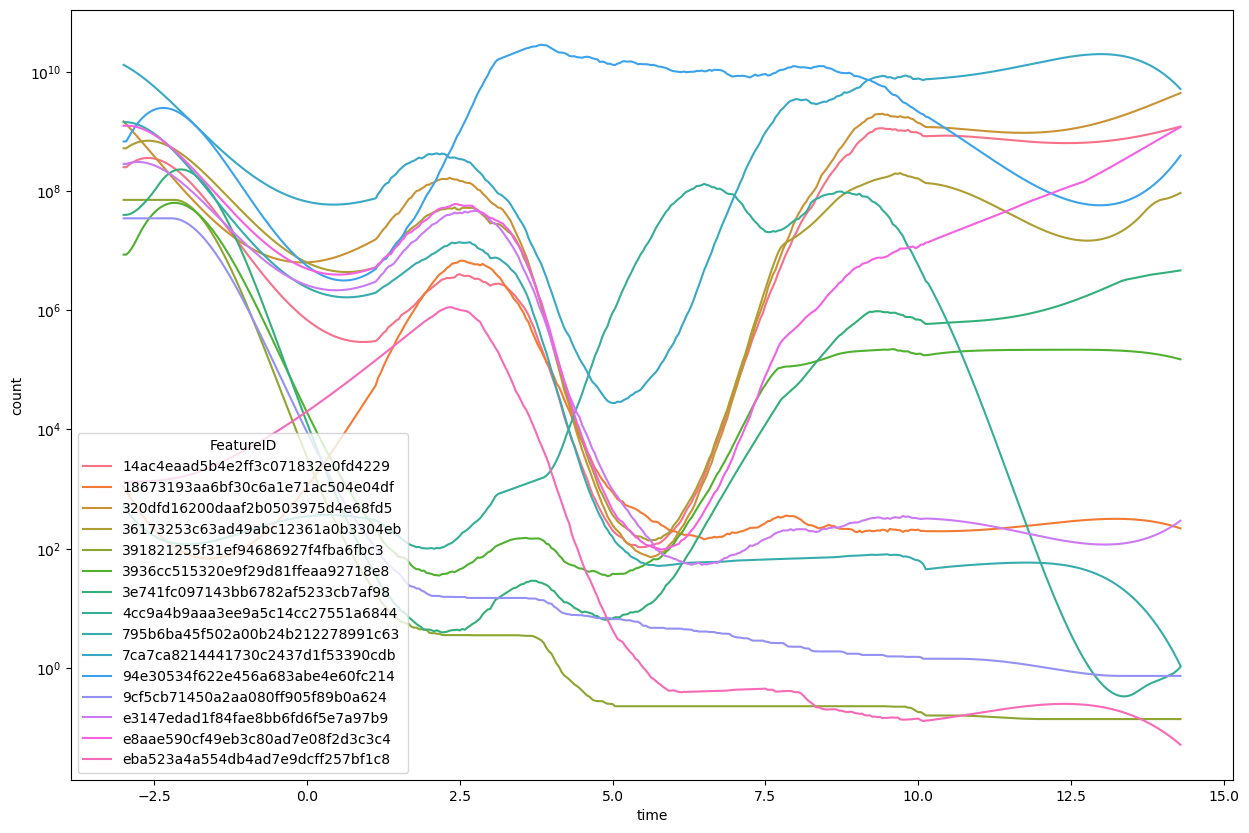

In [ ]:


fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=FBA_biomass_df_plot, x='time', y='count', hue = 'FeatureID')
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_abundances_over_time_test_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()

In [ ]:
FBA_biomass_df_plot

FBA_biomass_df_plot_unstack = FBA_biomass_df_plot.pivot(index='FeatureID', columns ='time')['count']
FBA_biomass_df_plot_unstack = pd.DataFrame(FBA_biomass_df_plot_unstack.sum(axis=0)).reset_index()
FBA_biomass_df_plot_unstack.columns = ['time', 'abun']
FBA_biomass_df_plot_unstack['time'] = pd.to_numeric(FBA_biomass_df_plot_unstack['time'])
FBA_biomass_df_plot_unstack['time'] = pd.to_numeric(FBA_biomass_df_plot_unstack['time'])

In [ ]:
### Need to plot metabolite trajectories too

met_pool_over_time_df = pd.DataFrame(met_pool_over_time)
met_pool_over_time_df = met_pool_over_time_df.fillna(0)
met_pool_over_time_df_melt= met_pool_over_time_df.melt(ignore_index=False)
met_pool_over_time_df_melt = met_pool_over_time_df_melt.reset_index()
met_pool_over_time_df_melt.columns = ['Time','Metabolite', 'Concentration']
met_pool_over_time_df_melt

Time     Metabolite  Concentration
0         0  EX_cpd35610_b   2.630000e-01
1         1  EX_cpd35610_b   2.593472e-01
2         2  EX_cpd35610_b   2.557452e-01
3         3  EX_cpd35610_b   2.521932e-01
4         4  EX_cpd35610_b   2.486905e-01
...     ...            ...            ...
59483   411  EX_cpd03279_b   1.223236e-07
59484   412  EX_cpd03279_b   1.206246e-07
59485   413  EX_cpd03279_b   1.188961e-07
59486   414  EX_cpd03279_b   1.171916e-07
59487   415  EX_cpd03279_b   1.155106e-07

[59488 rows x 3 columns]

In [ ]:
met_pool_over_time_df

EX_cpd35610_b  EX_cpd01242_b  EX_cpd01293_b  EX_cpd00035_b  \
0         0.263000       0.285000       0.305000      11.053000   
1         0.259347       0.327093       0.328056      10.977234   
2         0.255745       0.368601       0.350791      10.900769   
3         0.252193       0.409533       0.373210      10.825474   
4         0.248690       0.449896       0.395319      10.751360   
..             ...            ...            ...            ...   
411       0.000838       3.306026       1.959708       5.293331   
412       0.000827       3.306160       1.959781       5.268738   
413       0.000815       3.306293       1.959854       5.239056   
414       0.000804       3.306423       1.959925       5.203715   
415       0.000793       3.306552       1.959996       5.163385   

     EX_cpd01055_b  EX_cpd00224_b  EX_cpd00132_b  EX_cpd00041_b  \
0         0.069000      15.784000       0.000000       0.243000   
1         0.074083      15.173524       0.006676       0.249748   
2         0.079096      14.586776       0.013253       0.236459   
3         0.084039      13.991900       0.019733       0.222049   
4         0.088914      13.393828       0.026113       0.206351   
..             ...            ...            ...            ...   
411       0.433833       0.003023       0.478742       0.010123   
412       0.433849       0.004873       0.478768       0.016076   
413       0.433865       0.005929       0.478795       0.018593   
414       0.433881       0.006465       0.478820       0.020356   
415       0.433897       0.003023       0.478846       0.010123   

     EX_cpd00158_b  EX_cpd00526_b  ...  EX_cpd11584_b  EX_cpd00180_b  \
0         0.520000       0.895000  ...            0.0            0.0   
1         0.512778       0.882569  ...            0.0            0.0   
2         0.504343       0.870312  ...            0.0            0.0   
3         0.496343       0.858224  ...            0.0            0.0   
4         0.488780       0.846304  ...            0.0            0.0   
..             ...            ...  ...            ...            ...   
411       0.000000       0.002853  ...            0.0            0.0   
412       0.000000       0.002814  ...            0.0            0.0   
413       0.000000       0.002775  ...            0.0            0.0   
414       0.000000       0.002736  ...            0.0            0.0   
415       0.000000       0.002698  ...            0.0            0.0   

     EX_cpd00367_b  EX_cpd11580_b  EX_cpd11588_b  EX_cpd15603_b  \
0     0.000000e+00            0.0            0.0            0.0   
1     0.000000e+00            0.0            0.0            0.0   
2     0.000000e+00            0.0            0.0            0.0   
3     0.000000e+00            0.0            0.0            0.0   
4     0.000000e+00            0.0            0.0            0.0   
..             ...            ...            ...            ...   
411   8.370279e-12            0.0            0.0            0.0   
412   8.254025e-12            0.0            0.0            0.0   
413   8.139386e-12            0.0            0.0            0.0   
414   8.026339e-12            0.0            0.0            0.0   
415   7.914862e-12            0.0            0.0            0.0   

     EX_cpd00264_b  EX_cpd00215_b  EX_cpd00355_b  EX_cpd03279_b  
0              0.0   0.000000e+00       0.000000   0.000000e+00  
1              0.0   0.000000e+00       0.000000   0.000000e+00  
2              0.0   0.000000e+00       0.000000   0.000000e+00  
3              0.0   0.000000e+00       0.000000   0.000000e+00  
4              0.0   0.000000e+00       0.000000   0.000000e+00  
..             ...            ...            ...            ...  
411            0.0   2.270553e-13       0.001882   1.223236e-07  
412            0.0   2.221407e-13       0.001813   1.206246e-07  
413            0.0   2.172680e-13       0.001644   1.188961e-07  
414            0.0   2.124250e-13       0.001566   1.171916e-07  

In [ ]:
met_pool_over_time_df_melt[met_pool_over_time_df_melt['Concentration'] < 0]

Empty DataFrame
Columns: [Time, Metabolite, Concentration]
Index: []

In [ ]:
met_pool_over_time_df_melt[met_pool_over_time_df_melt['Metabolite'] == 'EX_adn(e)']

Empty DataFrame
Columns: [Time, Metabolite, Concentration]
Index: []

In [ ]:
total_abun_MDSINE = pd.DataFrame(bi_hourly_resolution_latent_traj.sum(axis=0)).reset_index()
total_abun_MDSINE.columns = ['time', 'abun']
total_abun_MDSINE['time'] = pd.to_numeric(total_abun_MDSINE['time'])
total_abun_MDSINE.max()

time    1.400000e+01
abun    9.220114e+10
dtype: float64

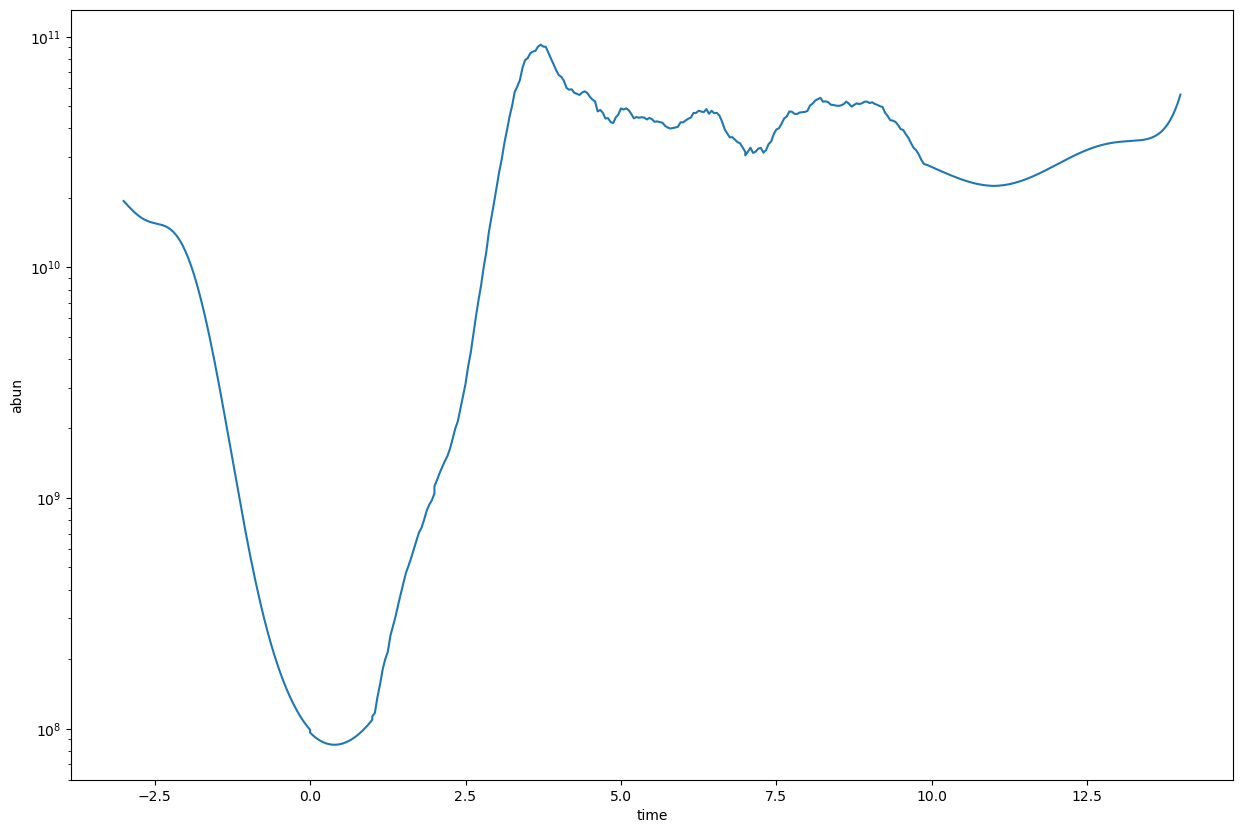

In [ ]:
fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=total_abun_MDSINE, x='time', y='abun')
plt.yscale('log')

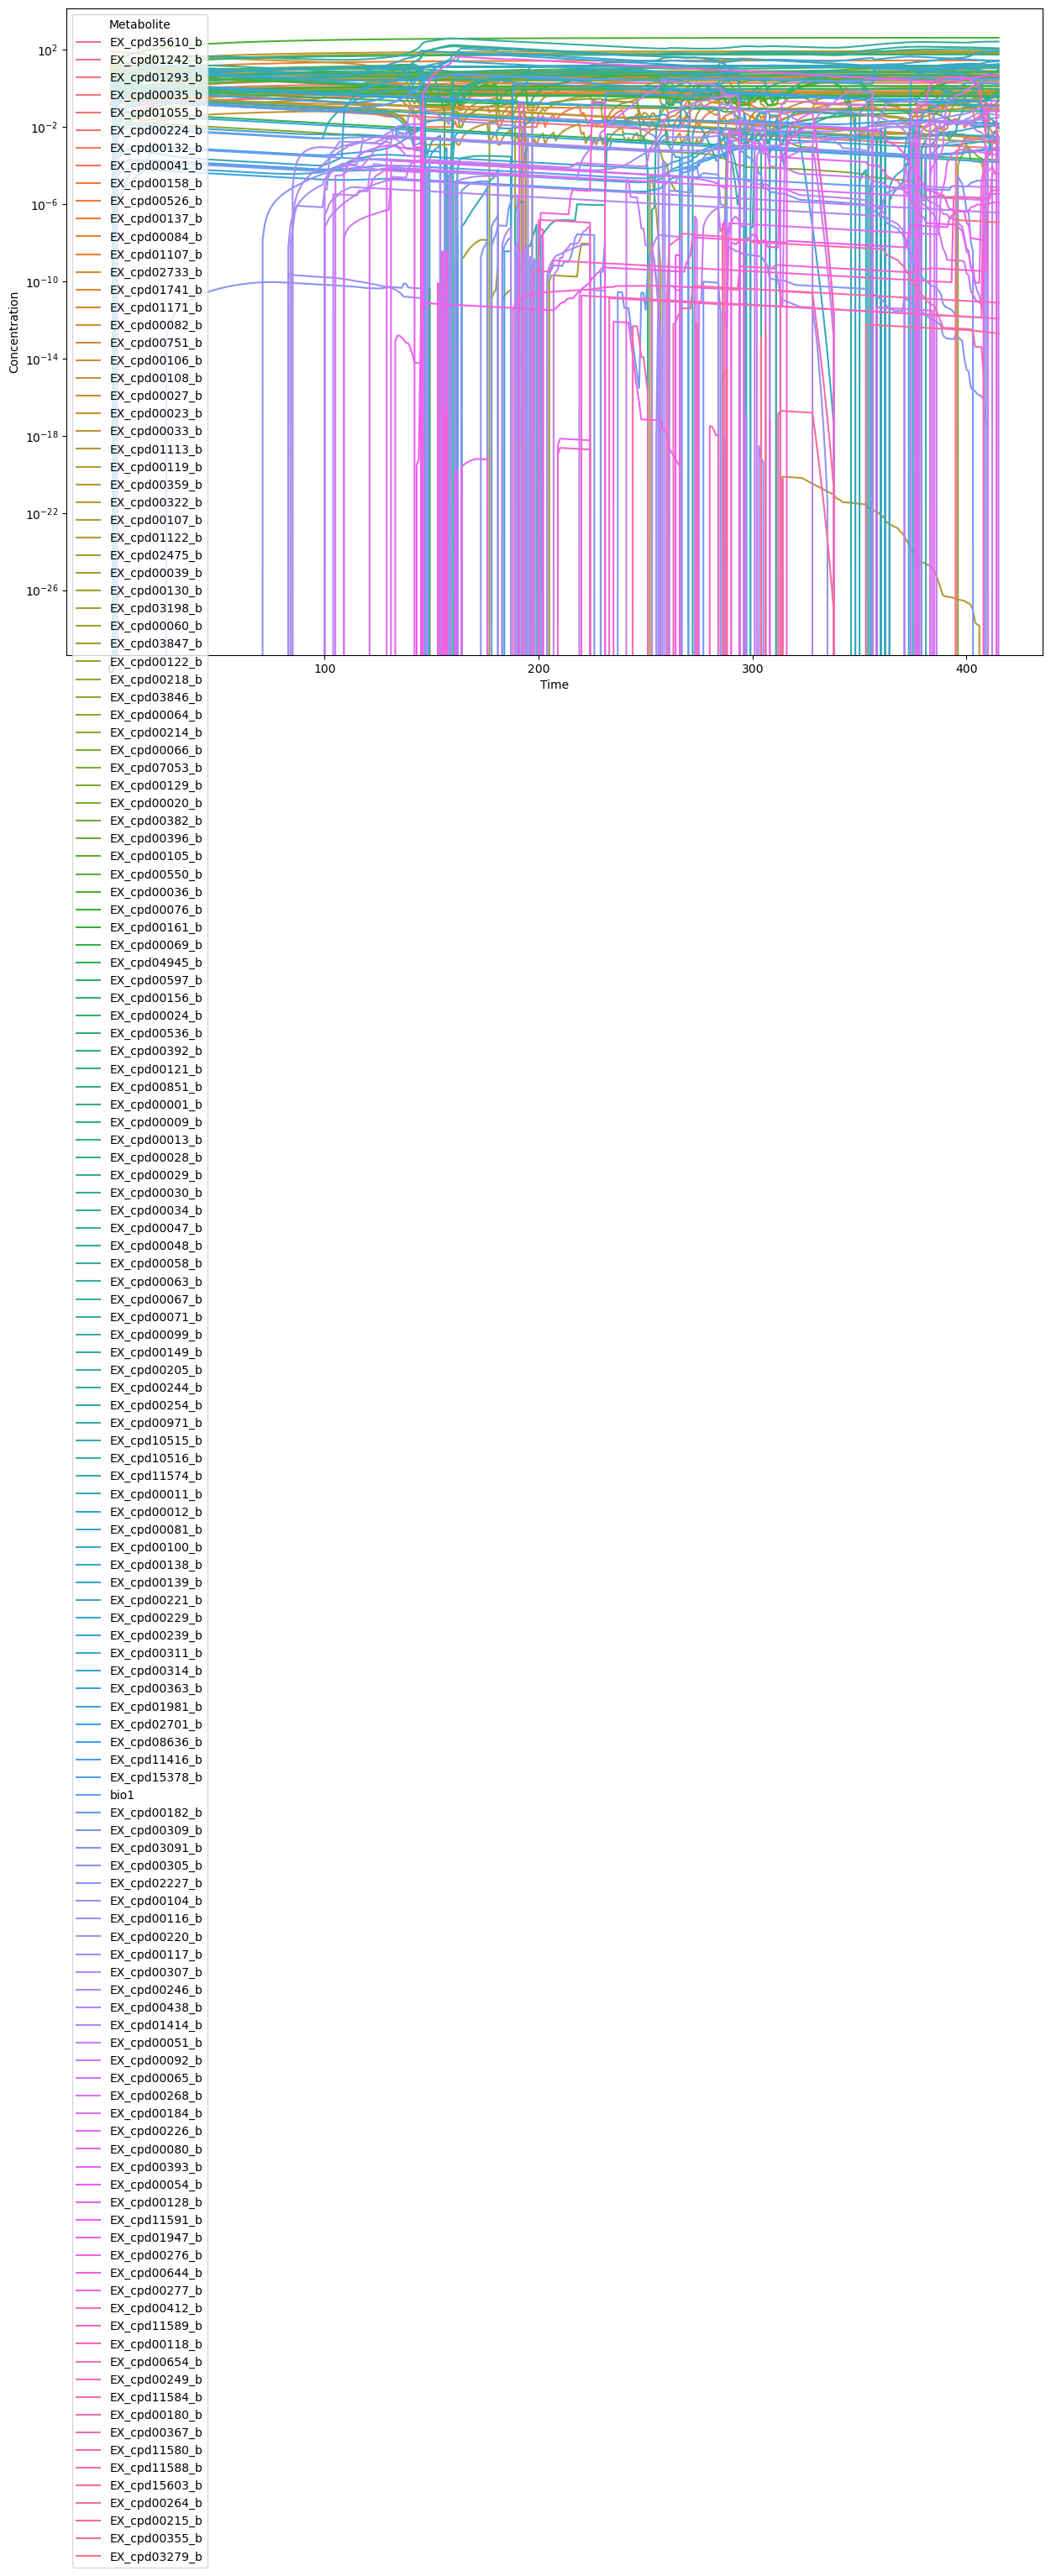

In [ ]:
output_folder = 'filtering_hourly_resolution'

#plot_dir_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_' + output_folder + '/test_' + str(test_num)

plot_dir = Path(plot_dir_path)
os.makedirs(plot_dir, exist_ok=True)

fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=met_pool_over_time_df_melt, x='Time', y='Concentration', hue = 'Metabolite')
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_metabolites_over_time_test_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()


                                  HF1152  HF1116  HF1181  HF1205  HF1253  \
FeatureID                                                                  
14ac4eaad5b4e2ff3c071832e0fd4229      27     205      26      22       0   
18673193aa6bf30c6a1e71ac504e04df       0       0       0      10       0   
320dfd16200daaf2b0503975d4e68fd5    1435     232     531     375       0   
36173253c63ad49abc12361a0b3304eb     258     813     261     205       0   
391821255f31ef94686927f4fba6fbc3       0     862       0       0       0   
3936cc515320e9f29d81ffeaa92718e8       0      48       0       0       0   
3e741fc097143bb6782af5233cb7af98       0    1098       0       0       0   
4cc9a4b9aaa3ee9a5c14cc27551a6844       0       0       0       0       0   
795b6ba45f502a00b24b212278991c63     152     405     110     108       0   
7ca7ca8214441730c2437d1f53390cdb    1686    5788    1939    1413       0   
94e30534f622e456a683abe4e60fc214     180    2975     285     184   63472   
9cf5cb71450a

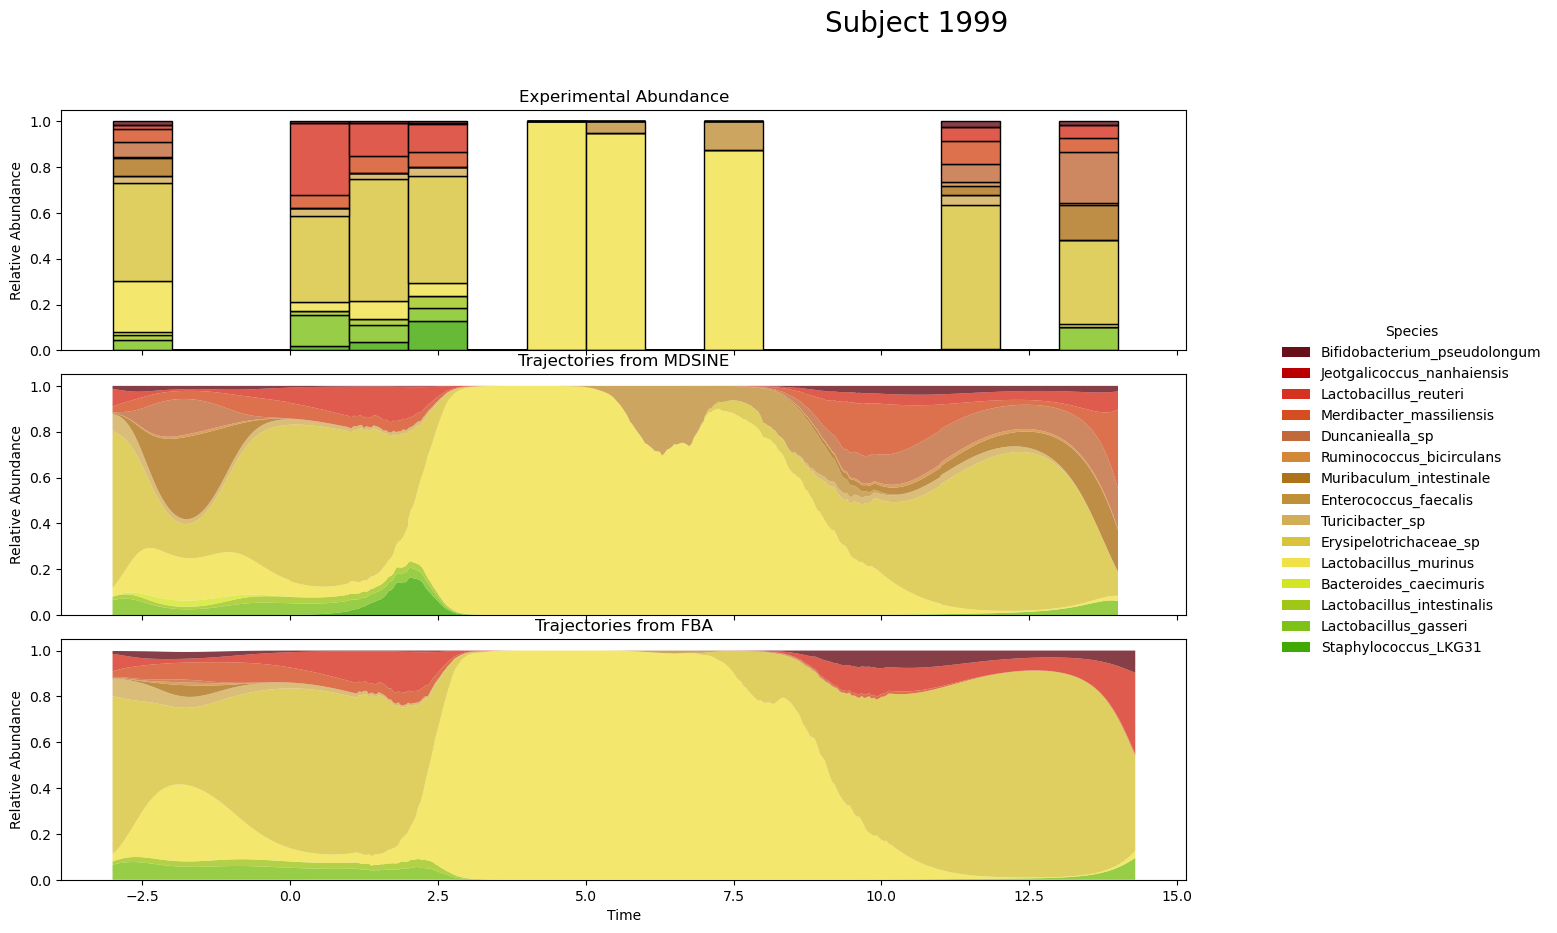

In [ ]:
### Stacked plots 

## Directory to save plots to 


output_folder = 'filtering_hourly_resolution'

#plot_dir_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/MDSINE_vs_Exp_plots_' + output_folder + '/test_' + str(test_num)

plot_dir = Path(plot_dir_path)
os.makedirs(plot_dir, exist_ok=True)

samps_for_sub ={}


temp = metadata[metadata['subject'] == subject_to_plot]
testing = counts.filter(temp.index.tolist(), axis=1)
print(testing)
testing = testing.loc[~(testing==0).all(axis=1)]
qpcr_measurements = qpcr.reindex(testing.columns)
qpcr_measurements = qpcr_measurements['measurement1'].to_list()
testing_ra = testing.reindex(index_to_filter_by)
testing_ra = testing/testing.sum(axis=0)
testing_abs_abun = testing_ra*qpcr_measurements
time_dict = dict(zip(temp.index, temp['time'].tolist()))
testing_melt_ra = testing_ra.melt(ignore_index=False)
testing_melt_ra.columns = ['sample', 'count']
testing_melt_ra['time'] = testing_melt_ra['sample'].map(time_dict)
#print(testing_melt_ra.head())
testing_melt_abs_abun = testing_abs_abun.melt(ignore_index=False)
testing_melt_abs_abun.columns = ['sample', 'count']
testing_melt_abs_abun['time'] = testing_melt_abs_abun['sample'].map(time_dict)

# load in MDSINE output for each subject 
output_path = '/Users/haydengallo/UMass_Dropbox/Dropbox (UMass Medical School)/Bucci_Lab/glv_FBA/gLV_FBA_test_Kennedy_et_al_2025/processed_data_filtered_RC_all_cohorts_corrected_abs_abun/' + output_folder + '/Subject_' + str(subject_to_plot) + '/mean_smoothed.tsv'
MDSINE_output = pd.read_csv(output_path, delimiter='\t', index_col=0)


MDSINE_output = MDSINE_output.reindex(index_to_filter_by)

MDSINE_output = MDSINE_output/MDSINE_output.sum(axis=0)
MDSINE_output = MDSINE_output.melt(ignore_index=False)
MDSINE_output = MDSINE_output.reset_index()
MDSINE_output.columns = ['FeatureID','time', 'count']


###################
### Second plot ###
###################

fig, (ax_top, ax_middle, ax_bottom) = plt.subplots(
3, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]}
)

# Ensure time is numeric
MDSINE_output['time'] = pd.to_numeric(MDSINE_output['time'])
testing_melt_ra['time'] = pd.to_numeric(testing_melt_ra['time'])
FBA_biomass_df['time'] = pd.to_numeric(FBA_biomass_df['time'])

# Define stacking order
feature_order = MDSINE_output['FeatureID'].value_counts().index.tolist()
reversed_order = feature_order[::-1]  # For stackplot

# Assign consistent colors


twentysiz = [
    "#690f19", "#b80000", "#d63220", "#d64e20", "#c1693a",  # reds/oranges
    "#d38838", "#AE7219", "#C09038", "#d1ad57", "#d8c33a", "#f1e149",  # orange/yellows
    "#d2e626", "#a0c618", "#7dc119", "#40a903", "#0c9515",  # yellow/green
    "#1da05a", "#1da18d", "#1d91a1", "#1d6ea1", "#1d31a1",  # green/blue
    "#1a1a87", "#5b5bc9", "#8d8df1", "#8670cc", "#9870cc",  # blue/purple
    "#000000"  # black
]
#sns.set_style("dark")  # or "whitegrid", "dark", etc.
#sns.set_context("notebook")  # or "paper", "talk", "poster"
sns.set_palette(twentysiz)

#palette = sns.color_palette("Spectral", n_colors=len(feature_order))  # or use 'husl', 'Set2', etc.
color_map = dict(zip(feature_order, twentysiz))

# Pivot for stackplot in reversed stacking order
continuous_pivot_MDSINE = (
    MDSINE_output
    .pivot(index='time', columns='FeatureID', values='count')
    .fillna(0)
)[reversed_order]

# Pivot for stackplot in reversed stacking order
continuous_pivot_FBA = (
    FBA_biomass_df
    .pivot(index='time', columns='FeatureID', values='count')
    .fillna(0)
)[reversed_order]



# Set categorical order for histogram
testing_melt_ra['FeatureID'] = pd.Categorical(testing_melt_ra.reset_index()['FeatureID'], categories=feature_order, ordered=True)

# Top: histogram
sns.histplot(
    data=testing_melt_ra,
    x='time',
    weights='count',
    hue='FeatureID',
    multiple='stack',
    ax=ax_top,
    alpha=0.8,
    binwidth=1,
    palette=color_map
)
ax_top.legend_.remove()
ax_top.set_ylabel('Relative Abundance')
ax_top.set_title('Experimental Abundance')
#ax_top.legend(title='FeatureID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Middle: stackplot using reversed order and matching colors
ax_middle.stackplot(
    continuous_pivot_MDSINE.index,
    *[continuous_pivot_MDSINE[col] for col in continuous_pivot_MDSINE.columns],
    alpha=0.8,
    colors=[color_map[feat] for feat in reversed_order],
    labels=reversed_order
)
ax_middle.set_ylabel('Relative Abundance')
#ax_middle.set_xlabel('Time')
ax_middle.set_title('Trajectories from MDSINE')

# Bottom: stackplot using FBA output 

# Bottom: stackplot using reversed order and matching colors
ax_bottom.stackplot(
    continuous_pivot_FBA.index,
    *[continuous_pivot_FBA[col] for col in continuous_pivot_FBA.columns],
    alpha=0.8,
    colors=[color_map[feat] for feat in reversed_order],
    labels=reversed_order
)
ax_bottom.set_ylabel('Relative Abundance')
ax_bottom.set_xlabel('Time')
ax_bottom.set_title('Trajectories from FBA')



# Tidy layout
ax_top.tick_params(labelbottom=False)
plt.subplots_adjust(hspace=0.1, right=0.75)


# Create custom legend handles using your color map
legend_elements = [
    Patch(facecolor=color_map[feat], label=ASV_string_to_species_names_dict[feat])
    for feat in feature_order
]

# Add custom legend to the *figure* (not either axis), outside plot
fig.legend(
    handles=legend_elements,
    title='Species',
    loc='center left',
    bbox_to_anchor=(.8, 0.5),  # Push legend just outside right edge
    borderaxespad=0,
    frameon=False,
    ncol=1
)
# Adjust spacing to make room for the legend
plt.subplots_adjust(hspace=0.1, right=1)  # Shrink plot width
overall_title = 'Subject ' + str(subject_to_plot)
plt.suptitle(overall_title, x=0.6, fontsize = 20)
plt.subplots_adjust(right=0.75)
second_plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_stacked_hist_line_plots_FBA_' + str(test_num) + '.pdf'
plt.savefig(second_plot_file_name, bbox_inches="tight")
plt.show()




In [ ]:
testing_melt_abs_abun_unstack = testing_melt_abs_abun.reset_index().pivot(index='FeatureID', columns ='time')['count']
testing_melt_abs_abun_unstack = pd.DataFrame(testing_melt_abs_abun_unstack.sum(axis=0)).reset_index()
testing_melt_abs_abun_unstack.columns = ['time', 'abun']
testing_melt_abs_abun_unstack['time'] = pd.to_numeric(testing_melt_abs_abun_unstack['time'])
testing_melt_abs_abun_unstack

time          abun
0  -3.0  8.858108e+09
1   0.0  7.349007e+05
2   1.0  4.310441e+05
3   2.0  1.438017e+09
4   4.0  4.944492e+10
5   5.0  2.867479e+10
6   7.0  3.360148e+10
7  11.0  1.637381e+10
8  14.0  2.486635e+10

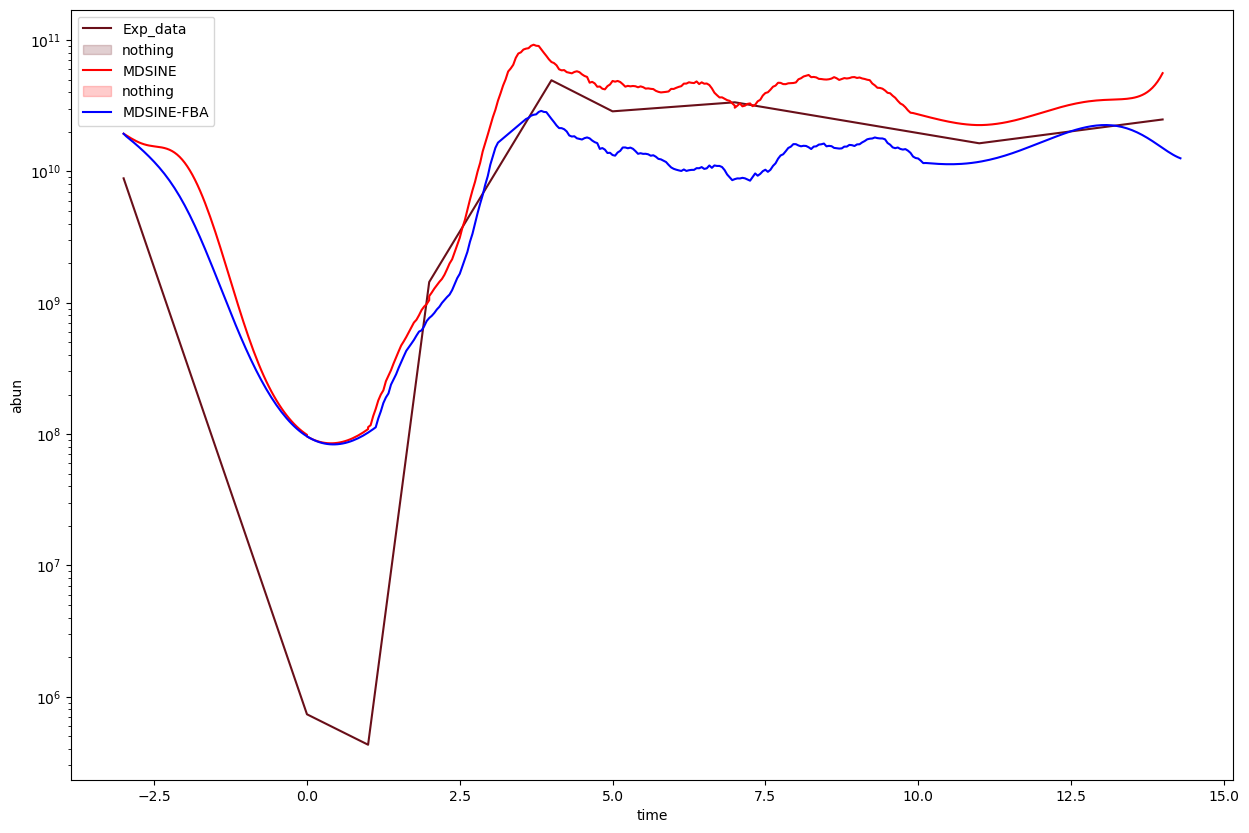

In [ ]:
fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=testing_melt_abs_abun_unstack, x='time', y='abun')
sns.lineplot(data=total_abun_MDSINE, x='time', y='abun', color = 'red')
sns.lineplot(data=FBA_biomass_df_plot_unstack, x='time', y='abun', color = 'blue')
plt.legend(['Exp_data', 'nothing', 'MDSINE', 'nothing', 'MDSINE-FBA'])
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_comparison_abs_abun_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")

In [ ]:
### Here plot the metabolomics data 
metabolomics_metadata_sub_1948 = metabolomics_metadata_raw[metabolomics_metadata_raw['Mouse'] == float(subject_to_predict)]
metabolomics_metadata_sub_1948

met_days_1948_dict = dict(zip(metabolomics_metadata_sub_1948.index.tolist(),metabolomics_metadata_sub_1948['Rec_day_adj'].tolist() ))
met_days_1948_dict

metabolomics_metadata_sub_2000 = metabolomics_metadata_raw[metabolomics_metadata_raw['Mouse'] == 2000.0]
metabolomics_metadata_sub_2000

met_days_2000_dict = dict(zip(metabolomics_metadata_sub_2000.index.tolist(),metabolomics_metadata_sub_2000['Rec_day_adj'].tolist() ))
met_days_2000_dict

{'HF2772': 14,
 'HF1115': -3,
 'HF1151': 0,
 'HF1228': 3,
 'HF1275': 5,
 'HF1299': 7,
 'HF1349': 11}

In [ ]:
### Filter the metabolomics data by the correct samples

metabolomics_data_sub_1948 = metabolomics_data[metabolomics_data['SampleName'].isin(met_days_1948_dict.keys())]
metabolomics_data_sub_1948 = metabolomics_data_sub_1948.set_index('SampleName')
metabolomics_data_sub_1948_ra = metabolomics_data_sub_1948.T/metabolomics_data_sub_1948.T.sum(axis=0)
metabolomics_data_sub_1948_ra.columns = np.sort(list(met_days_1948_dict.values()))

#change_met_ids = bigg_to_agora_exchange_ids(metabolomics_data_sub_1948_ra.index.tolist())
change_met_ids = []
for i in metabolomics_data_sub_1948_ra.index.tolist():
    change_met_ids.append('EX_' + bigg_to_modelseed[i] + '_b')
metabolomics_data_sub_1948_ra.index = change_met_ids
#metabolomics_data_sub_1948_ra.head()

metabolomics_data_sub_2000 = metabolomics_data[metabolomics_data['SampleName'].isin(met_days_2000_dict.keys())]
metabolomics_data_sub_2000 = metabolomics_data_sub_2000.set_index('SampleName')
metabolomics_data_sub_2000_ra = metabolomics_data_sub_2000.T/metabolomics_data_sub_2000.T.sum(axis=0)
### columns were placed incorrectly it seems so need to match 
change_met_ids = []
for i in metabolomics_data_sub_2000_ra.index.tolist():
    change_met_ids.append('EX_' + bigg_to_modelseed[i] + '_b')
metabolomics_data_sub_2000_ra.index = change_met_ids
metabolomics_data_sub_2000_ra.columns = np.sort(list(met_days_2000_dict.values()))

change_met_ids = metabolomics_data_sub_2000_ra.index.tolist()


bigg_to_modelseed
#metabolomics_data_sub_2000_ra.index = change_met_ids

{'h2o': 'cpd00001',
 'oh1': 'cpd00001',
 'atp': 'cpd00002',
 'nad': 'cpd00003',
 'nadh': 'cpd00004',
 'nadph': 'cpd00005',
 'nadp': 'cpd00006',
 'o2': 'cpd00007',
 'adp': 'cpd00008',
 'pi': 'cpd00009',
 'coa': 'cpd00010',
 'co2': 'cpd00011',
 'ppi': 'cpd00012',
 'nh3': 'cpd00013',
 'nh4': 'cpd00013',
 'udp': 'cpd00014',
 'fad': 'cpd00015',
 'pydx5p': 'cpd00016',
 'amet': 'cpd00017',
 'amp': 'cpd00018',
 'ahcys': 'cpd00019',
 'pyr': 'cpd00020',
 'accoa': 'cpd00022',
 'glu__L': 'cpd00023',
 'akg': 'cpd00024',
 'h2o2': 'cpd00025',
 'udpg': 'cpd00026',
 'glc__D': 'cpd00027',
 'pheme': 'cpd00028',
 'ac': 'cpd00029',
 'mn2': 'cpd00030',
 'gdp': 'cpd00031',
 'oaa': 'cpd00032',
 'gly': 'cpd00033',
 'zn2': 'cpd00034',
 'ala__L': 'cpd00035',
 'succ': 'cpd00036',
 'uacgam': 'cpd00037',
 'gtp': 'cpd00038',
 'lys__L': 'cpd00039',
 'glx': 'cpd00040',
 'asp__L': 'cpd00041',
 'gthrd': 'cpd00042',
 'udpgal': 'cpd00043',
 'paps': 'cpd00044',
 'pap': 'cpd00045',
 'cmp': 'cpd00046',
 'for': 'cpd00047',
 '

In [ ]:
metabolomics_data_sub_2000_ra

-3         0         3         5         7         11  \
EX_cpd35610_b  0.001108  0.000109  0.000000  0.000000  0.000000  0.001992   
EX_cpd01242_b  0.001200  0.000255  0.004831  0.001997  0.002819  0.000923   
EX_cpd01293_b  0.001285  0.004200  0.016028  0.029803  0.028420  0.001434   
EX_cpd00035_b  0.046558  0.006271  0.034269  0.043679  0.048582  0.033155   
EX_cpd01055_b  0.000291  0.000962  0.004169  0.003182  0.002255  0.000231   
EX_cpd00224_b  0.066486  0.049681  0.008473  0.020081  0.029647  0.072922   
EX_cpd00132_b  0.000000  0.000816  0.003145  0.008821  0.011209  0.000000   
EX_cpd00041_b  0.001024  0.006376  0.048476  0.080517  0.073653  0.006959   
EX_cpd00158_b  0.002190  0.000000  0.004365  0.003465  0.003913  0.005047   
EX_cpd00526_b  0.003770  0.001046  0.000858  0.001220  0.001128  0.001324   
EX_cpd00137_b  0.000417  0.000356  0.001505  0.004225  0.000431  0.000137   
EX_cpd00084_b  0.014145  0.016802  0.055791  0.075108  0.077881  0.010492   
EX_cpd01107_b  0.000754  0.000222  0.000632  0.001043  0.001094  0.000558   
EX_cpd02733_b  0.080399  0.002272  0.000873  0.000000  0.000000  0.309843   
EX_cpd01741_b  0.000708  0.000000  0.000000  0.000000  0.000000  0.000414   
EX_cpd01171_b  0.000000  0.000000  0.000000  0.009156  0.012834  0.000000   
EX_cpd00082_b  0.003812  0.013484  0.072541  0.036043  0.004228  0.003480   
EX_cpd00751_b  0.001588  0.001887  0.001385  0.003146  0.002504  0.002029   
EX_cpd00106_b  0.002338  0.002339  0.006321  0.010429  0.012253  0.002808   
EX_cpd00108_b  0.062787  0.004573  0.073775  0.011543  0.012353  0.028773   
EX_cpd00027_b  0.360445  0.031809  0.050041  0.011578  0.011656  0.256168   
EX_cpd00023_b  0.000670  0.001807  0.010219  0.013151  0.014127  0.000899   
EX_cpd00033_b  0.002157  0.001067  0.003763  0.005197  0.006085  0.002163   
EX_cpd01113_b  0.001222  0.000372  0.001114  0.002422  0.001824  0.000772   
EX_cpd00119_b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
EX_cpd00359_b  0.003555  0.000000  0.000000  0.000000  0.000000  0.003861   
EX_cpd00322_b  0.011525  0.010129  0.036963  0.084529  0.095921  0.015723   
EX_cpd00107_b  0.031015  0.017710  0.078907  0.162872  0.176140  0.030909   
EX_cpd01122_b  0.054237  0.004937  0.023463  0.033798  0.042182  0.033844   
EX_cpd02475_b  0.002110  0.000096  0.000000  0.000000  0.000000  0.003637   
EX_cpd00039_b  0.000000  0.000782  0.002483  0.008750  0.012867  0.000000   
EX_cpd00130_b  0.001639  0.000075  0.000211  0.000301  0.000365  0.001280   
EX_cpd03198_b  0.000000  0.032072  0.000000  0.000000  0.000000  0.000000   
EX_cpd00060_b  0.001862  0.001293  0.005418  0.012727  0.010943  0.002567   
EX_cpd03847_b  0.006836  0.001192  0.004545  0.006470  0.006019  0.003580   
EX_cpd00122_b  0.004916  0.005033  0.000000  0.000000  0.000000  0.006752   
EX_cpd00218_b  0.014233  0.000360  0.004786  0.005780  0.007196  0.010676   
EX_cpd03846_b  0.003172  0.000971  0.002829  0.004119  0.004311  0.001992   
EX_cpd00064_b  0.000084  0.000310  0.000933  0.005056  0.006848  0.000231   
EX_cpd00214_b  0.006638  0.002326  0.008353  0.012285  0.010827  0.004773   
EX_cpd00066_b  0.003521  0.002318  0.008895  0.024535  0.022815  0.002627   
EX_cpd07053_b  0.001748  0.000824  0.002122  0.003677  0.003532  0.001471   
EX_cpd00129_b  0.022687  0.013312  0.106690  0.051686  0.038402  0.011455   
EX_cpd00020_b  0.004587  0.000402  0.007390  0.019126  0.016598  0.001521   
EX_cpd00382_b  0.000000  0.704494  0.000000  0.000000  0.000000  0.000000   
EX_cpd00396_b  0.003901  0.001498  0.004109  0.003960  0.005936  0.001220   
EX_cpd00105_b  0.037278  0.008129  0.008985  0.008520  0.010877  0.050757   
EX_cpd00550_b  0.003538  0.006464  0.029107  0.002687  0.002636  0.003339   
EX_cpd00036_b  0.032476  0.000130  0.000452  0.000884  0.000746  0.001982   
EX_cpd00076_b  0.002780  0.004029  0.017067  0.014442  0.009070  0.001006   
EX_cpd00161_b  0.001782  0.008372  0.030762  0.070724  0.061118  0.001945   
EX_cpd00069_b  0

In [ ]:
met_pool_over_time_df_melt

Time     Metabolite  Concentration
0         0  EX_cpd35610_b   2.630000e-01
1         1  EX_cpd35610_b   2.593472e-01
2         2  EX_cpd35610_b   2.557452e-01
3         3  EX_cpd35610_b   2.521932e-01
4         4  EX_cpd35610_b   2.486905e-01
...     ...            ...            ...
59483   411  EX_cpd03279_b   1.223236e-07
59484   412  EX_cpd03279_b   1.206246e-07
59485   413  EX_cpd03279_b   1.188961e-07
59486   414  EX_cpd03279_b   1.171916e-07
59487   415  EX_cpd03279_b   1.155106e-07

[59488 rows x 3 columns]

In [ ]:
met_pool_over_time_df_melt_filt = met_pool_over_time_df_melt.set_index('Metabolite').loc[change_met_ids].reset_index()
met_pool_over_time_df_melt_filt.head()

Metabolite  Time  Concentration
0  EX_cpd35610_b     0       0.263000
1  EX_cpd35610_b     1       0.259347
2  EX_cpd35610_b     2       0.255745
3  EX_cpd35610_b     3       0.252193
4  EX_cpd35610_b     4       0.248690

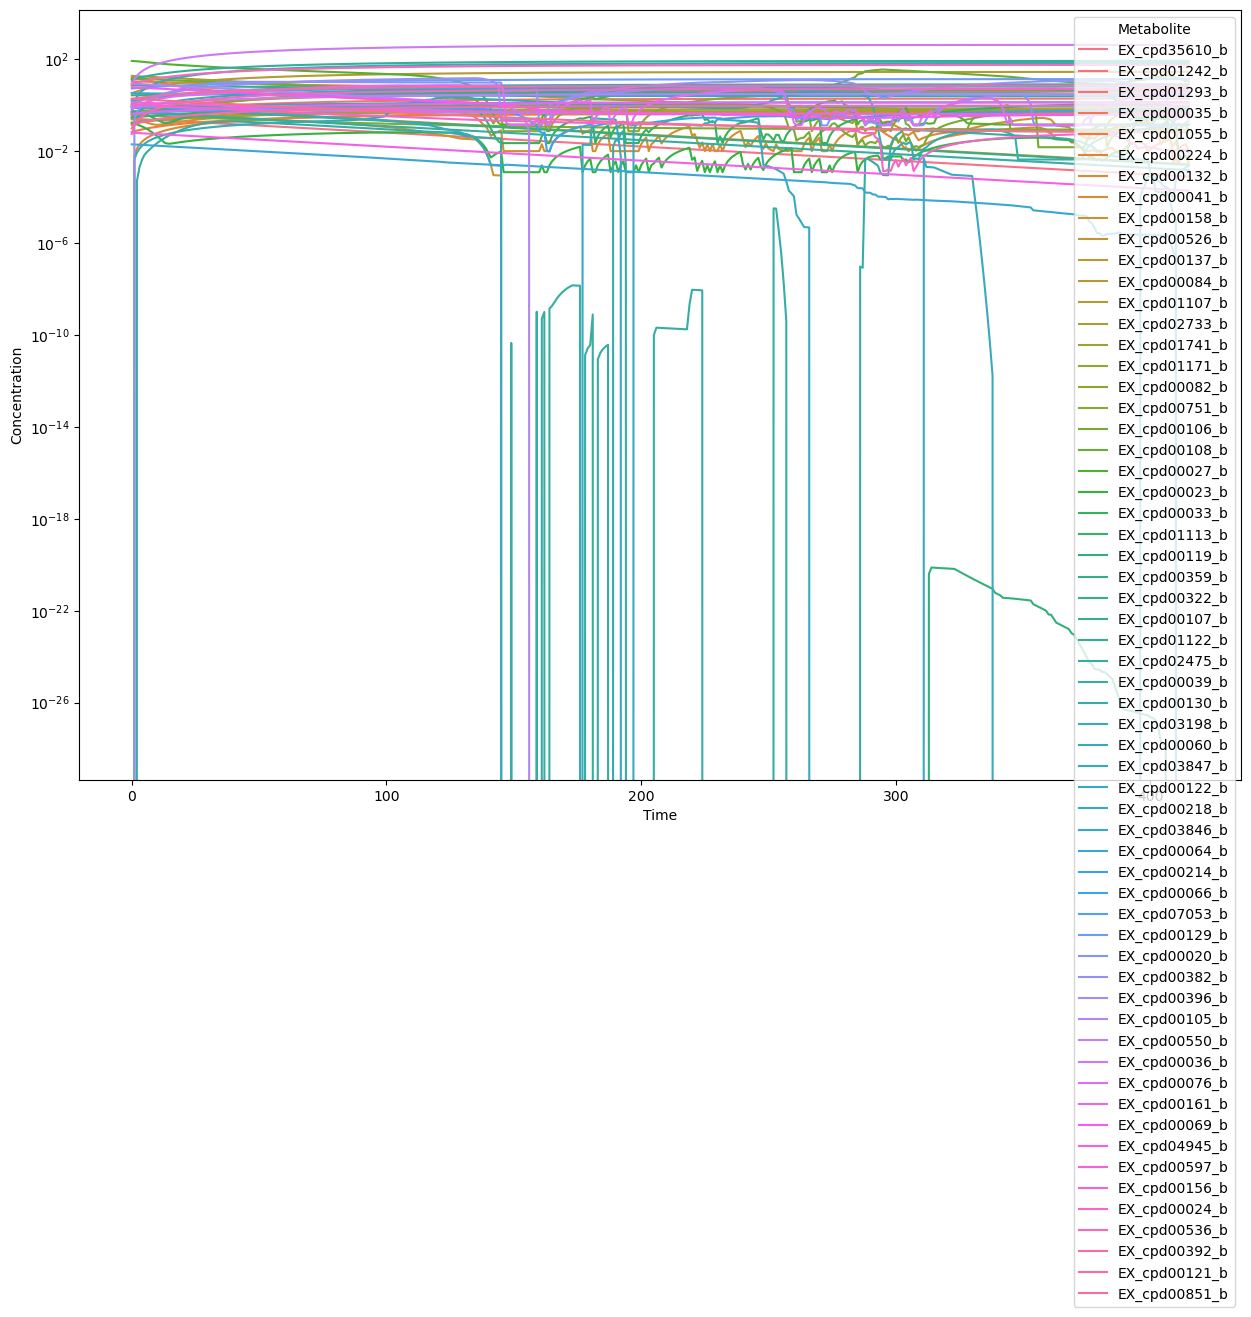

In [ ]:
fig, axs = plt.subplots(figsize= (15,10))
sns.lineplot(data=met_pool_over_time_df_melt_filt, x='Time', y='Concentration', hue = 'Metabolite')
plt.yscale('log')
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_metabolites_over_time_test_filt' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()


In [ ]:

metabolomics_data_sub_1948_ra_melt = metabolomics_data_sub_1948_ra.melt(ignore_index=False).reset_index()
metabolomics_data_sub_1948_ra_melt.columns = ['metabolites', 'time', 'concentration']
metabolomics_data_sub_1948_ra_melt.head()

metabolomics_data_sub_2000_ra_melt = metabolomics_data_sub_2000_ra.melt(ignore_index=False).reset_index()
metabolomics_data_sub_2000_ra_melt.columns = ['metabolites', 'time', 'concentration']
metabolomics_data_sub_2000_ra_melt.head()

metabolites  time  concentration
0  EX_cpd35610_b    -3       0.001108
1  EX_cpd01242_b    -3       0.001200
2  EX_cpd01293_b    -3       0.001285
3  EX_cpd00035_b    -3       0.046558
4  EX_cpd01055_b    -3       0.000291

In [ ]:
cmpd_names_adjust = []
for i in cmpd_names:
    cmpd_names_adjust.append('EX_' + i + '_b')

In [ ]:
### Prepare the simulation metabolomic data 

#met_pool_over_time_df_filt = met_pool_over_time_df.T.loc[agora_ex_ids_list]
met_pool_over_time_df_filt = met_pool_over_time_df.T.loc[cmpd_names_adjust]
met_pool_over_time_df_filt = met_pool_over_time_df_filt.T.reset_index()
met_pool_over_time_df_filt['index'] = (met_pool_over_time_df_filt['index']/time_scaler)-3
met_pool_over_time_df_filt = met_pool_over_time_df_filt.set_index('index').T
met_pool_over_time_df_filt_ra = met_pool_over_time_df_filt/met_pool_over_time_df_filt.sum(axis=0)
met_pool_over_time_df_filt_ra_melt = met_pool_over_time_df_filt_ra.melt(ignore_index=False).reset_index()
met_pool_over_time_df_filt_ra_melt.columns = ['metabolites', 'time', 'concentration']
met_pool_over_time_df_filt_ra_melt.head()
# use this to filter, agora_ex_ids_list

metabolites  time  concentration
0  EX_cpd35610_b  -3.0       0.001108
1  EX_cpd01242_b  -3.0       0.001200
2  EX_cpd01293_b  -3.0       0.001285
3  EX_cpd00035_b  -3.0       0.046558
4  EX_cpd01055_b  -3.0       0.000291

In [ ]:
met_pool_over_time_df_filt

index          -3.000000   -2.958333   -2.916667   -2.875000   -2.833333   \
EX_cpd35610_b       0.263    0.259347    0.255745    0.252193    0.248690   
EX_cpd01242_b       0.285    0.327093    0.368601    0.409533    0.449896   
EX_cpd01293_b       0.305    0.328056    0.350791    0.373210    0.395319   
EX_cpd00035_b      11.053   10.977234   10.900769   10.825474   10.751360   
EX_cpd01055_b       0.069    0.074083    0.079096    0.084039    0.088914   
EX_cpd00224_b      15.784   15.173524   14.586776   13.991900   13.393828   
EX_cpd00132_b       0.000    0.006676    0.013253    0.019733    0.026113   
EX_cpd00041_b       0.243    0.249748    0.236459    0.222049    0.206351   
EX_cpd00158_b       0.520    0.512778    0.504343    0.496343    0.488780   
EX_cpd00526_b       0.895    0.882569    0.870312    0.858224    0.846304   
EX_cpd00137_b       0.099    0.156506    0.212595    0.267667    0.321711   
EX_cpd00084_b       3.358    3.711897    4.046411    4.377423    4.705157   
EX_cpd01107_b       0.179    0.186097    0.193096    0.199997    0.206803   
EX_cpd02733_b      19.087   18.827736   18.572073   18.319961   18.071350   
EX_cpd01741_b       0.168    0.173583    0.179089    0.184518    0.189872   
EX_cpd01171_b       0.000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00082_b       0.905    0.967169    0.976032    0.981002    0.982641   
EX_cpd00751_b       0.377    0.372966    0.368987    0.365064    0.361196   
EX_cpd00106_b       0.555    0.562292    0.571163    0.579582    0.588356   
EX_cpd00108_b      14.906   14.728713   14.553887   14.381491   14.211488   
EX_cpd00027_b      85.571   84.528605   82.815878   80.968470   79.071744   
EX_cpd00023_b       0.159    0.158017    0.146303    0.133698    0.120258   
EX_cpd00033_b       0.512    0.527520    0.506166    0.480686    0.450608   
EX_cpd01113_b       0.290    0.298264    0.306413    0.314449    0.322373   
EX_cpd00119_b       0.000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00359_b       0.844    0.832278    0.820718    0.809319    0.798079   
EX_cpd00322_b       2.736    2.747042    2.756832    2.767351    2.777750   
EX_cpd00107_b       7.363    7.335255    7.302211    7.269897    7.237731   
EX_cpd01122_b      12.876   13.891333   14.892565   15.879890   16.853503   
EX_cpd02475_b       0.501    0.494042    0.487180    0.480414    0.473741   
EX_cpd00039_b       0.000    0.000000    0.000504    0.001991    0.004240   
EX_cpd00130_b       0.389    0.463181    0.536331    0.608465    0.679598   
EX_cpd03198_b       0.000    0.004375    0.008689    0.012944    0.017139   
EX_cpd00060_b       0.442    1.413335    2.365349    3.303049    4.227420   
EX_cpd03847_b       1.623    1.714452    1.804633    1.893562    1.981255   
EX_cpd00122_b       1.167    1.150792    1.106105    1.062604    1.021113   
EX_cpd00218_b       3.379    3.366583    3.354278    3.342195    3.330282   
EX_cpd03846_b       0.753    0.761172    0.769230    0.777177    0.785013   
EX_cpd00064_b       0.020    0.019722    0.019448    0.019178    0.018912   
EX_cpd00214_b       1.576    1.644810    1.712665    1.779577    1.845560   
EX_cpd00066_b       0.836    0.834042    0.829756    0.825032    0.820218   
EX_cpd07053_b       0.415    0.422569    0.430034    0.437394    0.444653   
EX_cpd00129_b       5.386    5.503851    5.619983    5.734427    5.847206   
EX_cpd00020_b       1.089    1.206170    1.374123    1.507284    1.646308   
EX_cpd00382_b       0.000    0.248333    0.493218    0.734701    0.972830   
EX_cpd00396_b       0.926    0.918764    0.911628    0.904592    0.897653   
EX_cpd00105_b       8.850    8.727083    8.576868    8.435741    8.303791   
EX_cpd00550_b       0.840    0.872292    0.904135    0.935536    0.966501   
EX_cpd00036_b       7.710   13.551037   19.315137   24.999234   30.604407   
EX_cpd00076_b       0.660    0.790482    0.917910    1.042337    1.163758   
EX_cpd00161_b       0.423    0.436170    0.448855    0.461353    0.473681

Text(0.5, 1.0, 'Experimental Abundance')

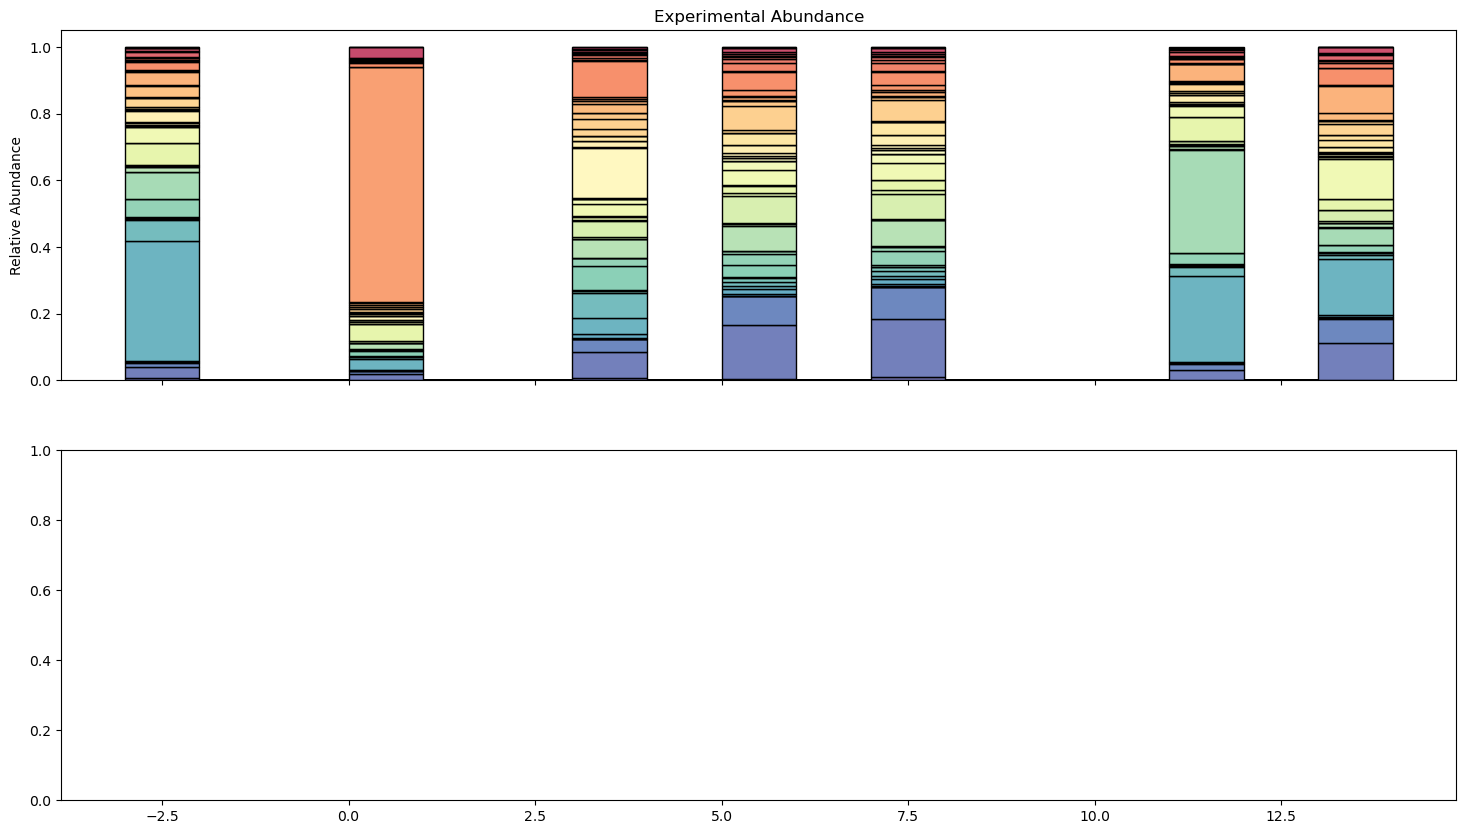

In [ ]:
fig, (ax_top, ax_bottom) = plt.subplots(
2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]}
)

# Define stacking order
feature_order = metabolomics_data_sub_2000_ra_melt['metabolites'].value_counts().index.tolist()
reversed_order = feature_order[::-1]  # For stackplot



palette = sns.color_palette("Spectral", n_colors=len(feature_order))  # or use 'husl', 'Set2', etc.
color_map = dict(zip(feature_order, palette))

# Pivot for stackplot in reversed stacking order
met_pool_over_time_df_filt_ra_pivot = (
    met_pool_over_time_df_filt_ra_melt
    .pivot(index='time', columns='metabolites', values='concentration')
    .fillna(0)
)[reversed_order]

# Set categorical order for histogram
metabolomics_data_sub_2000_ra_melt['metabolites'] = pd.Categorical(metabolomics_data_sub_2000_ra_melt.reset_index()['metabolites'], categories=feature_order, ordered=True)

# Top: histogram
sns.histplot(
    data=metabolomics_data_sub_2000_ra_melt,
    x='time',
    weights='concentration',
    hue='metabolites',
    multiple='stack',
    ax=ax_top,
    alpha=0.8,
    binwidth=1,
    palette=color_map
)
ax_top.legend_.remove()
ax_top.set_ylabel('Relative Abundance')
ax_top.set_title('Experimental Abundance')
#ax_top.legend(title='FeatureID', bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
met_pool_over_time_df_filt_ra_pivot.sum(axis=1)

time
-3.000000     1.0
-2.958333     1.0
-2.916667     1.0
-2.875000     1.0
-2.833333     1.0
             ... 
 14.125000    1.0
 14.166667    1.0
 14.208333    1.0
 14.250000    1.0
 14.291667    1.0
Length: 416, dtype: float64

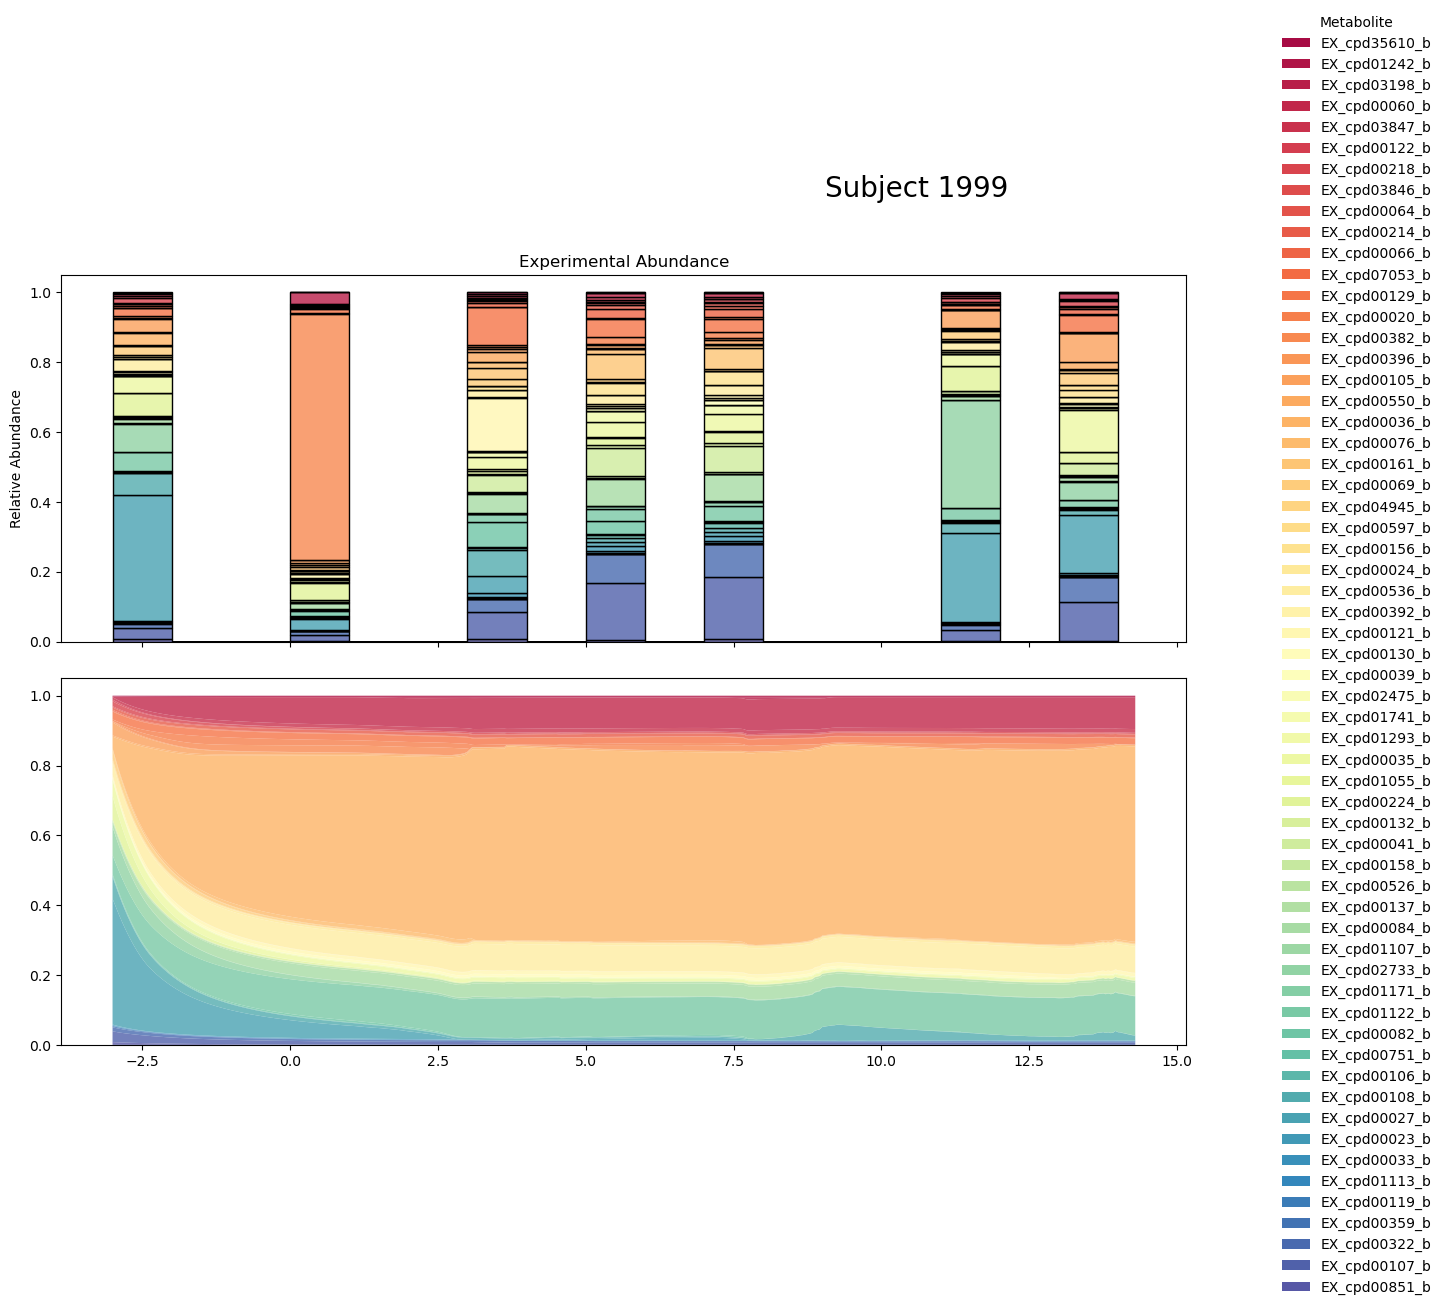

In [ ]:
fig, (ax_top, ax_bottom) = plt.subplots(
2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]}
)

# Define stacking order
feature_order = metabolomics_data_sub_1948_ra_melt['metabolites'].value_counts().index.tolist()
reversed_order = feature_order[::-1]  # For stackplot



palette = sns.color_palette("Spectral", n_colors=len(feature_order))  # or use 'husl', 'Set2', etc.
color_map = dict(zip(feature_order, palette))

# Pivot for stackplot in reversed stacking order
met_pool_over_time_df_filt_ra_pivot = (
    met_pool_over_time_df_filt_ra_melt
    .pivot(index='time', columns='metabolites', values='concentration')
    .fillna(0)
)[reversed_order]

# Set categorical order for histogram
metabolomics_data_sub_1948_ra_melt['metabolites'] = pd.Categorical(metabolomics_data_sub_1948_ra_melt.reset_index()['metabolites'], categories=feature_order, ordered=True)

# Top: histogram
sns.histplot(
    data=metabolomics_data_sub_1948_ra_melt,
    x='time',
    weights='concentration',
    hue='metabolites',
    multiple='stack',
    ax=ax_top,
    alpha=0.8,
    binwidth=1,
    palette=color_map
)
ax_top.legend_.remove()
ax_top.set_ylabel('Relative Abundance')
ax_top.set_title('Experimental Abundance')
#ax_top.legend(title='FeatureID', bbox_to_anchor=(1.05, 1), loc='upper left')

ax_bottom.stackplot(
    met_pool_over_time_df_filt_ra_pivot.index,
    *[met_pool_over_time_df_filt_ra_pivot[col] for col in met_pool_over_time_df_filt_ra_pivot.columns],
    alpha=0.8,
    colors=[color_map[feat] for feat in reversed_order],
    labels=reversed_order
)

# Create custom legend handles using your color map
legend_elements = [
    Patch(facecolor=color_map[feat], label=feat)
    for feat in feature_order
]

# Add custom legend to the *figure* (not either axis), outside plot
fig.legend(
    handles=legend_elements,
    title='Metabolite',
    loc='center left',
    bbox_to_anchor=(.8, 0.5),  # Push legend just outside right edge
    borderaxespad=0,
    frameon=False,
    ncol=1
)
# Adjust spacing to make room for the legend
plt.subplots_adjust(hspace=0.1, right=1)  # Shrink plot width
overall_title = 'Subject ' + str(subject_to_plot)
plt.suptitle(overall_title, x=0.6, fontsize = 20)
plt.subplots_adjust(right=0.75)
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_exp_vs_sim_over_time_test_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()

In [ ]:
met_days_1948_dict.values()

dict_values([14, -3, 0, 3, 5, 7, 11])

In [ ]:
met_pool_over_time_df_filt_ra

index          -3.000000   -2.958333   -2.916667   -2.875000   -2.833333   \
EX_cpd35610_b    0.001108    0.001058    0.001016    0.000977    0.000940   
EX_cpd01242_b    0.001200    0.001335    0.001464    0.001586    0.001701   
EX_cpd01293_b    0.001285    0.001339    0.001393    0.001445    0.001495   
EX_cpd00035_b    0.046558    0.044793    0.043293    0.041924    0.040653   
EX_cpd01055_b    0.000291    0.000302    0.000314    0.000325    0.000336   
EX_cpd00224_b    0.066486    0.061917    0.057932    0.054187    0.050644   
EX_cpd00132_b    0.000000    0.000027    0.000053    0.000076    0.000099   
EX_cpd00041_b    0.001024    0.001019    0.000939    0.000860    0.000780   
EX_cpd00158_b    0.002190    0.002092    0.002003    0.001922    0.001848   
EX_cpd00526_b    0.003770    0.003601    0.003456    0.003324    0.003200   
EX_cpd00137_b    0.000417    0.000639    0.000844    0.001037    0.001216   
EX_cpd00084_b    0.014145    0.015147    0.016070    0.016953    0.017791   
EX_cpd01107_b    0.000754    0.000759    0.000767    0.000775    0.000782   
EX_cpd02733_b    0.080399    0.076828    0.073760    0.070949    0.068331   
EX_cpd01741_b    0.000708    0.000708    0.000711    0.000715    0.000718   
EX_cpd01171_b    0.000000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00082_b    0.003812    0.003947    0.003876    0.003799    0.003716   
EX_cpd00751_b    0.001588    0.001522    0.001465    0.001414    0.001366   
EX_cpd00106_b    0.002338    0.002294    0.002268    0.002245    0.002225   
EX_cpd00108_b    0.062787    0.060102    0.057801    0.055696    0.053736   
EX_cpd00027_b    0.360445    0.344925    0.328906    0.313570    0.298984   
EX_cpd00023_b    0.000670    0.000645    0.000581    0.000518    0.000455   
EX_cpd00033_b    0.002157    0.002153    0.002010    0.001862    0.001704   
EX_cpd01113_b    0.001222    0.001217    0.001217    0.001218    0.001219   
EX_cpd00119_b    0.000000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00359_b    0.003555    0.003396    0.003260    0.003134    0.003018   
EX_cpd00322_b    0.011525    0.011209    0.010949    0.010717    0.010503   
EX_cpd00107_b    0.031015    0.029932    0.029001    0.028154    0.027367   
EX_cpd01122_b    0.054237    0.056685    0.059146    0.061499    0.063726   
EX_cpd02475_b    0.002110    0.002016    0.001935    0.001861    0.001791   
EX_cpd00039_b    0.000000    0.000000    0.000002    0.000008    0.000016   
EX_cpd00130_b    0.001639    0.001890    0.002130    0.002356    0.002570   
EX_cpd03198_b    0.000000    0.000018    0.000035    0.000050    0.000065   
EX_cpd00060_b    0.001862    0.005767    0.009394    0.012792    0.015985   
EX_cpd03847_b    0.006836    0.006996    0.007167    0.007333    0.007491   
EX_cpd00122_b    0.004916    0.004696    0.004393    0.004115    0.003861   
EX_cpd00218_b    0.014233    0.013738    0.013322    0.012943    0.012592   
EX_cpd03846_b    0.003172    0.003106    0.003055    0.003010    0.002968   
EX_cpd00064_b    0.000084    0.000080    0.000077    0.000074    0.000072   
EX_cpd00214_b    0.006638    0.006712    0.006802    0.006892    0.006978   
EX_cpd00066_b    0.003521    0.003403    0.003295    0.003195    0.003101   
EX_cpd07053_b    0.001748    0.001724    0.001708    0.001694    0.001681   
EX_cpd00129_b    0.022687    0.022459    0.022320    0.022208    0.022109   
EX_cpd00020_b    0.004587    0.004922    0.005457    0.005837    0.006225   
EX_cpd00382_b    0.000000    0.001013    0.001959    0.002845    0.003678   
EX_cpd00396_b    0.003901    0.003749    0.003621    0.003503    0.003394   
EX_cpd00105_b    0.037278    0.035611    0.034063    0.032669    0.031398   
EX_cpd00550_b    0.003538    0.003559    0.003591    0.003623    0.003655   
EX_cpd00036_b    0.032476    0.055296    0.076711    0.096816    0.115721   
EX_cpd00076_b    0.002780    0.003226    0.003646    0.004037    0.004400   
EX_cpd00161_b    0.001782    0.001780    0.001783    0.001787    0.001791

In [ ]:
metabolomics_data_sub_1948 = metabolomics_data_sub_1948.T

metabolomics_data_sub_1948.columns = np.sort(list(met_days_1948_dict.values()))
metabolomics_data_sub_1948


-3        0      3      5       7       11      14
12_Ketolithocholic acid   0.263    0.026  0.000  0.000   0.000   0.596   0.043
drib                      0.285    0.061  0.321  0.113   0.170   0.276   0.092
5oxpro                    0.305    1.004  1.065  1.686   1.714   0.429   0.983
ala__L                   11.053    1.499  2.277  2.471   2.930   9.919  16.571
all__D                    0.069    0.230  0.277  0.180   0.136   0.069   0.024
arab__L                  15.784   11.875  0.563  1.136   1.788  21.816   4.562
asn__L                    0.000    0.195  0.209  0.499   0.676   0.000   0.121
asp__L                    0.243    1.524  3.221  4.555   4.442   2.082   4.680
cellb                     0.520    0.000  0.290  0.196   0.236   1.510   0.444
cholate                   0.895    0.250  0.057  0.069   0.068   0.396   0.084
cit                       0.099    0.085  0.100  0.239   0.026   0.041   0.040
cys__L                    3.358    4.016  3.707  4.249   4.697   3.139   1.934
dca                       0.179    0.053  0.042  0.059   0.066   0.167   0.051
dchac                    19.087    0.543  0.058  0.000   0.000  92.696   7.257
ddca                      0.168    0.000  0.000  0.000   0.000   0.124   0.034
galt                      0.000    0.000  0.000  0.518   0.774   0.000   0.000
fru                       0.905    3.223  4.820  2.039   0.255   1.041   0.592
fuc__L                    0.377    0.451  0.092  0.178   0.151   0.607   0.094
fum                       0.555    0.559  0.420  0.590   0.739   0.840   0.472
gal                      14.906    1.093  4.902  0.653   0.745   8.608   2.045
glc__D                   85.571    7.603  3.325  0.655   0.703  76.638  23.174
glu__L                    0.159    0.432  0.679  0.744   0.852   0.269   0.956
gly                       0.512    0.255  0.250  0.294   0.367   0.647   0.339
hxa                       0.290    0.089  0.074  0.137   0.110   0.231   0.103
his__L                    0.000    0.000  0.000  0.000   0.000   0.000   0.000
indole                    0.844    0.000  0.000  0.000   0.000   1.155   0.111
ile__L                    2.736    2.421  2.456  4.782   5.785   4.704  10.128
leu__L                    7.363    4.233  5.243  9.214  10.623   9.247  15.495
lnlcACP                  12.876    1.180  1.559  1.912   2.544  10.125   2.842
HC02191                   0.501    0.023  0.000  0.000   0.000   1.088   0.264
lys__L                    0.000    0.187  0.165  0.495   0.776   0.000   1.018
mal__L                    0.389    0.018  0.014  0.017   0.022   0.383   0.146
melib                     0.000    7.666  0.000  0.000   0.000   0.000   0.000
met__L                    0.442    0.309  0.360  0.720   0.660   0.768   2.493
ttdca                     1.623    0.285  0.302  0.366   0.363   1.071   0.402
acgam                     1.167    1.203  0.000  0.000   0.000   2.020   0.440
nac                       3.379    0.086  0.318  0.327   0.434   3.194   2.052
octa                      0.753    0.232  0.188  0.233   0.260   0.596   0.178
orn__L                    0.020    0.074  0.062  0.286   0.413   0.069   0.221
hdca                      1.576    0.556  0.555  0.695   0.653   1.428   0.631
phe__L                    0.836    0.554  0.591  1.388   1.376   0.786   2.222
C10164                    0.415    0.197  0.141  0.208   0.213   0.440   0.162
pro__L                    5.386    3.182  7.089  2.924   2.316   3.427   6.832
pyr                       1.089    0.096  0.491  1.082   1.001   0.455   0.289
raffin                    0.000  168.391  0.000  0.000   0.000   0.000   0.000
rmn                       0.926    0.358  0.273  0.224   0.358   0.365   0.081
rib__D                    8.850    1.943  0.597  0.482   0.656  15.185  11.648
ser__D                    0.840    1.545  1.934  0.152   0.159   0.999   2.636
succ                      7.710    0.031  0.030  0.050   0.045   0.593   0.519
sucr                      0.660    0.963  1.134  0.817   0.547   0.301   0.155

In [ ]:
#change_met_ids = bigg_to_agora_exchange_ids(metabolomics_data_sub_1948.index.tolist())
metabolomics_data_sub_1948.index = change_met_ids
metabolomics_data_sub_1948.head()

-3      0      3      5      7      11      14
EX_cpd35610_b   0.263  0.026  0.000  0.000  0.000  0.596   0.043
EX_cpd01242_b   0.285  0.061  0.321  0.113  0.170  0.276   0.092
EX_cpd01293_b   0.305  1.004  1.065  1.686  1.714  0.429   0.983
EX_cpd00035_b  11.053  1.499  2.277  2.471  2.930  9.919  16.571
EX_cpd01055_b   0.069  0.230  0.277  0.180  0.136  0.069   0.024

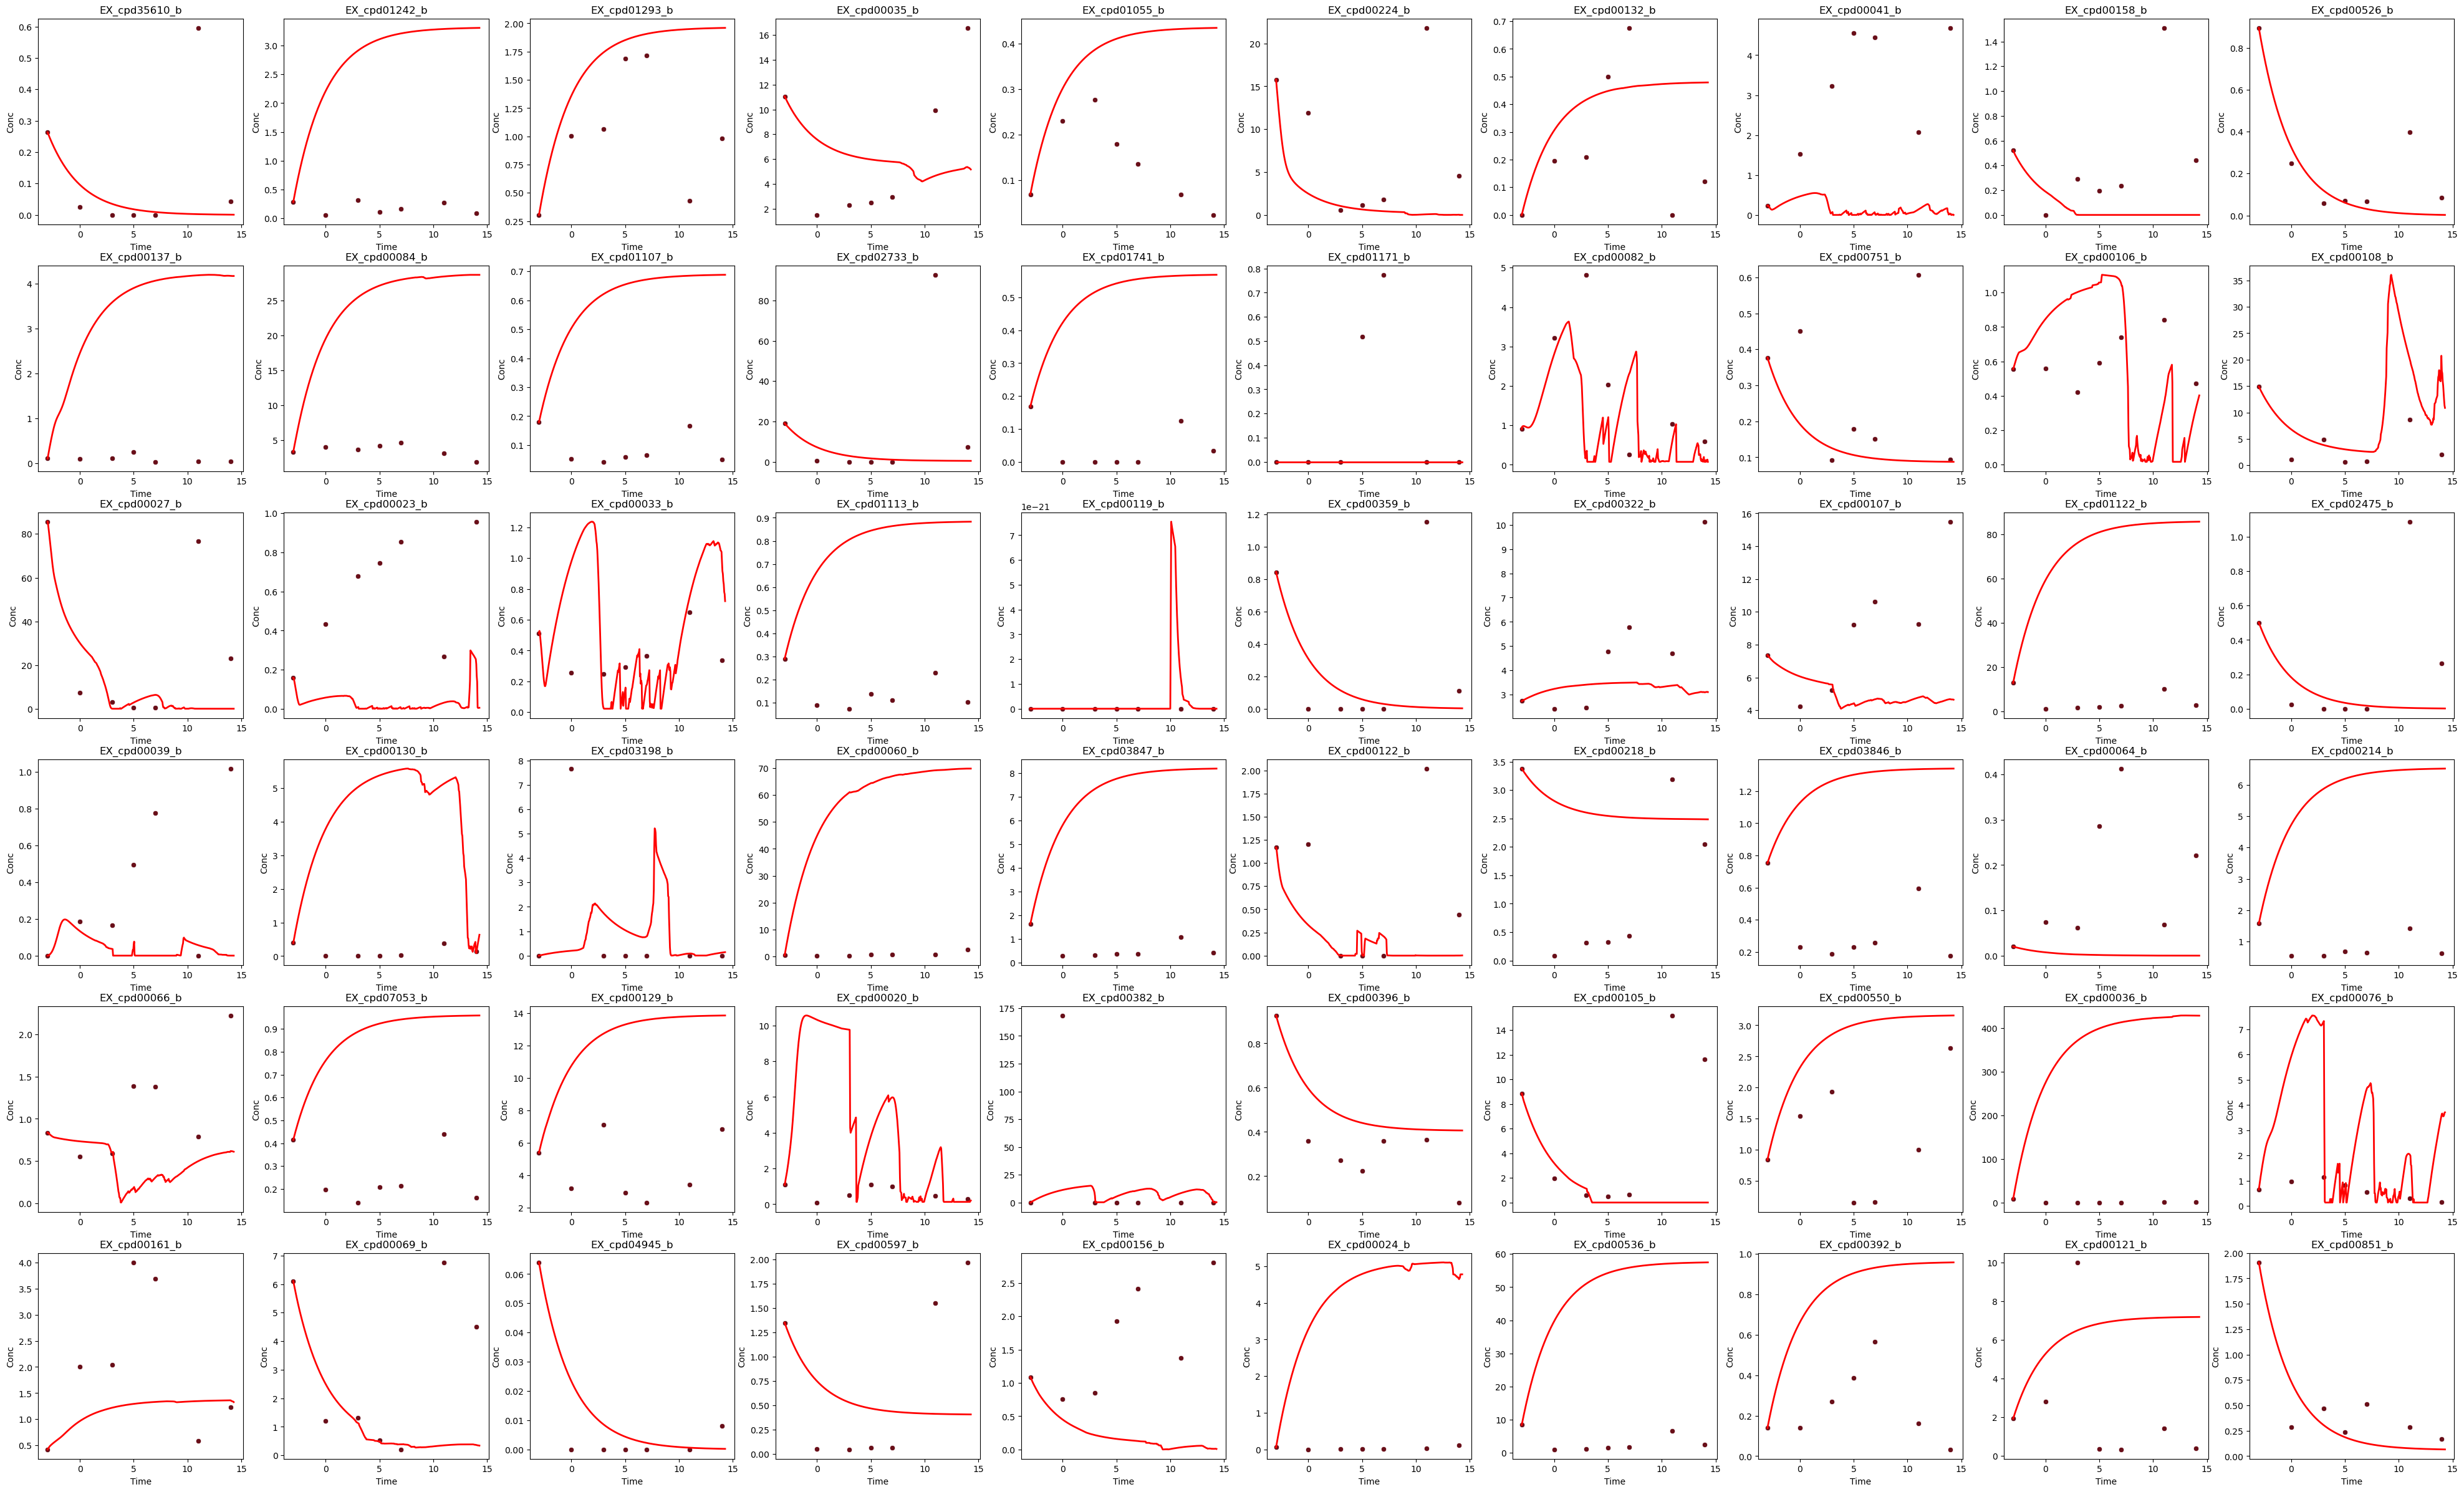

In [ ]:
from scipy.signal import savgol_filter
num_plots = 60
cols = 10  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i,met in enumerate(met_pool_over_time_df_filt.index.tolist()):
    temp_sim = met_pool_over_time_df_filt.loc[met,:]
    temp_exp = metabolomics_data_sub_1948.loc[met,:]
        # Scatter plot on the respective subplot
    sns.lineplot(ax=axes[i], x=temp_sim.index.to_list(), y=temp_sim.to_list(), color = 'red', lw = 2)
    #sns.lineplot(ax = axes[i], x = temp_sim.index.to_list(), y = list(savgol_filter(temp_sim.to_list(),1000,3)), color = 'blue', lw = 2)
    sns.scatterplot(ax=axes[i], x=temp_exp.index.to_list(), y=temp_exp.to_list())

    axes[i].set_title(f"{met}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Conc')
    #axes[i].set_yscale('log')
    #axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])


plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_exp_vs_sim_individual_scatterplots_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")

In [ ]:
metabolomics_data_sub_1948_melt = metabolomics_data_sub_1948.melt(ignore_index=False).reset_index()
metabolomics_data_sub_1948_melt.columns = ['metabolites', 'time', 'concentration']
metabolomics_data_sub_1948_melt.head()

metabolites  time  concentration
0  EX_cpd35610_b    -3          0.263
1  EX_cpd01242_b    -3          0.285
2  EX_cpd01293_b    -3          0.305
3  EX_cpd00035_b    -3         11.053
4  EX_cpd01055_b    -3          0.069

In [ ]:
### Prepare the simulation metabolomic data 
met_pool_over_time_df_filt_melt = met_pool_over_time_df_filt.melt(ignore_index=False).reset_index()
met_pool_over_time_df_filt_melt.columns = ['metabolites', 'time', 'concentration']
met_pool_over_time_df_filt_melt.head()
# use this to filter, agora_ex_ids_list

metabolites  time  concentration
0  EX_cpd35610_b  -3.0          0.263
1  EX_cpd01242_b  -3.0          0.285
2  EX_cpd01293_b  -3.0          0.305
3  EX_cpd00035_b  -3.0         11.053
4  EX_cpd01055_b  -3.0          0.069

In [ ]:
final_rounded_time_pt = met_pool_over_time_df_filt_melt['time'].max().round()


In [ ]:
met_pool_over_time_df_filt_melt.loc[
    met_pool_over_time_df_filt_melt['time'] == met_pool_over_time_df_filt_melt['time'].max(), 
    'time'
] = 14


In [ ]:
met_pool_over_time_df_filt_melt

metabolites  time  concentration
0      EX_cpd35610_b  -3.0       0.263000
1      EX_cpd01242_b  -3.0       0.285000
2      EX_cpd01293_b  -3.0       0.305000
3      EX_cpd00035_b  -3.0      11.053000
4      EX_cpd01055_b  -3.0       0.069000
...              ...   ...            ...
24955  EX_cpd00024_b  14.0       4.779970
24956  EX_cpd00536_b  14.0      57.481564
24957  EX_cpd00392_b  14.0       0.957525
24958  EX_cpd00121_b  14.0       7.175374
24959  EX_cpd00851_b  14.0       0.065571

[24960 rows x 3 columns]

In [ ]:
### ok now make scatterplot for each time point 

metabolomics_data_sub_1948_melt['time'] = pd.to_numeric(metabolomics_data_sub_1948_melt['time'], downcast='float') 
merged_exp_sim_met_data = metabolomics_data_sub_1948_melt.merge(met_pool_over_time_df_filt_melt, on=['time', 'metabolites'])
merged_exp_sim_met_data.columns = ['metabolites', 'time', 'exp_conc', 'sim_conc']
#met_pool_over_time_df_filt_ra

In [ ]:
merged_exp_sim_met_data

metabolites  time  exp_conc   sim_conc
0    EX_cpd35610_b  -3.0     0.263   0.263000
1    EX_cpd01242_b  -3.0     0.285   0.285000
2    EX_cpd01293_b  -3.0     0.305   0.305000
3    EX_cpd00035_b  -3.0    11.053  11.053000
4    EX_cpd01055_b  -3.0     0.069   0.069000
..             ...   ...       ...        ...
475  EX_cpd00392_b  14.0     0.033   0.957525
476  EX_cpd00121_b  14.0     0.380   7.173739
477  EX_cpd00121_b  14.0     0.380   7.175374
478  EX_cpd00851_b  14.0     0.167   0.066144
479  EX_cpd00851_b  14.0     0.167   0.065571

[480 rows x 4 columns]

In [ ]:
x = y = np.linspace(0,25,50)

1.0
0.487855209867783
0.41813682988062806
0.30311330281878923
0.23687265181460443
0.20081209253708332
0.27525610076607004


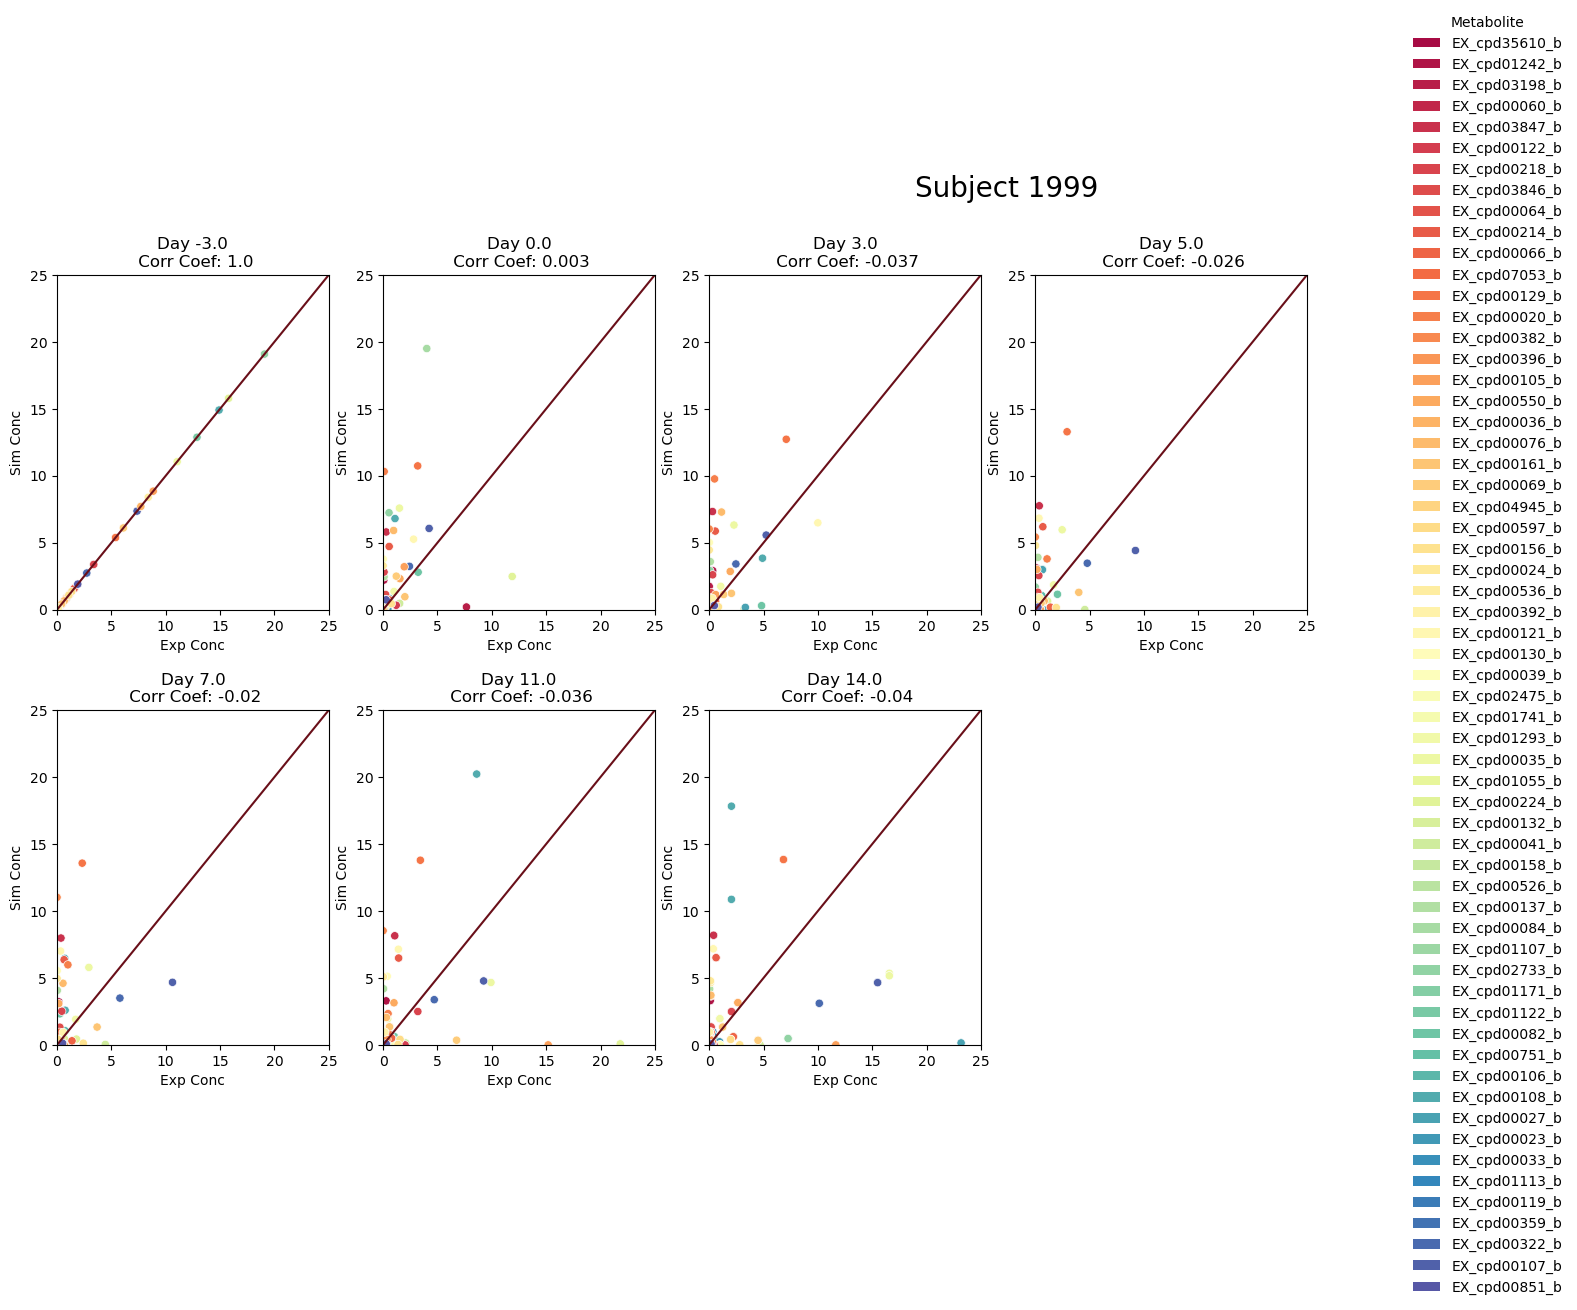

In [ ]:
from scipy.stats import pearsonr, spearmanr
num_plots = 7
cols = 4  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i,time in enumerate(merged_exp_sim_met_data['time'].unique().tolist()):
    temp = merged_exp_sim_met_data[merged_exp_sim_met_data['time'] == time]
    
        # Scatter plot on the respective subplot
    sns.scatterplot(ax=axes[i], data=temp, 
                    x=temp['exp_conc'], y=temp['sim_conc'], hue='metabolites', palette=color_map)
    temp_corr = np.round(np.corrcoef(temp['exp_conc'], temp['sim_conc'])[1,0],3)
    spearman = spearmanr(temp['exp_conc'], temp['sim_conc'])
    print(spearman.statistic)
    sns.lineplot(ax=axes[i], x=x, y = y)

    axes[i].set_xlim(0,25)
    axes[i].set_ylim(0,25)
    axes[i].set_title(f"Day {time}\n Corr Coef: {temp_corr}")
    axes[i].set_xlabel('Exp Conc')
    axes[i].set_ylabel('Sim Conc')
    axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Add custom legend to the *figure* (not either axis), outside plot
fig.legend(
    handles=legend_elements,
    title='Metabolite',
    loc='center left',
    bbox_to_anchor=(.8, 0.5),  # Push legend just outside right edge
    borderaxespad=0,
    frameon=False,
    ncol=1
)
# Adjust spacing to make room for the legend
plt.subplots_adjust(hspace=.3, right=1)  # Shrink plot width
overall_title = 'Subject ' + str(subject_to_plot)
plt.suptitle(overall_title, x=0.6, fontsize = 20)
plt.subplots_adjust(right=0.75)
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_scatter_exp_vs_sim_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()

1.0
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
0.30903259702582897
[[1.        0.0032873]
 [0.0032873 1.       ]]
[[1.        0.3090326]
 [0.3090326 1.       ]]
0.26501893679411975
[[ 1.         -0.03710534]
 [-0.03710534  1.        ]]
[[1.         0.26501894]
 [0.26501894 1.        ]]
0.2500154314899377
[[ 1.         -0.02572715]
 [-0.02572715  1.        ]]
[[1.         0.25001543]
 [0.25001543 1.        ]]
0.23368656672654076
[[ 1.         -0.01986516]
 [-0.01986516  1.        ]]
[[1.         0.23368657]
 [0.23368657 1.        ]]
0.14085907037523146
[[ 1.         -0.03550217]
 [-0.03550217  1.        ]]
[[1.         0.14085907]
 [0.14085907 1.        ]]
0.19827003350497144
[[ 1.         -0.03973377]
 [-0.03973377  1.        ]]
[[1.         0.19827003]
 [0.19827003 1.        ]]


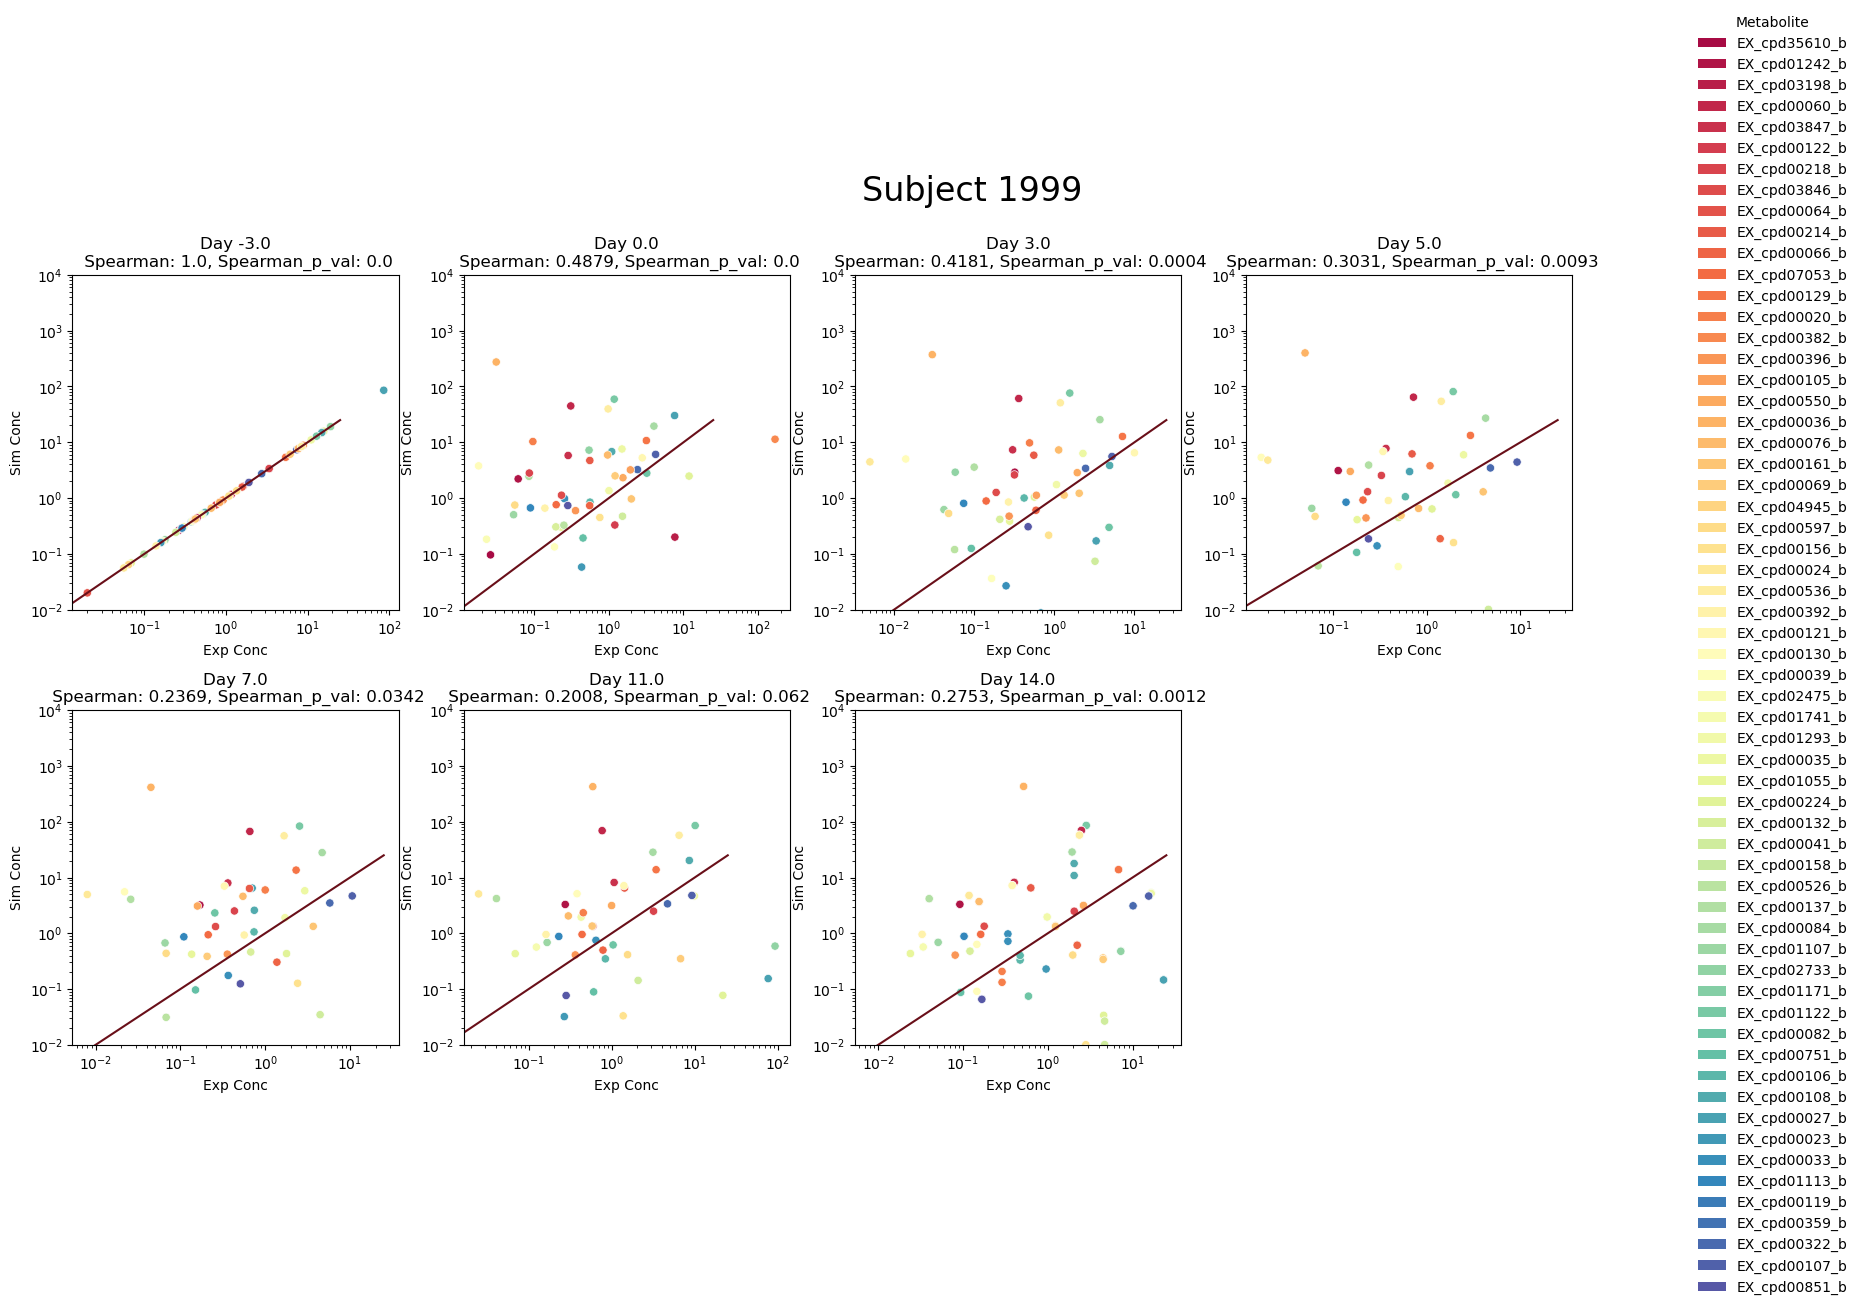

In [ ]:
num_plots = 7
cols = 4  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i,time in enumerate(merged_exp_sim_met_data['time'].unique().tolist()):
    temp = merged_exp_sim_met_data[merged_exp_sim_met_data['time'] == time]
    
        # Scatter plot on the respective subplot
    sns.scatterplot(ax=axes[i], data=temp, 
                    x=temp['exp_conc'], y=temp['sim_conc'], hue='metabolites', palette=color_map)

    sns.lineplot(ax=axes[i], x=x, y = y)
    temp_pearson = pearsonr(np.log1p(temp['exp_conc']), np.log1p(temp['sim_conc']), alternative='greater')
    print(temp_pearson.statistic)
    temp_corr = np.corrcoef(temp['exp_conc'], temp['sim_conc'])
    print(temp_corr)
    temp_corr_log = np.corrcoef(np.log1p(temp['exp_conc']), np.log1p(temp['sim_conc']))
    print(temp_corr_log)
    temp_spearman = spearmanr(np.log1p(temp['exp_conc']), np.log1p(temp['sim_conc']), alternative='greater')
    temp_spearman_stat_round = np.round(temp_spearman.statistic,4)
    temp_spearman_p_val_round = np.round(temp_spearman.pvalue,4)
    #axes[i].set_xlim(0,25)
    axes[i].set_ylim(10e-3,10e3)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_title(f"Day {time}\n Spearman: {temp_spearman_stat_round}, Spearman_p_val: {temp_spearman_p_val_round}")
    axes[i].set_xlabel('Exp Conc')
    axes[i].set_ylabel('Sim Conc')
    axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Add custom legend to the *figure* (not either axis), outside plot
fig.legend(
    handles=legend_elements,
    title='Metabolite',
    loc='center left',
    bbox_to_anchor=(.8, 0.5),  # Push legend just outside right edge
    borderaxespad=0,
    frameon=False,
    ncol=1
)
# Adjust spacing to make room for the legend
plt.subplots_adjust(hspace=.3, right=1)  # Shrink plot width
overall_title = 'Subject ' + str(subject_to_plot)
plt.suptitle(overall_title, x=0.5, fontsize = 24)
plt.subplots_adjust(right=0.75)
plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_scatter_exp_vs_sim_log_scale_' + str(test_num) + '.pdf'
plt.savefig(plot_file_name, bbox_inches="tight")
plt.show()

In [ ]:
### Ok now look at the utilization and production of things by the bacteria themselves 

for key in model_abun_dict:
    temp_df = pd.DataFrame(model_abun_dict[key]['flux_up'])
    print(key)

14ac4eaad5b4e2ff3c071832e0fd4229
18673193aa6bf30c6a1e71ac504e04df
320dfd16200daaf2b0503975d4e68fd5
36173253c63ad49abc12361a0b3304eb
391821255f31ef94686927f4fba6fbc3
3936cc515320e9f29d81ffeaa92718e8
3e741fc097143bb6782af5233cb7af98
4cc9a4b9aaa3ee9a5c14cc27551a6844
795b6ba45f502a00b24b212278991c63
7ca7ca8214441730c2437d1f53390cdb
94e30534f622e456a683abe4e60fc214
9cf5cb71450a2aa080ff905f89b0a624
e3147edad1f84fae8bb6fd6f5e7a97b9
e8aae590cf49eb3c80ad7e08f2d3c3c4
eba523a4a554db4ad7e9dcff257bf1c8


In [ ]:
temp_1 = pd.DataFrame(model_abun_dict['14ac4eaad5b4e2ff3c071832e0fd4229']['flux_up']).fillna(0)
temp_2 = pd.DataFrame(model_abun_dict['4cc9a4b9aaa3ee9a5c14cc27551a6844']['flux_up']).fillna(0)


In [ ]:
temp_1.add(temp_2, fill_value=0)

EX_cpd00001_b  EX_cpd00009_b  EX_cpd00011_b  EX_cpd00013_b  \
0              0.0       0.000000            0.0       0.000000   
1              0.0       0.002515            0.0       0.000000   
2              0.0       0.002337            0.0       0.000000   
3              0.0       0.002106            0.0       0.000000   
4              0.0       0.001827            0.0       0.000000   
..             ...            ...            ...            ...   
410            0.0       0.003182            0.0       0.015045   
411            0.0       0.003319            0.0       0.015905   
412            0.0       0.003460            0.0       0.016581   
413            0.0       0.003605            0.0       0.017274   
414            0.0       0.003753            0.0       0.017984   

     EX_cpd00020_b  EX_cpd00027_b  EX_cpd00028_b  EX_cpd00029_b  \
0     0.000000e+00       0.000000       0.000000            0.0   
1     0.000000e+00       0.001245       0.000014            0.0   
2     0.000000e+00       0.001157       0.000013            0.0   
3     0.000000e+00       0.001043       0.000012            0.0   
4     0.000000e+00       0.000905       0.000010            0.0   
..             ...            ...            ...            ...   
410   6.729754e-12       0.000000       0.000018            0.0   
411   6.670290e-12       0.000000       0.000019            0.0   
412   1.043941e-11       0.000000       0.000020            0.0   
413   1.124742e-11       0.000000       0.000021            0.0   
414   1.677640e-11       0.000000       0.000021            0.0   

     EX_cpd00030_b  EX_cpd00034_b  ...  EX_cpd00305_b  EX_cpd00309_b  \
0         0.000000       0.000000  ...   0.000000e+00       0.000000   
1         0.000014       0.000014  ...   0.000000e+00       0.000000   
2         0.000013       0.000013  ...   0.000000e+00       0.000000   
3         0.000012       0.000012  ...   0.000000e+00       0.000000   
4         0.000010       0.000010  ...   0.000000e+00       0.000000   
..             ...            ...  ...            ...            ...   
410       0.000018       0.000018  ...   3.125877e-19       0.000035   
411       0.000019       0.000019  ...   0.000000e+00       0.000000   
412       0.000020       0.000020  ...   0.000000e+00       0.000000   
413       0.000021       0.000021  ...   0.000000e+00       0.000000   
414       0.000021       0.000021  ...   0.000000e+00       0.000000   

     EX_cpd00322_b  EX_cpd00382_b  EX_cpd00393_b  EX_cpd00644_b  \
0     0.000000e+00       0.000000            0.0            0.0   
1     0.000000e+00       0.000000            0.0            0.0   
2     0.000000e+00       0.000000            0.0            0.0   
3     0.000000e+00       0.000000            0.0            0.0   
4     0.000000e+00       0.000000            0.0            0.0   
..             ...            ...            ...            ...   
410   1.027303e-12       0.021956            0.0            0.0   
411   8.238866e-13       0.022991            0.0            0.0   
412   1.626001e-12       0.023966            0.0            0.0   
413   1.943792e-12       0.024967            0.0            0.0   
414   2.753818e-12       0.025992            0.0            0.0   

     EX_cpd01414_b  EX_cpd10515_b  EX_cpd10516_b  EX_cpd15378_b  
0              0.0       0.000000       0.000000            0.0  
1              0.0       0.000029       0.000014            0.0  
2              0.0       0.000027       0.000013            0.0  
3              0.0       0.000024       0.000012            0.0  
4              0.0       0.000021       0.000010            0.0  
..             ...            ...            ...            ...  
410            0.0       0.000036       0.000018            0.0  
411            0.0       0.000038       0.000019            0.0  
412            0.0       0.000039       0.000020            0.0  
413            0.0       0.000041       0.000021            0.0  

In [ ]:

flux_up_df = pd.DataFrame()

for key in model_abun_dict:
    temp_up = pd.DataFrame(model_abun_dict[key]['flux_up']).fillna(0)
    flux_up_df = flux_up_df.add(temp_up, fill_value=0)

flux_up_df

EX_cpd00001_b  EX_cpd00007_b  EX_cpd00009_b  EX_cpd00011_b  \
0         0.000000            0.0       0.000000   0.000000e+00   
1         0.010968            0.0       0.023726   0.000000e+00   
2         0.034223            0.0       0.027854   0.000000e+00   
3         0.061994            0.0       0.029507   0.000000e+00   
4         0.091444            0.0       0.030662   0.000000e+00   
..             ...            ...            ...            ...   
410       0.028545            0.0       0.029988   3.278080e-23   
411       0.042265            0.0       0.031738   3.228338e-23   
412       0.050415            0.0       0.033543   3.180695e-23   
413       0.059309            0.0       0.035568   3.135117e-23   
414       0.067124            0.0       0.037728   5.866387e-05   

     EX_cpd00012_b  EX_cpd00013_b  EX_cpd00020_b  EX_cpd00023_b  \
0     0.000000e+00       0.000000       0.000000       0.000000   
1     0.000000e+00       0.013475       0.000000       0.010896   
2     0.000000e+00       0.033731       0.000000       0.011964   
3     0.000000e+00       0.030318       0.000000       0.012989   
4     0.000000e+00       0.026234       0.000000       0.013665   
..             ...            ...            ...            ...   
410   1.735454e-23       0.083343       0.110499       0.053272   
411   1.709120e-23       0.102313       0.128182       0.003988   
412   1.683897e-23       0.089826       0.097653       0.000649   
413   1.659768e-23       0.090590       0.089476       0.000744   
414   1.635972e-23       0.095683       0.113044       0.000861   

     EX_cpd00024_b  EX_cpd00027_b  ...  EX_cpd10515_b  EX_cpd10516_b  \
0         0.000000       0.000000  ...       0.000000       0.000000   
1         0.000000       0.694456  ...       0.000240       0.000452   
2         0.000000       0.855156  ...       0.000296       0.000586   
3         0.000000       0.931188  ...       0.000300       0.000718   
4         0.000000       0.992483  ...       0.000298       0.000866   
..             ...            ...  ...            ...            ...   
410       0.000000       0.159510  ...       0.000388       0.000577   
411       0.004323       0.167966  ...       0.000288       0.000697   
412       0.004827       0.160992  ...       0.000306       0.000672   
413       0.005043       0.142274  ...       0.000325       0.000698   
414       0.005242       0.152167  ...       0.000345       0.000722   

     EX_cpd11580_b  EX_cpd11584_b  EX_cpd11586_b  EX_cpd11588_b  \
0              0.0            0.0            0.0            0.0   
1              0.0            0.0            0.0            0.0   
2              0.0            0.0            0.0            0.0   
3              0.0            0.0            0.0            0.0   
4              0.0            0.0            0.0            0.0   
..             ...            ...            ...            ...   
410            0.0            0.0            0.0            0.0   
411            0.0            0.0            0.0            0.0   
412            0.0            0.0            0.0            0.0   
413            0.0            0.0            0.0            0.0   
414            0.0            0.0            0.0            0.0   

     EX_cpd11589_b  EX_cpd11591_b  EX_cpd15378_b  EX_cpd15603_b  
0              0.0            0.0            0.0            0.0  
1              0.0            0.0            0.0            0.0  
2              0.0            0.0            0.0            0.0  
3              0.0            0.0            0.0            0.0  
4              0.0            0.0            0.0            0.0  
..             ...            ...            ...            ...  
410            0.0            0.0            0.0            0.0  
411            0.0            0.0            0.0            0.0  
412            0.0            0.0            0.0            0.0  
413            0.0            0.0            0.0            0.0  

In [ ]:
flux_sec_df = pd.DataFrame()

for key in model_abun_dict:
    temp_sec = pd.DataFrame(model_abun_dict[key]['flux_sec']).fillna(0)
    flux_sec_df = flux_sec_df.add(temp_sec, fill_value=0)

flux_sec_df.columns

Index(['EX_cpd00001_b', 'EX_cpd00009_b', 'EX_cpd00011_b', 'EX_cpd00012_b',
       'EX_cpd00013_b', 'EX_cpd00020_b', 'EX_cpd00023_b', 'EX_cpd00024_b',
       'EX_cpd00027_b', 'EX_cpd00028_b', 'EX_cpd00029_b', 'EX_cpd00033_b',
       'EX_cpd00035_b', 'EX_cpd00036_b', 'EX_cpd00039_b', 'EX_cpd00041_b',
       'EX_cpd00047_b', 'EX_cpd00048_b', 'EX_cpd00051_b', 'EX_cpd00054_b',
       'EX_cpd00060_b', 'EX_cpd00064_b', 'EX_cpd00065_b', 'EX_cpd00066_b',
       'EX_cpd00067_b', 'EX_cpd00069_b', 'EX_cpd00071_b', 'EX_cpd00076_b',
       'EX_cpd00080_b', 'EX_cpd00081_b', 'EX_cpd00082_b', 'EX_cpd00084_b',
       'EX_cpd00092_b', 'EX_cpd00100_b', 'EX_cpd00104_b', 'EX_cpd00106_b',
       'EX_cpd00108_b', 'EX_cpd00116_b', 'EX_cpd00117_b', 'EX_cpd00118_b',
       'EX_cpd00119_b', 'EX_cpd00122_b', 'EX_cpd00128_b', 'EX_cpd00129_b',
       'EX_cpd00130_b', 'EX_cpd00137_b', 'EX_cpd00138_b', 'EX_cpd00139_b',
       'EX_cpd00156_b', 'EX_cpd00161_b', 'EX_cpd00180_b', 'EX_cpd00182_b',
       'EX_cpd00184_b', '

In [ ]:
### filter dataframes by metabolites of interest 

flux_up_df_filt = flux_up_df[flux_up_df.columns.intersection(change_met_ids)]
flux_up_df_filt

flux_sec_df_filt = flux_sec_df[flux_sec_df.columns.intersection(change_met_ids)]
flux_sec_df_filt

EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0         0.000000            0.0        0.00000   0.000000e+00   
1        -0.053148            0.0        0.00000   0.000000e+00   
2        -0.020232            0.0        0.00000   0.000000e+00   
3        -0.028053            0.0        0.00000   0.000000e+00   
4        -0.036978            0.0        0.00000   0.000000e+00   
..             ...            ...            ...            ...   
410      -0.006438            0.0       -0.03344  -5.243957e-18   
411      -0.007003            0.0        0.00000  -5.023613e-18   
412      -0.007021            0.0        0.00000  -4.805100e-18   
413      -0.007304            0.0        0.00000  -4.588535e-18   
414      -0.007589            0.0        0.00000  -4.374004e-18   

     EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0              0.0            0.0       0.000000       0.000000   
1              0.0            0.0      -0.004247      -0.000511   
2              0.0            0.0      -0.004301      -0.001557   
3              0.0            0.0      -0.004324      -0.002501   
4              0.0            0.0      -0.004358      -0.003414   
..             ...            ...            ...            ...   
410            0.0            0.0       0.000000       0.000000   
411            0.0            0.0       0.000000       0.000000   
412            0.0            0.0       0.000000       0.000000   
413            0.0            0.0       0.000000       0.000000   
414            0.0            0.0       0.000000       0.000000   

     EX_cpd00041_b  EX_cpd00060_b  ...  EX_cpd00106_b  EX_cpd00108_b  \
0              0.0            0.0  ...   0.000000e+00       0.000000   
1              0.0            0.0  ...  -5.731775e-03       0.000000   
2              0.0            0.0  ...  -5.462246e-03       0.000000   
3              0.0            0.0  ...  -6.000310e-03       0.000000   
4              0.0            0.0  ...  -6.343434e-03       0.000000   
..             ...            ...  ...            ...            ...   
410            0.0            0.0  ...  -5.013534e-23      -0.256591   
411            0.0            0.0  ...  -4.937458e-23      -0.183597   
412            0.0            0.0  ...  -4.864592e-23      -0.292531   
413            0.0            0.0  ...  -4.794885e-23      -0.361538   
414            0.0            0.0  ...  -4.726143e-23      -0.184489   

     EX_cpd00119_b  EX_cpd00122_b  EX_cpd00129_b  EX_cpd00130_b  \
0              0.0       0.000000            0.0       0.000000   
1              0.0       0.000000            0.0       0.000000   
2              0.0       0.000000            0.0       0.000000   
3              0.0       0.000000            0.0       0.000000   
4              0.0       0.000000            0.0       0.000000   
..             ...            ...            ...            ...   
410            0.0      -0.000523            0.0      -0.002293   
411            0.0      -0.000551            0.0      -0.002445   
412            0.0      -0.000579            0.0      -0.002571   
413            0.0      -0.000609            0.0      -0.002701   
414            0.0      -0.000639            0.0      -0.002835   

     EX_cpd00137_b  EX_cpd00156_b  EX_cpd00161_b  EX_cpd03198_b  
0              0.0            0.0            0.0            0.0  
1              0.0            0.0            0.0            0.0  
2              0.0            0.0            0.0            0.0  
3              0.0            0.0            0.0            0.0  
4              0.0            0.0            0.0            0.0  
..             ...            ...            ...            ...  
410            0.0            0.0            0.0            0.0  
411            0.0            0.0            0.0            0.0  
412            0.0            0.0            0.0            0.0  
413            0.0            0.0            0.0            0.0  

In [ ]:
### Ok now here filter the initial metabolite conditions by the columns but then add them to the time zero and cumsum after that 


### need to multiply the uptake and secretion dataframes by -1 because opposite of how we would think of these things currently

flux_sec_df_filt = flux_sec_df_filt*-1.0
flux_up_df_filt = flux_up_df_filt*-1.0

In [ ]:
# Merge with suffixes to distinguish common columns
merged_bac_met_use_df = flux_sec_df_filt.merge(flux_up_df_filt, how='outer', left_index=True, right_index=True)
merged_bac_met_use_df

EX_cpd00020_b_x  EX_cpd00023_b_x  EX_cpd00024_b_x  EX_cpd00027_b_x  \
0          -0.000000             -0.0         -0.00000    -0.000000e+00   
1           0.053148             -0.0         -0.00000    -0.000000e+00   
2           0.020232             -0.0         -0.00000    -0.000000e+00   
3           0.028053             -0.0         -0.00000    -0.000000e+00   
4           0.036978             -0.0         -0.00000    -0.000000e+00   
..               ...              ...              ...              ...   
410         0.006438             -0.0          0.03344     5.243957e-18   
411         0.007003             -0.0         -0.00000     5.023613e-18   
412         0.007021             -0.0         -0.00000     4.805100e-18   
413         0.007304             -0.0         -0.00000     4.588535e-18   
414         0.007589             -0.0         -0.00000     4.374004e-18   

     EX_cpd00033_b_x  EX_cpd00035_b_x  EX_cpd00036_b_x  EX_cpd00039_b_x  \
0               -0.0             -0.0        -0.000000        -0.000000   
1               -0.0             -0.0         0.004247         0.000511   
2               -0.0             -0.0         0.004301         0.001557   
3               -0.0             -0.0         0.004324         0.002501   
4               -0.0             -0.0         0.004358         0.003414   
..               ...              ...              ...              ...   
410             -0.0             -0.0        -0.000000        -0.000000   
411             -0.0             -0.0        -0.000000        -0.000000   
412             -0.0             -0.0        -0.000000        -0.000000   
413             -0.0             -0.0        -0.000000        -0.000000   
414             -0.0             -0.0        -0.000000        -0.000000   

     EX_cpd00041_b_x  EX_cpd00060_b_x  ...  EX_cpd00137_b_y  EX_cpd00156_b_y  \
0               -0.0             -0.0  ...        -0.000000        -0.000000   
1               -0.0             -0.0  ...        -0.000627        -0.000439   
2               -0.0             -0.0  ...        -0.000869        -0.002577   
3               -0.0             -0.0  ...        -0.001135        -0.002334   
4               -0.0             -0.0  ...        -0.001438        -0.002067   
..               ...              ...  ...              ...              ...   
410             -0.0             -0.0  ...        -0.000673        -0.000988   
411             -0.0             -0.0  ...        -0.000886        -0.001069   
412             -0.0             -0.0  ...        -0.000518        -0.001147   
413             -0.0             -0.0  ...        -0.000531        -0.001223   
414             -0.0             -0.0  ...        -0.000541        -0.002338   

     EX_cpd00158_b  EX_cpd00161_b_y  EX_cpd00214_b  EX_cpd00218_b  \
0        -0.000000        -0.000000  -0.000000e+00      -0.000000   
1        -0.001331        -0.000307  -0.000000e+00      -0.000061   
2        -0.001010        -0.000318  -0.000000e+00      -0.000009   
3        -0.000679        -0.000315  -0.000000e+00      -0.000007   
4        -0.000345        -0.000334  -0.000000e+00      -0.000004   
..             ...              ...            ...            ...   
410      -0.000000        -0.002750  -0.000000e+00      -0.000069   
411      -0.000000        -0.002859  -0.000000e+00      -0.000073   
412      -0.000000        -0.002969  -1.687171e-07      -0.000077   
413      -0.000000        -0.003078  -1.735063e-07      -0.000081   
414      -0.000000        -0.003187  -1.770645e-07      -0.000085   

     EX_cpd00224_b  EX_cpd00322_b  EX_cpd00382_b  EX_cpd03198_b_y  
0        -0.399831      -0.000000      -0.000000             -0.0  
1        -0.384366      -0.001114      -0.000000             -0.0  
2        -0.400873      -0.000237      -0.000000             -0.0  
3        -0.412492      -0.000211      -0.000000             -0.0  
4        -0.418981      -0.000191      -0.000000             -0.0  
..   

In [ ]:
### Ok now need to figure out how to add the correct columns together into a new column and then drop any columns with _x or _y

for column in merged_bac_met_use_df.columns:
    if column.endswith(('_x')):
        temp_col = column.split('_')
        #print(temp_col)
        temp_col = temp_col[0] + '_' + temp_col[1] + '_' +temp_col[2] + '_y'
        #print(temp_col)
        merged_bac_met_use_df.loc[:,column] = merged_bac_met_use_df.loc[:,column] + merged_bac_met_use_df.loc[:,temp_col]
    else:
        continue
merged_bac_met_use_df

EX_cpd00020_b_x  EX_cpd00023_b_x  EX_cpd00024_b_x  EX_cpd00027_b_x  \
0          -0.000000        -0.000000        -0.000000        -0.000000   
1           0.053148        -0.010896        -0.000000        -0.694456   
2           0.020232        -0.011964        -0.000000        -0.855156   
3           0.028053        -0.012989        -0.000000        -0.931188   
4           0.036978        -0.013665        -0.000000        -0.992483   
..               ...              ...              ...              ...   
410        -0.104061        -0.053272         0.033440        -0.159510   
411        -0.121179        -0.003988        -0.004323        -0.167966   
412        -0.090632        -0.000649        -0.004827        -0.160992   
413        -0.082172        -0.000744        -0.005043        -0.142274   
414        -0.105456        -0.000861        -0.005242        -0.152167   

     EX_cpd00033_b_x  EX_cpd00035_b_x  EX_cpd00036_b_x  EX_cpd00039_b_x  \
0          -0.000000        -0.000000        -0.000000        -0.000000   
1          -0.037175        -0.001775         0.004247         0.000511   
2          -0.041660        -0.001666         0.004301         0.001516   
3          -0.046681        -0.001529         0.004324         0.002308   
4          -0.050888        -0.001371         0.004358         0.002932   
..               ...              ...              ...              ...   
410        -0.028503        -0.019079        -0.000000        -0.000004   
411        -0.032939        -0.029221        -0.000000        -0.000000   
412        -0.032896        -0.034734        -0.000000        -0.000000   
413        -0.025608        -0.040892        -0.000000        -0.000000   
414        -0.027359        -0.046448        -0.000000        -0.000000   

     EX_cpd00041_b_x  EX_cpd00060_b_x  ...  EX_cpd00137_b_y  EX_cpd00156_b_y  \
0          -0.000000        -0.000000  ...        -0.000000        -0.000000   
1          -0.020225        -0.005911  ...        -0.000627        -0.000439   
2          -0.021548        -0.007019  ...        -0.000869        -0.002577   
3          -0.023058        -0.007329  ...        -0.001135        -0.002334   
4          -0.024204        -0.007498  ...        -0.001438        -0.002067   
..               ...              ...  ...              ...              ...   
410        -0.010295        -0.004039  ...        -0.000673        -0.000988   
411        -0.004087        -0.004450  ...        -0.000886        -0.001069   
412        -0.006617        -0.004802  ...        -0.000518        -0.001147   
413        -0.008217        -0.005200  ...        -0.000531        -0.001223   
414        -0.009119        -0.005709  ...        -0.000541        -0.002338   

     EX_cpd00158_b  EX_cpd00161_b_y  EX_cpd00214_b  EX_cpd00218_b  \
0        -0.000000        -0.000000  -0.000000e+00      -0.000000   
1        -0.001331        -0.000307  -0.000000e+00      -0.000061   
2        -0.001010        -0.000318  -0.000000e+00      -0.000009   
3        -0.000679        -0.000315  -0.000000e+00      -0.000007   
4        -0.000345        -0.000334  -0.000000e+00      -0.000004   
..             ...              ...            ...            ...   
410      -0.000000        -0.002750  -0.000000e+00      -0.000069   
411      -0.000000        -0.002859  -0.000000e+00      -0.000073   
412      -0.000000        -0.002969  -1.687171e-07      -0.000077   
413      -0.000000        -0.003078  -1.735063e-07      -0.000081   
414      -0.000000        -0.003187  -1.770645e-07      -0.000085   

     EX_cpd00224_b  EX_cpd00322_b  EX_cpd00382_b  EX_cpd03198_b_y  
0        -0.399831      -0.000000      -0.000000             -0.0  
1        -0.384366      -0.001114      -0.000000             -0.0  
2        -0.400873      -0.000237      -0.000000             -0.0  
3        -0.412492      -0.000211      -0.000000             -0.0  
4        -0.418981      -0.000191      -0.000000             -0.0  
..   

In [ ]:
### Ok now take columns, drop the _y columns and then 
# Drop all columns ending with '_y'
merged_bac_met_use_df = merged_bac_met_use_df.drop(columns=[col for col in merged_bac_met_use_df.columns if col.endswith('_y')])

# Rename columns ending with '_x' by removing the '_x' suffix
merged_bac_met_use_df.columns = [col.replace('_x', '') if col.endswith('_x') else col for col in merged_bac_met_use_df.columns]

merged_bac_met_use_df

EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0        -0.000000      -0.000000      -0.000000      -0.000000   
1         0.053148      -0.010896      -0.000000      -0.694456   
2         0.020232      -0.011964      -0.000000      -0.855156   
3         0.028053      -0.012989      -0.000000      -0.931188   
4         0.036978      -0.013665      -0.000000      -0.992483   
..             ...            ...            ...            ...   
410      -0.104061      -0.053272       0.033440      -0.159510   
411      -0.121179      -0.003988      -0.004323      -0.167966   
412      -0.090632      -0.000649      -0.004827      -0.160992   
413      -0.082172      -0.000744      -0.005043      -0.142274   
414      -0.105456      -0.000861      -0.005242      -0.152167   

     EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0        -0.000000      -0.000000      -0.000000      -0.000000   
1        -0.037175      -0.001775       0.004247       0.000511   
2        -0.041660      -0.001666       0.004301       0.001516   
3        -0.046681      -0.001529       0.004324       0.002308   
4        -0.050888      -0.001371       0.004358       0.002932   
..             ...            ...            ...            ...   
410      -0.028503      -0.019079      -0.000000      -0.000004   
411      -0.032939      -0.029221      -0.000000      -0.000000   
412      -0.032896      -0.034734      -0.000000      -0.000000   
413      -0.025608      -0.040892      -0.000000      -0.000000   
414      -0.027359      -0.046448      -0.000000      -0.000000   

     EX_cpd00041_b  EX_cpd00060_b  ...  EX_cpd03198_b  EX_cpd00105_b  \
0        -0.000000      -0.000000  ...           -0.0      -0.000000   
1        -0.020225      -0.005911  ...           -0.0      -0.029414   
2        -0.021548      -0.007019  ...           -0.0      -0.022314   
3        -0.023058      -0.007329  ...           -0.0      -0.014995   
4        -0.024204      -0.007498  ...           -0.0      -0.007634   
..             ...            ...  ...            ...            ...   
410      -0.010295      -0.004039  ...           -0.0      -0.000000   
411      -0.004087      -0.004450  ...           -0.0      -0.000000   
412      -0.006617      -0.004802  ...           -0.0      -0.000000   
413      -0.008217      -0.005200  ...           -0.0      -0.000000   
414      -0.009119      -0.005709  ...           -0.0      -0.000000   

     EX_cpd00107_b  EX_cpd00132_b  EX_cpd00158_b  EX_cpd00214_b  \
0        -0.000000  -0.000000e+00      -0.000000  -0.000000e+00   
1        -0.005765  -5.757040e-06      -0.001331  -0.000000e+00   
2        -0.005490  -1.242082e-05      -0.001010  -0.000000e+00   
3        -0.005795  -2.118694e-05      -0.000679  -0.000000e+00   
4        -0.005996  -3.293273e-05      -0.000345  -0.000000e+00   
..             ...            ...            ...            ...   
410      -0.007851  -5.634604e-13      -0.000000  -0.000000e+00   
411      -0.008316  -4.518893e-13      -0.000000  -0.000000e+00   
412      -0.008824  -8.918371e-13      -0.000000  -1.687171e-07   
413      -0.009371  -1.066140e-12      -0.000000  -1.735063e-07   
414      -0.009958  -1.510427e-12      -0.000000  -1.770645e-07   

     EX_cpd00218_b  EX_cpd00224_b  EX_cpd00322_b  EX_cpd00382_b  
0        -0.000000      -0.399831      -0.000000      -0.000000  
1        -0.000061      -0.384366      -0.001114      -0.000000  
2        -0.000009      -0.400873      -0.000237      -0.000000  
3        -0.000007      -0.412492      -0.000211      -0.000000  
4        -0.000004      -0.418981      -0.000191      -0.000000  
..             ...            ...            ...            ...  
410      -0.000069      -0.001809      -0.001457      -0.153467  
411      -0.000073      -0.001148      -0.004217      -0.118242  
412      -0.000077      -0.001926      -0.004393      -0.173953  
413      -0.000081      -0.002439      -0.004567      -0.212851  

In [ ]:
for i in merged_bac_met_use_df.columns:
    if i in metabolomics_data_initial_sub_1948['reaction'].to_list():
        merged_bac_met_use_df.loc[0,i] = metabolomics_data_initial_sub_1948[metabolomics_data_initial_sub_1948['reaction'] == i]['fluxValue'].iloc[0]
    else:
        continue

merged_bac_met_use_df

EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0         1.089000       0.159000       0.056000      85.571000   
1         0.053148      -0.010896      -0.000000      -0.694456   
2         0.020232      -0.011964      -0.000000      -0.855156   
3         0.028053      -0.012989      -0.000000      -0.931188   
4         0.036978      -0.013665      -0.000000      -0.992483   
..             ...            ...            ...            ...   
410      -0.104061      -0.053272       0.033440      -0.159510   
411      -0.121179      -0.003988      -0.004323      -0.167966   
412      -0.090632      -0.000649      -0.004827      -0.160992   
413      -0.082172      -0.000744      -0.005043      -0.142274   
414      -0.105456      -0.000861      -0.005242      -0.152167   

     EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0         0.512000      11.053000       7.710000       0.000000   
1        -0.037175      -0.001775       0.004247       0.000511   
2        -0.041660      -0.001666       0.004301       0.001516   
3        -0.046681      -0.001529       0.004324       0.002308   
4        -0.050888      -0.001371       0.004358       0.002932   
..             ...            ...            ...            ...   
410      -0.028503      -0.019079      -0.000000      -0.000004   
411      -0.032939      -0.029221      -0.000000      -0.000000   
412      -0.032896      -0.034734      -0.000000      -0.000000   
413      -0.025608      -0.040892      -0.000000      -0.000000   
414      -0.027359      -0.046448      -0.000000      -0.000000   

     EX_cpd00041_b  EX_cpd00060_b  ...  EX_cpd03198_b  EX_cpd00105_b  \
0         0.243000       0.442000  ...            0.0       8.850000   
1        -0.020225      -0.005911  ...           -0.0      -0.029414   
2        -0.021548      -0.007019  ...           -0.0      -0.022314   
3        -0.023058      -0.007329  ...           -0.0      -0.014995   
4        -0.024204      -0.007498  ...           -0.0      -0.007634   
..             ...            ...  ...            ...            ...   
410      -0.010295      -0.004039  ...           -0.0      -0.000000   
411      -0.004087      -0.004450  ...           -0.0      -0.000000   
412      -0.006617      -0.004802  ...           -0.0      -0.000000   
413      -0.008217      -0.005200  ...           -0.0      -0.000000   
414      -0.009119      -0.005709  ...           -0.0      -0.000000   

     EX_cpd00107_b  EX_cpd00132_b  EX_cpd00158_b  EX_cpd00214_b  \
0         7.363000   0.000000e+00       0.520000   1.576000e+00   
1        -0.005765  -5.757040e-06      -0.001331  -0.000000e+00   
2        -0.005490  -1.242082e-05      -0.001010  -0.000000e+00   
3        -0.005795  -2.118694e-05      -0.000679  -0.000000e+00   
4        -0.005996  -3.293273e-05      -0.000345  -0.000000e+00   
..             ...            ...            ...            ...   
410      -0.007851  -5.634604e-13      -0.000000  -0.000000e+00   
411      -0.008316  -4.518893e-13      -0.000000  -0.000000e+00   
412      -0.008824  -8.918371e-13      -0.000000  -1.687171e-07   
413      -0.009371  -1.066140e-12      -0.000000  -1.735063e-07   
414      -0.009958  -1.510427e-12      -0.000000  -1.770645e-07   

     EX_cpd00218_b  EX_cpd00224_b  EX_cpd00322_b  EX_cpd00382_b  
0         3.379000      15.784000       2.736000       0.000000  
1        -0.000061      -0.384366      -0.001114      -0.000000  
2        -0.000009      -0.400873      -0.000237      -0.000000  
3        -0.000007      -0.412492      -0.000211      -0.000000  
4        -0.000004      -0.418981      -0.000191      -0.000000  
..             ...            ...            ...            ...  
410      -0.000069      -0.001809      -0.001457      -0.153467  
411      -0.000073      -0.001148      -0.004217      -0.118242  
412      -0.000077      -0.001926      -0.004393      -0.173953  
413      -0.000081      -0.002439      -0.004567      -0.212851  

In [ ]:
### ok here now cumsum sec and uptake dfs

merged_bac_met_use_df = merged_bac_met_use_df.cumsum()

In [ ]:
merged_bac_met_use_df.reset_index()

index  EX_cpd00020_b  EX_cpd00023_b  EX_cpd00024_b  EX_cpd00027_b  \
0        0       1.089000       0.159000       0.056000      85.571000   
1        1       1.142148       0.148104       0.056000      84.876544   
2        2       1.162380       0.136140       0.056000      84.021388   
3        3       1.190433       0.123151       0.056000      83.090199   
4        4       1.227411       0.109486       0.056000      82.097717   
..     ...            ...            ...            ...            ...   
410    410     -24.386348      -0.261155      -0.243363       7.105652   
411    411     -24.507527      -0.265144      -0.247686       6.937686   
412    412     -24.598159      -0.265792      -0.252514       6.776694   
413    413     -24.680331      -0.266536      -0.257557       6.634421   
414    414     -24.785787      -0.267397      -0.262799       6.482253   

     EX_cpd00033_b  EX_cpd00035_b  EX_cpd00036_b  EX_cpd00039_b  \
0         0.512000      11.053000       7.710000       0.000000   
1         0.474825      11.051225       7.714247       0.000511   
2         0.433165      11.049559       7.718548       0.002027   
3         0.386484      11.048030       7.722872       0.004335   
4         0.335595      11.046660       7.727231       0.007266   
..             ...            ...            ...            ...   
410      -4.575222       9.514441       9.840419       0.266122   
411      -4.608161       9.485220       9.840419       0.266122   
412      -4.641057       9.450486       9.840419       0.266122   
413      -4.666665       9.409593       9.840419       0.266122   
414      -4.694024       9.363145       9.840419       0.266122   

     EX_cpd00041_b  ...  EX_cpd03198_b  EX_cpd00105_b  EX_cpd00107_b  \
0         0.243000  ...       0.000000       8.850000       7.363000   
1         0.222775  ...       0.000000       8.820586       7.357235   
2         0.201227  ...       0.000000       8.798272       7.351745   
3         0.178169  ...       0.000000       8.783277       7.345950   
4         0.153964  ...       0.000000       8.775643       7.339953   
..             ...  ...            ...            ...            ...   
410      -2.966923  ...       1.956484       8.330519       5.580918   
411      -2.971011  ...       1.956484       8.330519       5.572602   
412      -2.977627  ...       1.956484       8.330519       5.563778   
413      -2.985844  ...       1.956484       8.330519       5.554407   
414      -2.994963  ...       1.956484       8.330519       5.544449   

     EX_cpd00132_b  EX_cpd00158_b  EX_cpd00214_b  EX_cpd00218_b  \
0         0.000000       0.520000       1.576000       3.379000   
1        -0.000006       0.518669       1.576000       3.378939   
2        -0.000018       0.517659       1.576000       3.378930   
3        -0.000039       0.516981       1.576000       3.378923   
4        -0.000072       0.516635       1.576000       3.378919   
..             ...            ...            ...            ...   
410      -0.003285       0.419784       1.572412       3.377215   
411      -0.003285       0.419784       1.572412       3.377142   
412      -0.003285       0.419784       1.572412       3.377065   
413      -0.003285       0.419784       1.572412       3.376984   
414      -0.003285       0.419784       1.572411       3.376900   

     EX_cpd00224_b  EX_cpd00322_b  EX_cpd00382_b  
0        15.784000       2.736000       0.000000  
1        15.399634       2.734886       0.000000  
2        14.998760       2.734650       0.000000  
3        14.586268       2.734438       0.000000  
4        14.167286       2.734247       0.000000  
..             ...            ...            ...  
410       7.865430       2.278481     -42.981434  
411       7.864282       2.274264     -43.099677  
412       7.862356       2.269871     -43.273629  
413       7.859917       2.265304     -43.486480  
414       7.857149       2.260572     -43.613522  

[415 rows x 36 columns]

In [ ]:
merged_bac_met_use_df = merged_bac_met_use_df.reset_index()
merged_bac_met_use_df['index'] = (merged_bac_met_use_df['index']/time_scaler)-3
merged_bac_met_use_df = merged_bac_met_use_df.set_index('index').T
merged_bac_met_use_df

index          -3.000000   -2.958333   -2.916667   -2.875000   -2.833333   \
EX_cpd00020_b       1.089    1.142148    1.162380    1.190433    1.227411   
EX_cpd00023_b       0.159    0.148104    0.136140    0.123151    0.109486   
EX_cpd00024_b       0.056    0.056000    0.056000    0.056000    0.056000   
EX_cpd00027_b      85.571   84.876544   84.021388   83.090199   82.097717   
EX_cpd00033_b       0.512    0.474825    0.433165    0.386484    0.335595   
EX_cpd00035_b      11.053   11.051225   11.049559   11.048030   11.046660   
EX_cpd00036_b       7.710    7.714247    7.718548    7.722872    7.727231   
EX_cpd00039_b       0.000    0.000511    0.002027    0.004335    0.007266   
EX_cpd00041_b       0.243    0.222775    0.201227    0.178169    0.153964   
EX_cpd00060_b       0.442    0.436089    0.429069    0.421740    0.414242   
EX_cpd00064_b       0.020    0.020000    0.020000    0.020000    0.020000   
EX_cpd00066_b       0.836    0.833611    0.830718    0.827667    0.824518   
EX_cpd00069_b       6.104    6.102574    6.100791    6.098879    6.096874   
EX_cpd00076_b       0.660    0.658741    0.656233    0.652430    0.647226   
EX_cpd00082_b       0.905    0.851819    0.794814    0.734501    0.671459   
EX_cpd00084_b       3.358    3.343330    3.329818    3.317645    3.307081   
EX_cpd00106_b       0.555    0.556704    0.558076    0.559925    0.562054   
EX_cpd00108_b      14.906   14.906000   14.906000   14.906000   14.906000   
EX_cpd00119_b       0.000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00122_b       1.167    1.137892    1.109357    1.082248    1.057034   
EX_cpd00129_b       5.386    5.385916    5.385757    5.385521    5.385196   
EX_cpd00130_b       0.389    0.389000    0.389000    0.389000    0.389000   
EX_cpd00137_b       0.099    0.098373    0.097503    0.096368    0.094929   
EX_cpd00156_b       1.086    1.085561    1.082984    1.080650    1.078582   
EX_cpd00161_b       0.423    0.422693    0.422375    0.422060    0.421727   
EX_cpd03198_b       0.000    0.000000    0.000000    0.000000    0.000000   
EX_cpd00105_b       8.850    8.820586    8.798272    8.783277    8.775643   
EX_cpd00107_b       7.363    7.357235    7.351745    7.345950    7.339953   
EX_cpd00132_b       0.000   -0.000006   -0.000018   -0.000039   -0.000072   
EX_cpd00158_b       0.520    0.518669    0.517659    0.516981    0.516635   
EX_cpd00214_b       1.576    1.576000    1.576000    1.576000    1.576000   
EX_cpd00218_b       3.379    3.378939    3.378930    3.378923    3.378919   
EX_cpd00224_b      15.784   15.399634   14.998760   14.586268   14.167286   
EX_cpd00322_b       2.736    2.734886    2.734650    2.734438    2.734247   
EX_cpd00382_b       0.000    0.000000    0.000000    0.000000    0.000000   

index          -2.791667   -2.750000   -2.708333   -2.666667   -2.625000   \
EX_cpd00020_b    1.284318    1.349289    1.423039    1.506498    1.600667   
EX_cpd00023_b    0.095571    0.082014    0.069061    0.057070    0.046298   
EX_cpd00024_b    0.056000    0.056000    0.056000    0.056000    0.056000   
EX_cpd00027_b   81.046033   79.966932   78.886062   77.829977   76.824493   
EX_cpd00033_b    0.281649    0.225806    0.169568    0.114377    0.061452   
EX_cpd00035_b   11.045468   11.044463   11.043650   11.043023   11.042567   
EX_cpd00036_b    7.732823    7.738516    7.744307    7.750188    7.756147   
EX_cpd00039_b    0.009729    0.012474    0.015811    0.019739    0.024255   
EX_cpd00041_b    0.130892    0.109919    0.091452    0.076076    0.064593   
EX_cpd00060_b    0.406738    0.399389    0.392304    0.385729    0.379833   
EX_cpd00064_b    0.020000    0.020000    0.020000    0.020000    0.020000   
EX_cpd00066_b    0.821341    0.818215    0.815219    0.812434    0.809936   
EX_cpd00069_b    6.094819    6.092768    6.090775    6.088893    6.087174   
EX_cpd00076_b    0.641089    0.633838    0.625252    0.615071    0.602980   
EX_cpd00082_b    0.606303    0.539571    0.471877    0.403802    0.33587

In [ ]:
merged_bac_met_use_df.shape[0]

35

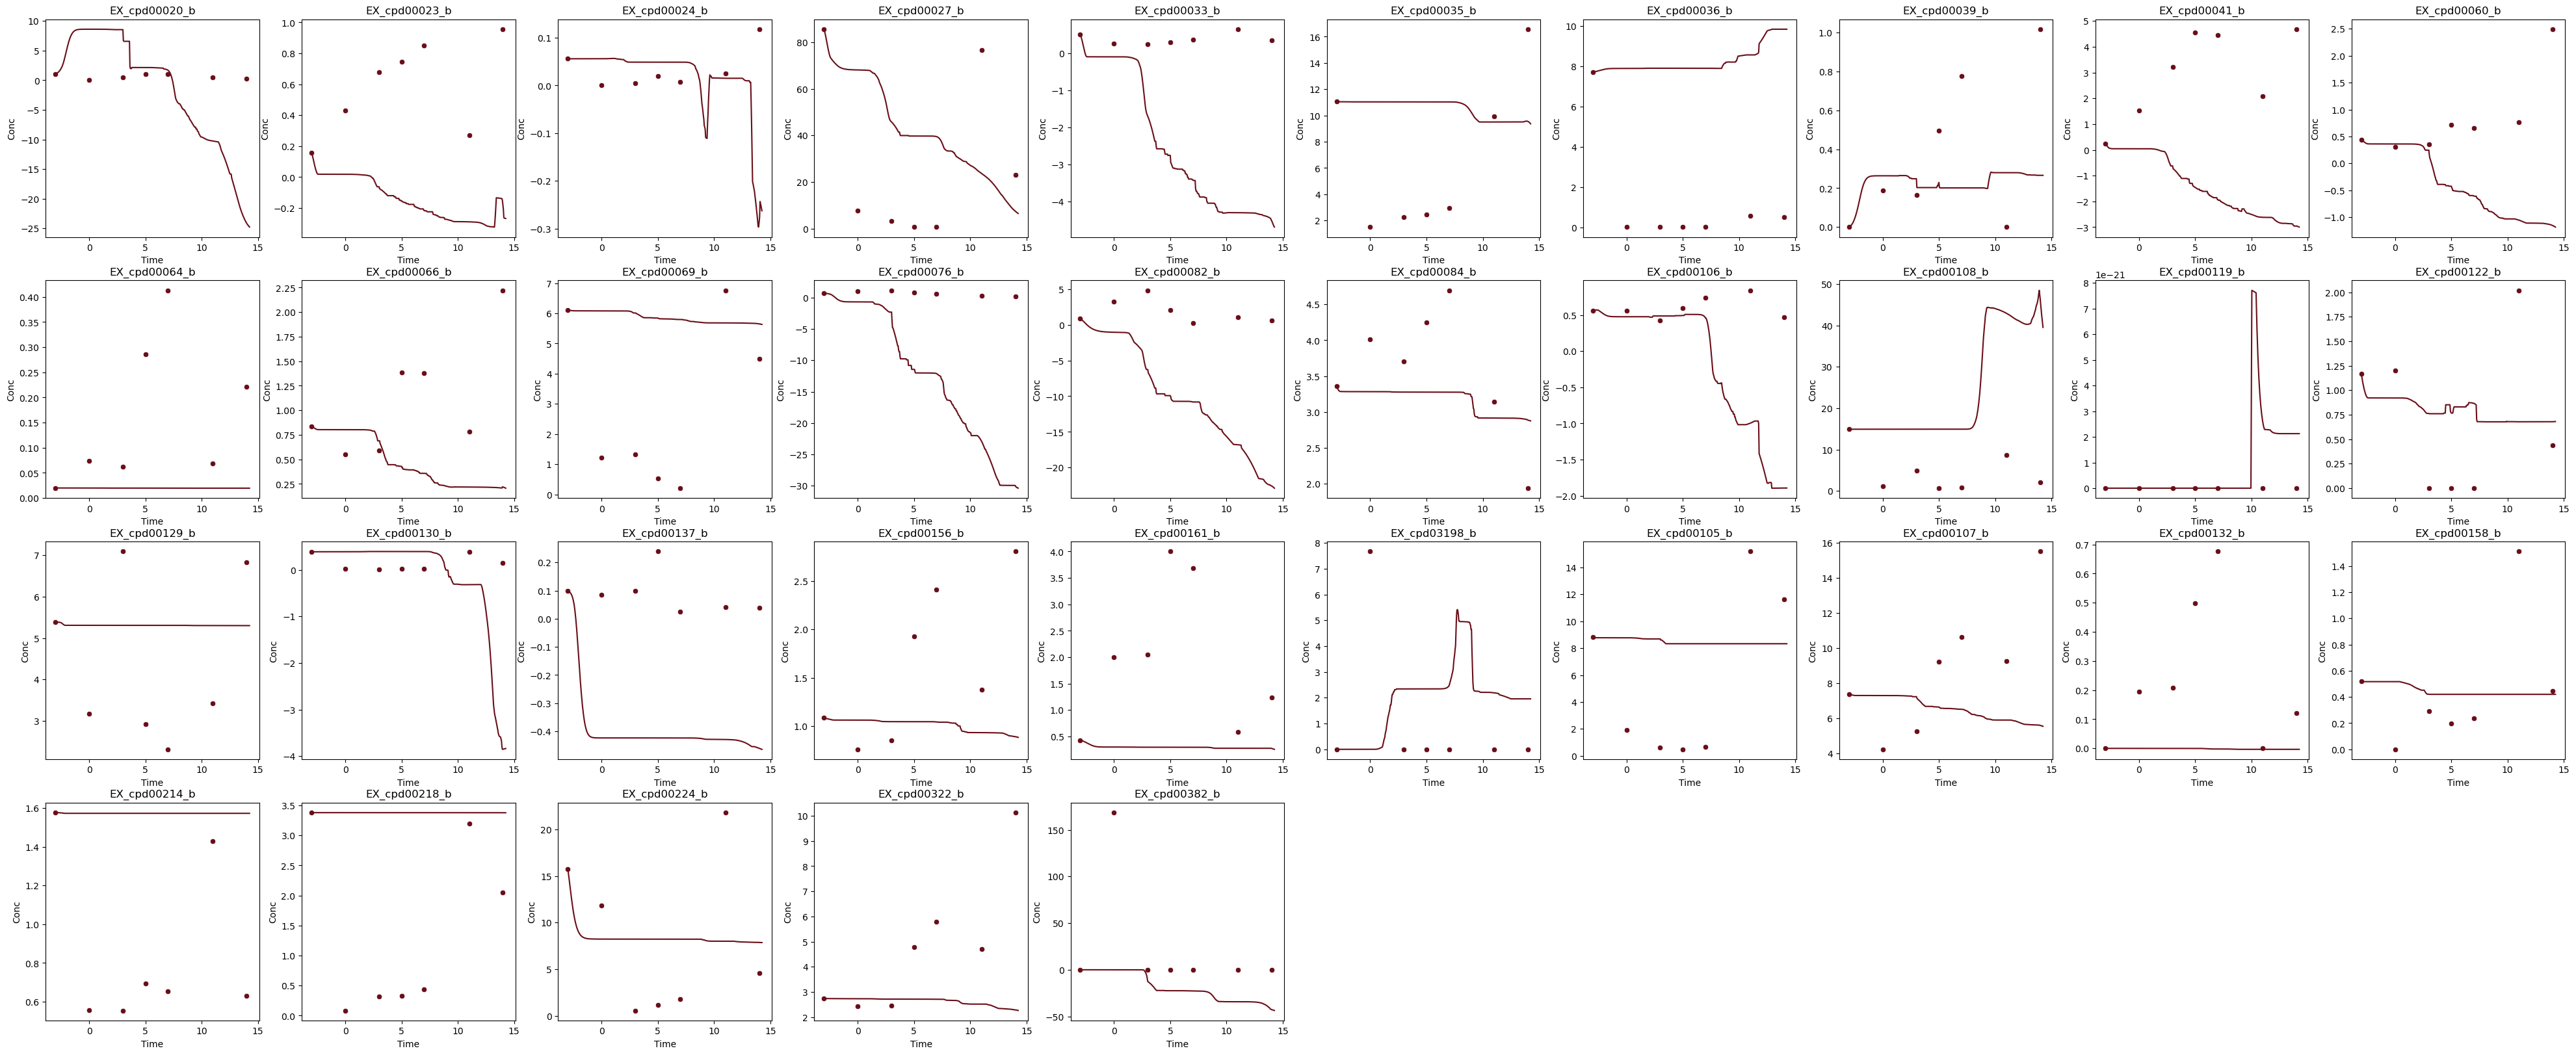

In [ ]:
num_plots = merged_bac_met_use_df.shape[0]
cols = 10  # Number of columns in the grid
rows = (num_plots + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i,met in enumerate(merged_bac_met_use_df.index.tolist()):
    temp_sim = merged_bac_met_use_df.loc[met,:]
    temp_exp = metabolomics_data_sub_1948.loc[met,:]
        # Scatter plot on the respective subplot
    sns.lineplot(ax=axes[i], 
                    x=temp_sim.index.to_list(), y=temp_sim.to_list())
    sns.scatterplot(ax=axes[i], 
                    x=temp_exp.index.to_list(), y=temp_exp.to_list())

    axes[i].set_title(f"{met}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Conc')
    #axes[i].set_yscale('log')
    #axes[i].legend_.remove()

# Hide any empty subplots if the number of plots is not a perfect square
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])


plot_file_name = plot_dir_path + '/Subject_' + str(subject_to_plot) + '_mets_exp_vs_sim_individual_scatterplots_' + str(test_num) + '.pdf'
#plt.savefig(plot_file_name, bbox_inches="tight")